### Imports

In [4]:
from mpl_toolkits import mplot3d
from sklearn.metrics import silhouette_score
from sklearn.model_selection import RandomizedSearchCV
from tqdm import tqdm
from utils.utils import *

import hdbscan
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import pandas as pd
import sys

%load_ext autotime

/home/ealvarez/miniconda3/envs/Conda_dgl_3.10/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/ealvarez/miniconda3/envs/Conda_dgl_3.10/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/ealvarez/miniconda3/envs/Conda_dgl_3.10/li

time: 171 µs (started: 2023-05-30 13:00:07 -05:00)


/home/ealvarez/miniconda3/envs/Conda_dgl_3.10/lib/python3.10/site-packages/umap/umap_.py:660: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()


### Parameters

In [5]:
import json
  
# Opening JSON file
file = open("parameters.json")
params = json.load(file)

dir = os.path.dirname(os.getcwd())
print(dir)

method = params["method"][params["method_idx"]]
print("Method:\t\t", method)

group = params["group"][params["group_idx"]]
print("Group:\t\t", group)

subgroups = [str(k + 1) for k in range(group[1])]
print("Subgroup:\t", subgroups)

dimensions = params["dimensions"]
dimension = dimensions[0]
print("Dimensions:\t", dimensions)

/home/ealvarez/Project/GNN_Filter
Method:		 dgi
Group:		 ['WT', 5]
Subgroup:	 ['1', '2', '3', '4', '5']
Dimensions:	 [3]
time: 3.13 ms (started: 2023-05-30 13:00:07 -05:00)


### Get common subgraphs

In [77]:
list_graphs = []

time: 611 µs (started: 2023-05-27 18:16:52 -05:00)


In [78]:
graphs = []
for item in tqdm(subgroups):
    weighted_edges = pd.read_csv("{}/output_preprocessing/edges/{}_edges_{}.csv".format(dir, group[0], item))
    G = nx.from_pandas_edgelist(weighted_edges, "source", "target", edge_attr="weight")
    graph_detail(G)
    graphs.append(G)

 20%|███████████▏                                            | 1/5 [00:02<00:10,  2.58s/it]

Num. nodes: 6234
Num. edges: 1243057



 40%|██████████████████████▍                                 | 2/5 [00:04<00:06,  2.20s/it]

Num. nodes: 6231
Num. edges: 939038



 60%|█████████████████████████████████▌                      | 3/5 [00:09<00:06,  3.37s/it]

Num. nodes: 6233
Num. edges: 2252847



 80%|████████████████████████████████████████████▊           | 4/5 [00:17<00:05,  5.18s/it]

Num. nodes: 6226
Num. edges: 3728175



100%|████████████████████████████████████████████████████████| 5/5 [00:25<00:00,  5.20s/it]

Num. nodes: 6226
Num. edges: 4071713

time: 26 s (started: 2023-05-27 18:16:52 -05:00)


In [79]:
H1 = get_subgraphs(graphs)
graph_detail(H1)

list_graphs.append(H1.copy())

100%|████████████████████████████████████████████████████████| 4/4 [00:34<00:00,  8.73s/it]


Num. nodes: 4202
Num. edges: 135076

time: 41 s (started: 2023-05-27 18:17:19 -05:00)


In [80]:
df_edge_embeddings_join_filter_count = pd.DataFrame(H1.edges())
df_edge_embeddings_join_filter_count.columns = ["source", "target"]
df_edge_embeddings_join_filter_count

,source,target
0,243.0404,267.1048
1,243.0404,401.2187
2,243.0404,661.3471
3,243.0404,267.0965
4,243.0404,416.1414
...,...,...
135071,579.4245,579.4980
135072,663.3295,663.3449
135073,226.0573,226.0718
135074,412.8122,412.8271


time: 91.7 ms (started: 2023-05-27 18:18:00 -05:00)


In [81]:
# Get weight
df_edge_embeddings_join_filter_count_weight = df_edge_embeddings_join_filter_count.copy()
s = []
t = []
for row in df_edge_embeddings_join_filter_count_weight.itertuples():
    if row[1] > row[2]:
        s.append(row[2])
        t.append(row[1])
    else:
        s.append(row[1])
        t.append(row[2])
df_edge_embeddings_join_filter_count_weight["source"] = s
df_edge_embeddings_join_filter_count_weight["target"] = t

# df_edge_embeddings_join_filter_count_weight = df_edge_embeddings_join_filter_count.copy()
df_edge_embeddings_join_filter_count_weight.sort_values(["source", "target"], ascending=True, inplace=True)
df_edge_embeddings_join_filter_count_weight["idx"] = df_edge_embeddings_join_filter_count_weight["source"].astype(str) + "-" + df_edge_embeddings_join_filter_count_weight["target"].astype(str)
list_aux = df_edge_embeddings_join_filter_count_weight.iloc[:, -1].values

for i in tqdm(subgroups):
    df_edges = pd.read_csv("{}/output_preprocessing/edges/{}_edges_{}.csv".format(dir, group[0], i))
    df_edges.sort_values(["source", "target"], ascending=True, inplace=True)
    df_edges["idx"] = df_edges["source"].astype(str) + "-" + df_edges["target"].astype(str)
    
    filter = df_edges["idx"].isin(list_aux)
    temp = df_edges[filter]
    list_temp = temp.iloc[:, -2].values
    df_edge_embeddings_join_filter_count_weight["subgroup{}".format(i)] = list_temp
df_edge_embeddings_join_filter_count_weight


100%|████████████████████████████████████████████████████████| 5/5 [00:16<00:00,  3.33s/it]


,source,target,idx,subgroup1,subgroup2,subgroup3,subgroup4,subgroup5
133290,59.0137,59.0291,59.0137-59.0291,0.954735,0.928018,0.841093,0.601605,0.970185
131497,59.0137,349.2758,59.0137-349.2758,0.796859,0.788310,0.560861,0.551982,0.807207
110528,59.0137,350.2793,59.0137-350.2793,0.807013,0.779306,0.576143,0.563560,0.808223
132969,59.0137,350.3033,59.0137-350.3033,0.854806,0.751778,0.539172,0.650983,0.883973
129629,59.0137,389.2739,59.0137-389.2739,0.823682,0.886260,0.723124,0.515230,0.917952
...,...,...,...,...,...,...,...,...
130790,980.7146,981.7177,980.7146-981.7177,0.743341,0.954130,0.878971,0.816034,0.817595
108711,981.5305,981.7177,981.5305-981.7177,0.571209,0.850899,0.670445,0.544705,0.731794
131593,981.7177,996.7096,981.7177-996.7096,0.557537,0.784976,0.563671,0.732291,0.554250
134700,985.5091,985.5490,985.5091-985.549,0.798737,0.577365,0.723628,0.875572,0.644783


time: 16.9 s (started: 2023-05-27 18:18:00 -05:00)


In [82]:
# Dispersion (std)
df_edge_embeddings_join_filter_count_weight_std = df_edge_embeddings_join_filter_count_weight.copy()
df_edge_embeddings_join_filter_count_weight_std["std"] = np.std(df_edge_embeddings_join_filter_count_weight_std.iloc[:, -len(subgroups):], axis=1)
df_edge_embeddings_join_filter_count_weight_std

,source,target,idx,subgroup1,subgroup2,subgroup3,subgroup4,subgroup5,std
133290,59.0137,59.0291,59.0137-59.0291,0.954735,0.928018,0.841093,0.601605,0.970185,0.136282
131497,59.0137,349.2758,59.0137-349.2758,0.796859,0.788310,0.560861,0.551982,0.807207,0.118268
110528,59.0137,350.2793,59.0137-350.2793,0.807013,0.779306,0.576143,0.563560,0.808223,0.112406
132969,59.0137,350.3033,59.0137-350.3033,0.854806,0.751778,0.539172,0.650983,0.883973,0.128241
129629,59.0137,389.2739,59.0137-389.2739,0.823682,0.886260,0.723124,0.515230,0.917952,0.145148
...,...,...,...,...,...,...,...,...,...
130790,980.7146,981.7177,980.7146-981.7177,0.743341,0.954130,0.878971,0.816034,0.817595,0.070631
108711,981.5305,981.7177,981.5305-981.7177,0.571209,0.850899,0.670445,0.544705,0.731794,0.111292
131593,981.7177,996.7096,981.7177-996.7096,0.557537,0.784976,0.563671,0.732291,0.554250,0.099503
134700,985.5091,985.5490,985.5091-985.549,0.798737,0.577365,0.723628,0.875572,0.644783,0.106148


time: 47.1 ms (started: 2023-05-27 18:18:17 -05:00)


In [83]:
# Filter by std
df_edge_embeddings_join_filter_count_weight_std = df_edge_embeddings_join_filter_count_weight_std[df_edge_embeddings_join_filter_count_weight_std["std"] <= 0.3]
df_edge_embeddings_join_filter_count_weight_std.to_csv("{}/output_greedy/edges_filter_weight_std/greedy_{}_edge-filter-weight-std.csv".format(dir, group[0]), index=False)
df_edge_embeddings_join_filter_count_weight_std

,source,target,idx,subgroup1,subgroup2,subgroup3,subgroup4,subgroup5,std
133290,59.0137,59.0291,59.0137-59.0291,0.954735,0.928018,0.841093,0.601605,0.970185,0.136282
131497,59.0137,349.2758,59.0137-349.2758,0.796859,0.788310,0.560861,0.551982,0.807207,0.118268
110528,59.0137,350.2793,59.0137-350.2793,0.807013,0.779306,0.576143,0.563560,0.808223,0.112406
132969,59.0137,350.3033,59.0137-350.3033,0.854806,0.751778,0.539172,0.650983,0.883973,0.128241
129629,59.0137,389.2739,59.0137-389.2739,0.823682,0.886260,0.723124,0.515230,0.917952,0.145148
...,...,...,...,...,...,...,...,...,...
130790,980.7146,981.7177,980.7146-981.7177,0.743341,0.954130,0.878971,0.816034,0.817595,0.070631
108711,981.5305,981.7177,981.5305-981.7177,0.571209,0.850899,0.670445,0.544705,0.731794,0.111292
131593,981.7177,996.7096,981.7177-996.7096,0.557537,0.784976,0.563671,0.732291,0.554250,0.099503
134700,985.5091,985.5490,985.5091-985.549,0.798737,0.577365,0.723628,0.875572,0.644783,0.106148


time: 1.17 s (started: 2023-05-27 18:18:17 -05:00)


In [84]:
df_edge_embeddings_join_filter_count_weight_std = pd.read_csv("{}/output_greedy/edges_filter_weight_std/greedy_{}_edge-filter-weight-std.csv".format(dir, group[0]))
df_edge_embeddings_join_filter_count_weight_std

,source,target,idx,subgroup1,subgroup2,subgroup3,subgroup4,subgroup5,std
0,59.0137,59.0291,59.0137-59.0291,0.954735,0.928018,0.841093,0.601605,0.970185,0.136282
1,59.0137,349.2758,59.0137-349.2758,0.796859,0.788310,0.560861,0.551982,0.807207,0.118268
2,59.0137,350.2793,59.0137-350.2793,0.807013,0.779306,0.576143,0.563560,0.808223,0.112406
3,59.0137,350.3033,59.0137-350.3033,0.854806,0.751778,0.539172,0.650983,0.883973,0.128241
4,59.0137,389.2739,59.0137-389.2739,0.823682,0.886260,0.723124,0.515230,0.917952,0.145148
...,...,...,...,...,...,...,...,...,...
131535,980.7146,981.7177,980.7146-981.7177,0.743341,0.954130,0.878971,0.816034,0.817595,0.070631
131536,981.5305,981.7177,981.5305-981.7177,0.571209,0.850899,0.670445,0.544705,0.731794,0.111292
131537,981.7177,996.7096,981.7177-996.7096,0.557537,0.784976,0.563671,0.732291,0.554250,0.099503
131538,985.5091,985.5490,985.5091-985.549,0.798737,0.577365,0.723628,0.875572,0.644783,0.106148


time: 185 ms (started: 2023-05-27 18:18:18 -05:00)


In [85]:
# Average weight
df_edge_embeddings_join_filter_count_weight_std_avg = df_edge_embeddings_join_filter_count_weight_std.copy()
df_edge_embeddings_join_filter_count_weight_std_avg["weight"] = df_edge_embeddings_join_filter_count_weight_std_avg.iloc[:, -(len(subgroups) + 1):-1].mean(axis=1)
df_edge_embeddings_join_filter_count_weight_std_avg

,source,target,idx,subgroup1,subgroup2,subgroup3,subgroup4,subgroup5,std,weight
0,59.0137,59.0291,59.0137-59.0291,0.954735,0.928018,0.841093,0.601605,0.970185,0.136282,0.859127
1,59.0137,349.2758,59.0137-349.2758,0.796859,0.788310,0.560861,0.551982,0.807207,0.118268,0.701044
2,59.0137,350.2793,59.0137-350.2793,0.807013,0.779306,0.576143,0.563560,0.808223,0.112406,0.706849
3,59.0137,350.3033,59.0137-350.3033,0.854806,0.751778,0.539172,0.650983,0.883973,0.128241,0.736142
4,59.0137,389.2739,59.0137-389.2739,0.823682,0.886260,0.723124,0.515230,0.917952,0.145148,0.773249
...,...,...,...,...,...,...,...,...,...,...
131535,980.7146,981.7177,980.7146-981.7177,0.743341,0.954130,0.878971,0.816034,0.817595,0.070631,0.842014
131536,981.5305,981.7177,981.5305-981.7177,0.571209,0.850899,0.670445,0.544705,0.731794,0.111292,0.673811
131537,981.7177,996.7096,981.7177-996.7096,0.557537,0.784976,0.563671,0.732291,0.554250,0.099503,0.638545
131538,985.5091,985.5490,985.5091-985.549,0.798737,0.577365,0.723628,0.875572,0.644783,0.106148,0.724017


time: 36.7 ms (started: 2023-05-27 18:18:18 -05:00)


In [86]:
df_edge_embeddings_join_filter_count_weight_std_avg = df_edge_embeddings_join_filter_count_weight_std_avg.iloc[:, [0, 1, -1]]
df_edge_embeddings_join_filter_count_weight_std_avg.to_csv("{}/output_greedy/edges_filter_weight_std_avg/greedy_{}_edge-filter-weight-std-avg.csv".format(dir, group[0]), index=False)
df_edge_embeddings_join_filter_count_weight_std_avg

,source,target,weight
0,59.0137,59.0291,0.859127
1,59.0137,349.2758,0.701044
2,59.0137,350.2793,0.706849
3,59.0137,350.3033,0.736142
4,59.0137,389.2739,0.773249
...,...,...,...
131535,980.7146,981.7177,0.842014
131536,981.5305,981.7177,0.673811
131537,981.7177,996.7096,0.638545
131538,985.5091,985.5490,0.724017


time: 344 ms (started: 2023-05-27 18:18:19 -05:00)


In [87]:
df_edge_embeddings_join_filter_count_weight_std_avg = pd.read_csv("{}/output_greedy/edges_filter_weight_std_avg/greedy_{}_edge-filter-weight-std-avg.csv".format(dir, group[0]))
df_edge_embeddings_join_filter_count_weight_std_avg

,source,target,weight
0,59.0137,59.0291,0.859127
1,59.0137,349.2758,0.701044
2,59.0137,350.2793,0.706849
3,59.0137,350.3033,0.736142
4,59.0137,389.2739,0.773249
...,...,...,...
131535,980.7146,981.7177,0.842014
131536,981.5305,981.7177,0.673811
131537,981.7177,996.7096,0.638545
131538,985.5091,985.5490,0.724017


time: 49.6 ms (started: 2023-05-27 18:18:19 -05:00)


In [88]:
H2 = nx.from_pandas_edgelist(df_edge_embeddings_join_filter_count_weight_std_avg, "source", "target", edge_attr=["weight"])
graph_detail(H2)

list_graphs.append(H2.copy())

Num. nodes: 4181
Num. edges: 131540

time: 554 ms (started: 2023-05-27 18:18:19 -05:00)


### ANOVA

In [89]:
# Load dataset Groups
df1 = pd.read_csv("{}/input/Edwin_proyecto2/{}.csv".format(dir, "int1"), delimiter="|")
df2 = pd.read_csv("{}/input/Edwin_proyecto2/{}.csv".format(dir, "int2"), delimiter="|")
df3 = pd.read_csv("{}/input/Edwin_proyecto2/{}.csv".format(dir, "int3"), delimiter="|")
df4 = pd.read_csv("{}/input/Edwin_proyecto2/{}.csv".format(dir, "int4"), delimiter="|")
# df5_ = pd.read_csv("{}/inputs/Edwin_proyecto2/{}.csv".format(dir, "int5"), delimiter="|")

""" df1 = pd.read_csv("{}/inputs/SecondDataset/{}.csv".format(dir, "intensities1"), delimiter="|")
df2 = pd.read_csv("{}/inputs/SecondDataset/{}.csv".format(dir, "intensities2"), delimiter="|")
df3 = pd.read_csv("{}/inputs/SecondDataset/{}.csv".format(dir, "intensities3"), delimiter="|")
df4 = pd.read_csv("{}/inputs/SecondDataset/{}.csv".format(dir, "intensities4"), delimiter="|")
df5_ = pd.read_csv("{}/inputs/SecondDataset/{}.csv".format(dir, "intensities5"), delimiter="|") """

print(df1.shape)
print(df2.shape)
print(df3.shape)
print(df4.shape)
# print(df5_.shape)

(6245, 102)
(6245, 72)
(6245, 97)
(6245, 137)
time: 176 ms (started: 2023-05-27 18:18:20 -05:00)


In [90]:
# concat
# df_join_raw = pd.concat([df1.iloc[:,1:], df2.iloc[:, 2:], df3.iloc[:, 2:], df4.iloc[:, 2:], df5.iloc[:, 2:]], axis=1)
df_join_raw = pd.concat([df1.iloc[:, 1:], df2.iloc[:, 2:], df3.iloc[:, 2:], df4.iloc[:, 2:]], axis=1)
df_join_raw.set_index(["ionMz"], inplace=True)

print(df_join_raw.shape)
df_join_raw

(6245, 400)


,0001 / zwf1^ 3.4,0002 / zwf1^ 3.4,0003 / zwf1^ 3.4,0004 / zwf1^ 3.4,0005 / zwf1^ 3.4,0006 / zwf1^ 3.4,0007 / zwf1^ 3.4,0008 / zwf1^ 3.4,0009 / zwf1^ 3.4,0010 / zwf1^ 3.4,...,0951 / WT 3.4,0952 / WT 3.4,0953 / WT 3.4,0954 / WT 3.4,0955 / WT 3.4,0956 / WT 3.4,0957 / WT 3.4,0958 / WT 3.4,0959 / WT 3.4,0960 / WT 3.4
ionMz,,,,,,,,,,,,,,,,,,,,,
59.0049,1,47,508,360,675,232,59,345,346,504,...,45,817,32,307,410,716,228,187,361,952
59.0137,53182,57902,51861,62812,54291,54395,59054,52547,57544,63538,...,45747,39677,47205,38697,54320,62610,47283,49927,43632,48511
59.0291,2151,2102,2334,2864,2393,2246,2331,1954,2310,2528,...,1852,1717,1830,1660,2006,2539,2103,2276,1643,2522
59.0370,83,174,366,1134,693,464,235,479,443,691,...,225,349,185,429,186,278,364,368,115,887
59.0453,1,1,51,642,493,143,11,227,160,154,...,60,293,1,336,65,142,1,182,10,684
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996.5509,2470,2435,2465,2727,2773,2157,2168,2623,2256,2636,...,1866,1834,1669,674,2533,1017,2983,1814,2160,1899
996.7096,3366,3241,2909,3469,3538,3010,3031,2872,2709,3601,...,1748,1419,1160,621,1758,1474,1973,1023,1769,1629
997.5542,2818,2335,1807,1679,2222,2070,2158,1835,2087,2784,...,1168,828,1162,1103,2253,1419,2306,1542,827,1433


time: 23.4 ms (started: 2023-05-27 18:18:20 -05:00)


In [91]:
# get groud
if group[0] == "zwf1^":
    r = "zwf1"
elif group[0] == "pck1^":
    r = "pck1"
else:
    r = group[0]

df_raw_group = df_join_raw.filter(regex=r, axis=1)
df_raw_group

,0071 / WT 2.2,0072 / WT 2.2,0073 / WT 2.2,0074 / WT 2.2,0075 / WT 2.2,0076 / WT 2.2,0077 / WT 2.2,0078 / WT 2.2,0079 / WT 2.2,0080 / WT 2.2,...,0951 / WT 3.4,0952 / WT 3.4,0953 / WT 3.4,0954 / WT 3.4,0955 / WT 3.4,0956 / WT 3.4,0957 / WT 3.4,0958 / WT 3.4,0959 / WT 3.4,0960 / WT 3.4
ionMz,,,,,,,,,,,,,,,,,,,,,
59.0049,528,1,378,438,530,250,662,431,305,334,...,45,817,32,307,410,716,228,187,361,952
59.0137,56523,24625,78586,76559,67449,74919,88152,99718,86001,93962,...,45747,39677,47205,38697,54320,62610,47283,49927,43632,48511
59.0291,2290,927,3149,3038,2774,3419,3911,3820,3374,3746,...,1852,1717,1830,1660,2006,2539,2103,2276,1643,2522
59.0370,320,195,1137,642,588,799,602,606,768,372,...,225,349,185,429,186,278,364,368,115,887
59.0453,196,59,555,405,234,413,46,148,95,25,...,60,293,1,336,65,142,1,182,10,684
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996.5509,2050,1415,3851,2285,2038,3089,2737,2788,1819,2600,...,1866,1834,1669,674,2533,1017,2983,1814,2160,1899
996.7096,2681,1984,3570,2169,2479,2668,3033,3271,2264,2411,...,1748,1419,1160,621,1758,1474,1973,1023,1769,1629
997.5542,1516,1307,2299,2363,2877,1436,1771,2326,1629,2740,...,1168,828,1162,1103,2253,1419,2306,1542,827,1433


time: 24.9 ms (started: 2023-05-27 18:18:20 -05:00)


In [92]:
# Logarithm

df_raw_log = df_raw_group.copy()
for column in df_raw_group.columns:
  df_raw_log[column] = np.log10(df_raw_group[column], where=df_raw_group[column]>0)
  # df_raw_log[column] = np.log10(df_raw_group[column], out=np.zeros_like(df_raw_group[column]), where=df_raw_group[column]>0)
df_raw_log

,0071 / WT 2.2,0072 / WT 2.2,0073 / WT 2.2,0074 / WT 2.2,0075 / WT 2.2,0076 / WT 2.2,0077 / WT 2.2,0078 / WT 2.2,0079 / WT 2.2,0080 / WT 2.2,...,0951 / WT 3.4,0952 / WT 3.4,0953 / WT 3.4,0954 / WT 3.4,0955 / WT 3.4,0956 / WT 3.4,0957 / WT 3.4,0958 / WT 3.4,0959 / WT 3.4,0960 / WT 3.4
ionMz,,,,,,,,,,,,,,,,,,,,,
59.0049,2.722634,0.000000,2.577492,2.641474,2.724276,2.397940,2.820858,2.634477,2.484300,2.523746,...,1.653213,2.912222,1.505150,2.487138,2.612784e+00,2.854913e+00,2.357935,2.271842,2.557507,2.978637
59.0137,4.752225,4.391376,4.895345,4.883996,4.828976,4.874592,4.945232,4.998774,4.934504,4.972952,...,4.660363,4.598539,4.673988,4.587677,4.734960e+00,4.796644e+00,4.674705,4.698335,4.639805,4.685840
59.0291,3.359835,2.967080,3.498173,3.482588,3.443106,3.533899,3.592288,3.582063,3.528145,3.573568,...,3.267641,3.234770,3.262451,3.220108,3.302331e+00,3.404663e+00,3.322839,3.357172,3.215638,3.401745
59.0370,2.505150,2.290035,3.055760,2.807535,2.769377,2.902547,2.779596,2.782473,2.885361,2.570543,...,2.352183,2.542825,2.267172,2.632457,2.269513e+00,2.444045e+00,2.561101,2.565848,2.060698,2.947924
59.0453,2.292256,1.770852,2.744293,2.607455,2.369216,2.615950,1.662758,2.170262,1.977724,1.397940,...,1.778151,2.466868,0.000000,2.526339,1.812913e+00,2.152288e+00,0.000000,2.260071,1.000000,2.835056
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996.5509,3.311754,3.150756,3.585574,3.358886,3.309204,3.489818,3.437275,3.445293,3.259833,3.414973,...,3.270912,3.263399,3.222456,2.828660,3.403635e+00,3.007321e+00,3.474653,3.258637,3.334454,3.278525
996.7096,3.428297,3.297542,3.552668,3.336260,3.394277,3.426186,3.481872,3.514681,3.354876,3.382197,...,3.242541,3.151982,3.064458,2.793092,3.245019e+00,3.168497e+00,3.295127,3.009876,3.247728,3.211921
997.5542,3.180699,3.116276,3.361539,3.373464,3.458940,3.157154,3.248219,3.366610,3.211921,3.437751,...,3.067443,2.918030,3.065206,3.042576,3.352761e+00,3.151982e+00,3.362859,3.188084,2.917506,3.156246


time: 104 ms (started: 2023-05-27 18:18:20 -05:00)


In [93]:
subgroups = [item.split("{} ".format(group[0]))[1].split(".")[0] for item in list(df_raw_log.columns)]
subgroups = np.unique(subgroups)
subgroups

array(['1', '2', '3', '4', '5'], dtype='<U1')

time: 3.41 ms (started: 2023-05-27 18:18:21 -05:00)


In [94]:
# Split graph

list_raw = []

for item in subgroups:
  list_raw.append(df_raw_log.filter(like="{} {}.".format(group[0], item)))

print(len(list_raw))
list_raw[0]

5


,0091 / WT 1.3,0092 / WT 1.3,0093 / WT 1.3,0094 / WT 1.3,0095 / WT 1.3,0096 / WT 1.3,0097 / WT 1.3,0098 / WT 1.3,0099 / WT 1.3,0100 / WT 1.3,...,0821 / WT 1.4,0822 / WT 1.4,0823 / WT 1.4,0824 / WT 1.4,0825 / WT 1.4,0826 / WT 1.4,0827 / WT 1.4,0828 / WT 1.4,0829 / WT 1.4,0830 / WT 1.4
ionMz,,,,,,,,,,,,,,,,,,,,,
59.0049,2.515874,2.453318,2.832509,2.687529,2.515874,1.973128,2.873902,2.670246,2.795185,2.675778,...,2.686636,2.658011,2.689309e+00,2.902003e+00,2.872739,2.378398,2.842609,2.836957,3.044148,2.672098
59.0137,5.101637,5.073656,5.191384,5.053144,5.127630,5.014327,5.236834,5.009944,5.198135,5.278424,...,4.904088,4.937468,4.943069e+00,4.867391e+00,4.962649,4.961786,4.989499,4.914708,4.984023,4.986274
59.0291,3.683497,3.647872,3.772762,3.684486,3.743196,3.626853,3.847819,3.593618,3.759290,3.860038,...,3.530072,3.522053,3.543323e+00,3.539076e+00,3.593618,3.594614,3.639088,3.568671,3.661623,3.615529
59.0370,2.841985,2.990783,3.060320,3.089198,3.143951,2.880242,3.228657,2.829947,2.930949,3.070776,...,2.990339,3.022428,2.748963e+00,2.927883e+00,2.843233,2.973128,2.937518,3.072985,2.995196,2.896526
59.0453,0.000000,2.475671,2.632457,2.597695,2.862131,2.468347,2.568202,2.553883,2.403121,2.113943,...,2.499687,2.424882,0.000000e+00,2.588832e+00,2.459392,2.665581,2.596597,2.874482,2.693727,2.397940
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996.5509,3.431203,3.400538,3.375481,3.477266,3.579669,3.106191,3.448397,3.398461,3.493179,3.498724,...,3.274620,3.240549,3.348500e+00,2.993436e+00,3.167022,3.196729,3.121560,3.302980,3.147985,3.387034
996.7096,2.877371,3.203305,3.030600,3.000000,3.068557,3.232996,2.970812,3.075547,3.157457,3.283075,...,2.978181,3.010724,3.106191e+00,2.926342e+00,2.813581,2.968016,2.629410,2.843855,3.015360,3.181272
997.5542,3.253822,3.159868,3.400538,3.302547,3.332842,3.306639,3.492201,3.340841,3.473633,3.412461,...,2.882525,3.237795,2.848189e+00,2.903090e+00,3.129045,2.842609,3.232742,3.332438,3.104828,2.862728


time: 36.6 ms (started: 2023-05-27 18:18:21 -05:00)


In [95]:
list_raw_copy = list_raw[:]

for k, item in enumerate(list_raw_copy):
    item.columns = [chr(65 + k)]*len(item.columns)

time: 1.98 ms (started: 2023-05-27 18:18:21 -05:00)


In [96]:
# Filter by graph and concat 
nodes = list(H2.nodes())
df_raw_filter = list_raw_copy[0].loc[nodes, :]

for k in range(1, len(subgroups)):
    df_temp = list_raw_copy[k].loc[nodes, :]
    # df_raw_filter = df_raw_filter.join(df_temp)
    df_raw_filter = pd.concat([df_raw_filter, df_temp], axis=1)

df_raw_filter.to_csv("{}/output_greedy/matrix/greedy_{}_matrix_copy.csv".format(dir, group[0]), index=True)
df_raw_filter

,A,A,A,A,A,A,A,A,A,A,...,E,E,E,E,E,E,E,E,E,E
ionMz,,,,,,,,,,,,,,,,,,,,,
59.0137,5.101637,5.073656,5.191384,5.053144,5.127630,5.014327,5.236834,5.009944,5.198135,5.278424,...,4.675879,4.755280,4.687681,4.671071,4.633378,4.749458,4.704485,4.698370,4.683947,4.712448
59.0291,3.683497,3.647872,3.772762,3.684486,3.743196,3.626853,3.847819,3.593618,3.759290,3.860038,...,3.373831,3.409764,3.314710,3.294687,3.278754,3.404149,3.325516,3.282622,3.417804,3.319314
349.2758,5.257571,5.206707,5.276522,5.255923,5.214160,5.247069,5.299169,5.262506,5.377057,5.338753,...,4.657486,4.689522,4.707161,4.748095,4.676099,4.724030,4.739667,4.717254,4.714238,4.716429
350.2793,4.554683,4.540742,4.586981,4.581403,4.579544,4.554307,4.618613,4.589425,4.682118,4.677434,...,4.039969,4.066214,4.061867,4.025961,3.994625,4.081167,4.060131,4.048985,4.002986,4.008387
350.3033,3.862847,3.763727,3.853272,3.801129,3.848128,3.760799,3.868879,3.779957,3.918816,3.860098,...,3.320562,3.282849,3.381837,3.264109,3.362294,3.343802,3.442950,3.299943,3.292034,3.311966
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
980.0986,2.822822,2.903633,2.933487,3.033424,2.773786,2.898176,3.129690,2.778874,2.737987,2.861534,...,3.125156,2.392697,2.866878,3.100026,2.763428,2.744293,2.962369,2.707570,3.104146,3.174641
985.5091,3.099335,3.335658,3.382197,3.236789,3.277151,3.104146,3.169674,3.337260,3.256718,3.251395,...,3.197005,3.309204,3.135451,3.409933,3.204391,3.344392,3.358506,3.187803,3.273927,3.288026
985.5490,3.133858,3.294687,3.276692,3.133219,3.239299,3.212720,2.837588,3.193681,3.090611,3.307068,...,3.436957,3.440437,3.449015,3.569608,3.458336,3.533391,3.477555,3.477121,3.437592,3.498724


time: 955 ms (started: 2023-05-27 18:18:21 -05:00)


In [97]:
# df_raw_filter = pd.read_csv("{}/output_greedy/matrix/greedy_{}_matrix_copy.csv".format(dir, group[0]), index_col=0n)
# df_raw_filter

time: 473 µs (started: 2023-05-27 18:18:22 -05:00)


---

In [119]:
import numpy as np
from scipy.stats import f_oneway
a = np.array([[5, 10, 15, 20, 30]])
b = np.array([[1, 2, 3, 4, 5]])

c = np.array([[2, 4, 6, 8, 10]])
d = np.array([[3, 6, 9, 12, 15]])

print(a.shape)
print(b.shape)
print(c.shape)
print(d.shape)

F, p = f_oneway(a, b, c, d)
print(len(p))
print(p)


(1, 5)
(1, 5)
(1, 5)
(1, 5)
5
[nan nan nan nan nan]
time: 3.94 ms (started: 2023-05-30 17:17:24 -05:00)


In [120]:
from scipy.stats import f_oneway

a = np.array([[9.87, 9.03, 6.81],
              [7.18, 8.35, 7.00],
              [8.39, 7.58, 7.68],
              [7.45, 6.33, 9.35],
              [6.41, 7.10, 9.33],
              [8.00, 8.24, 8.44]])
b = np.array([[6.35, 7.30, 7.16],
              [6.65, 6.68, 7.63],
              [5.72, 7.73, 6.72],
              [3.31, 8.77, 1.01],
              [8.25, 3.24, 3.62],
              [6.32, 8.81, 5.19],
              [7.01, 9.19, 7.41],
              [7.75, 7.87, 8.30],
              [7.75, 7.87, 8.30],
              [6.90, 7.97, 6.97]])
c = np.array([[3.31, 8.77, 1.01],
              [8.25, 3.24, 3.62],
              [6.32, 8.81, 5.19],
              [7.48, 8.83, 8.91],
              [8.59, 6.01, 6.07],
              [3.07, 9.72, 7.48]])
print(a.shape)
print(b.shape)
print(c.shape)

F, p = f_oneway(a, b, c)
p

(6, 3)
(10, 3)
(6, 3)


array([0.20607175, 0.96697718, 0.11998802])

time: 8.34 ms (started: 2023-05-30 17:17:39 -05:00)


In [98]:
tillamook = [0.0571, 0.0813, 0.0831, 0.0976, 0.0817, 0.0859, 0.0735,
             0.0659, 0.0923, 0.0836]
newport = [0.0873, 0.0662, 0.0672, 0.0819, 0.0749, 0.0649, 0.0835,
           0.0725]
petersburg = [0.0974, 0.1352, 0.0817, 0.1016, 0.0968, 0.1064, 0.105]
magadan = [0.1033, 0.0915, 0.0781, 0.0685, 0.0677, 0.0697, 0.0764,
           0.0689]
tvarminne = [0.0703, 0.1026, 0.0956, 0.0973, 0.1039, 0.1045]

a = [-6.28570, -6.28570]	
b = [-5.28570 -6.28570]
F, p = f_oneway(a, b)
p

0.0

time: 5.78 ms (started: 2023-05-30 17:03:36 -05:00)


In [104]:
performance1 = [89, 89, 88, 78, 79, 65]
performance2 = [93, 92, 94, 89, 88]
performance3 = [89, 88, 89, 93, 90]
performance4 = [81, 78, 81, 92, 82]
 
# Conduct the one-way ANOVA
f_oneway(performance1, performance2, performance3, performance4)

F_onewayResult(statistic=3.6653688286748345, pvalue=0.03335041180614558)

time: 4.78 ms (started: 2023-05-30 17:07:08 -05:00)


In [ ]:
[array([-6.2857, -6.2857]), array([-5.2857, -6.2857])]

[[-6.2857 -5.2857]
 [-6.2857 -6.2857]]

---

In [44]:
l1 = [2.722633922533812, 4.752225204288859, 3.359835482339888, 2.505149978319906, 2.292256071356476, 3.12057393120585, 2.0086001717619175, 3.4340896384178907, 3.1577588860468637, 3.591509808994654, 3.000867721531227, 2.6599162000698504, 3.0670708560453703, 3.216429830876251, 3.0034605321095067, 3.3550682063488506, 3.412124406173317, 3.7026889681591335, 3.447778009294621, 3.461948495203762, 2.330413773349191, 2.7193312869837265, 3.586024382386976, 2.8651039746411278, 2.3443922736851106, 1.5910646070264993, 3.2143138974244, 2.7604224834232123, 3.0285712526925375, 2.8790958795000727, 3.4952667443878105, 1.9138138523837167, 2.934498451243568, 3.398634324538392, 3.0433622780211294, 2.75815462196739, 3.882353746388714, 4.164620489079711, 3.5901728315963144, 3.0849335749367164, 3.153814864344529, 3.0492180226701815, 3.4795753101749884, 3.3070679506612985, 3.4869968884318228, 3.0622058088197126, 2.496929648073215, 2.816241299991783, 2.9273703630390235, 3.1752218003430523, 3.3197304943302246, 3.2415464805965484, 3.0755469613925306, 2.929418925714293, 3.2833012287035497, 2.9425041061680806, 3.6769678142947586, 4.165125569088229, 3.061829307294699, 3.2232362731029975, 3.0755469613925306, 2.7535830588929064, 3.141763230275788, 2.7275412570285567, 4.425599424984822, 3.070037866607755, 2.4927603890268375, 3.6590600722409383, 3.341038631677523, 3.12057393120585, 3.8171024042569233, 2.9429995933660407, 3.240798771117331, 2.9929950984313414, 2.709269960975831, 2.437750562820388, 2.432969290874406, 3.094471128641645, 3.3224260524059526, 3.3510228525841237, 3.279210512601395, 3.0867156639448825, 2.840106094456758, 6.152924028588736, 4.731484006202963, 4.040206627574711, 3.5251744278352715, 3.8134475442648212, 3.238798562713917, 3.4752352226041285, 2.905256048748451, 2.44870631990508, 4.836089812050224, 3.385784958843336, 2.74350976472843, 2.5237464668115646, 3.0538464268522527, 4.700522002159753, 3.4875625602563782, 2.9731278535996988, 2.791690649020118, 3.760497875226527, 2.935003151453655, 3.709778601848225, 3.17260293120986, 4.566001210827714, 3.428134794028789, 3.2511513431753545, 3.3306166672944384, 2.9694159123539814, 2.7466341989375787, 2.9474337218870508, 3.2648178230095364, 4.404097870640489, 3.1658376246901283, 3.1007150865730817, 3.5753033334223994, 3.253580289562183, 4.686823886840014, 3.336259552014193, 2.8530895298518657, 4.015778756389041, 3.1192558892779365, 3.5683190850951116, 3.019116290447073, 3.7987887139512493, 3.885191540606848, 3.1112625136590655, 3.02816441942447, 2.7649229846498886, 2.9800033715837464, 5.4185382652465295, 3.9861892997368242, 3.3261309567107946, 3.0982975364946976, 2.8407332346118066, 2.90687353472207, 2.803457115648414, 3.0285712526925375, 3.780173243642594, 4.296314103353241, 3.232742062720737, 3.278296208091274, 0.0, 3.0195316845312554, 3.521399628115376, 2.989894563718773, 4.083681747274301, 3.231214647962601, 3.248218561190075, 3.3690302218091532, 3.1300119496719043, 3.1806992012960347, 3.6759615496421696, 3.644832328825636, 3.746322765089953, 3.6570558528571038, 3.51067903103221, 3.4360035356698964, 3.569022586029564, 4.257030248593287, 3.2237554536572413, 3.0863598306747484, 3.0852905782300653, 2.649334858712142, 2.5943925503754266, 3.255272505103306, 3.1283992687178066, 3.2395497208404733, 3.5040628826786917, 3.5893910231369333, 3.4292676664331685, 3.5036545192429593, 4.216746333609975, 3.3191060593097763, 3.204662511748219, 2.7307822756663893, 2.832508912706236, 3.1720188094245567, 3.362105319293773, 3.4394905903896835, 2.8627275283179747, 3.067442842776381, 3.059941888061955, 3.493597449000527, 2.1760912590556813, 2.6919651027673606, 3.3694014136966244, 3.2377949932739227, 3.73917663191073, 3.1398790864012365, 2.910624404889201, 2.89707700320942, 3.1061908972634154, 3.253580289562183, 4.629022027382759, 3.3787611753163733, 4.437116093048079, 3.6451273992583912, 3.2971036501492565, 3.0523090996473234, 2.9809119377768436, 2.8926510338773004, 4.71627886617829, 3.5667909123815917, 2.6364878963533656, 3.338456493604605, 2.7075701760979363, 3.176958980586908, 3.491921712586151, 3.695043658821294, 3.599883072073688, 2.9947569445876283, 3.4398062113933303, 3.3157604906657347, 3.0492180226701815, 2.5943925503754266, 3.3386556655787003, 3.095169351431755, 3.097604328874411, 2.890979596989689, 2.797959643737196, 3.012837224705172, 2.6830470382388496, 3.0461047872460387, 2.937517892017347, 3.1280760126687155, 2.9324737646771535, 2.8027737252919755, 3.018284308426531, 3.413467412985825, 3.3102683666324477, 3.2467447097238415, 3.1017470739463664, 3.1031192535457137, 3.773274348337454, 4.542688521735133, 3.7902147702439795, 3.721398375521505, 3.9282421831573093, 2.8876173003357364, 3.060697840353612, 3.546542663478131, 3.2730012720637376, 2.983175072037813, 3.003029470553618, 3.3029799367482493, 3.45499721730946, 3.2942457161381182, 4.308414999096672, 3.2113875529368587, 3.9376181793938234, 3.1189257528257768, 3.018284308426531, 3.1075491297446862, 3.590284403718162, 2.9666109866819346, 3.732232880220498, 3.6119356250401227, 3.3201462861110542, 3.217220655644519, 3.3092041796704077, 3.3271545124094315, 3.7989267385772014, 3.25478968739721, 3.2232362731029975, 3.1000257301078626, 2.2405492482826, 3.218010042984363, 3.164352855784437, 2.998695158311656, 2.584331224367531, 2.6627578316815743, 3.052693941924968, 3.369215857410143, 3.8467699535372186, 2.8998205024270964, 3.6440444928147486, 3.617629297757842, 3.417969642214737, 3.3909351071033793, 3.469822015978163, 3.935003151453655, 3.3226327116922234, 3.620656479819621, 3.3723595825243238, 3.385784958843336, 2.9143431571194407, 3.296665190261531, 3.017450729510536, 3.6745856023029138, 3.2342641243787895, 3.315130317183602, 3.727703883685354, 3.4122925093230467, 3.458486763798207, 3.5296869537729165, 3.646599751720373, 3.392169149489736, 3.34713478291002, 3.379124146070392, 3.1981069988734014, 3.251638220448212, 4.605423571884013, 3.4689378056654614, 2.1958996524092336, 3.068556895072363, 3.290479813330673, 3.2893659515200318, 3.814713612695977, 2.99211148778695, 3.2591158441850663, 3.2543063323312857, 3.109240968588203, 3.1089031276673134, 3.1089031276673134, 3.6346787521786825, 2.9703468762300935, 2.859738566197147, 3.8276277047674334, 4.333950804387247, 3.378942698613437, 3.229425847920695, 4.359019228292674, 3.787672964687493, 3.7133225049870275, 3.5415792439465807, 3.5036545192429593, 3.45117215751254, 3.4331295175804857, 3.3653007486379876, 3.290034611362518, 3.3984608496082234, 3.494154594018443, 3.216429830876251, 3.3552599055273786, 2.9552065375419416, 3.1414497734004674, 3.0199466816788423, 3.0835026198302673, 3.537189226243645, 3.511348515490213, 3.5138831856110926, 3.7813963051967905, 3.0429690733931802, 3.4114513421379375, 3.511214701136388, 3.4583356259919475, 3.338854746252323, 3.3432115901797474, 3.3416323357780544, 3.6104472214421213, 3.448087666692341, 3.6423655808449733, 2.9929950984313414, 3.285782273779395, 3.137986732723532, 3.7996850909091004, 4.846002910895996, 3.518118947143153, 2.9273703630390235, 2.322219294733919, 2.678518379040114, 3.2830749747354715, 3.8978469315795716, 3.654369090975286, 3.809761665107125, 4.194764024110887, 3.5659658174466666, 3.5313511645830595, 3.4533183400470375, 3.4119562379304016, 3.4255342204982635, 4.0848264166974335, 3.81544491624435, 3.474653253362063, 3.3473300153169503, 3.341038631677523, 3.536053155159205, 3.403120521175818, 3.9587071910872846, 3.6006462356623943, 3.5459253293558426, 3.3047058982127653, 3.9179254220647413, 4.136910727481376, 3.4811558708280352, 3.6324572921847245, 3.3283796034387376, 3.276921132065774, 3.3527611917238307, 3.110252917353403, 2.937517892017347, 3.0511525224473814, 3.0149403497929366, 3.2915908256580013, 3.7469454096151047, 3.3328422669943514, 3.9320676922007216, 3.837335868015015, 3.4542348957482654, 3.476976465759527, 3.3546845539547285, 2.9740509027928774, 2.8943160626844384, 3.998956440470486, 3.673389578188305, 3.4080702858871854, 3.4869968884318228, 3.2814878879400813, 3.2975416678181597, 4.518606053180559, 3.4008832155483626, 3.7200765727681406, 3.7423322823571485, 3.555336327995267, 3.834929096460576, 3.5094713521025485, 3.3930484664167784, 3.645815118296642, 3.346548558548474, 4.249173889407112, 3.3049211619008916, 3.1720188094245567, 3.268343913951065, 3.284205067701794, 3.15106325335375, 3.076640443670342, 3.150449409460881, 3.3611609951950263, 3.548635059814752, 3.682686478249768, 3.725666660314179, 3.7066324508732946, 3.679609571779756, 3.670802284260944, 3.77757180469141, 3.474507639116976, 3.4513258084895195, 3.401055725771844, 3.291812687467119, 2.734799829588847, 4.2617623176096195, 3.1547282074401557, 3.03342375548695, 2.9894498176666917, 3.4158077276355434, 3.541953474458236, 3.573103783163991, 3.5346605758284446, 3.557507201905658, 3.411788004543869, 3.4831592097169795, 3.4954055631461936, 3.387033701282363, 3.473194909204938, 3.3807537708039, 3.4888326343824003, 3.1684974835230326, 2.8444771757456815, 2.949390006644913, 3.539577883345309, 3.5957166199434245, 3.701913211212344, 4.303433666006204, 3.7514330818193473, 3.7614767795447017, 3.8153120435243593, 3.7535830588929064, 3.7552648914122466, 4.171697207248836, 3.699837725867246, 3.582290682718994, 3.609914410085998, 4.314604473213435, 3.56702636615906, 3.629409599102719, 3.629919035503542, 2.146128035678238, 2.9907826918031377, 3.2430380486862944, 3.037426497940624, 3.1936810295412816, 2.8698182079793284, 3.711047603867034, 3.1316186643491255, 3.3475251599986895, 4.77205018781323, 3.7239479764316434, 3.614264287358705, 3.567731962548069, 3.4740705032150436, 3.4050046650503694, 3.330819466495837, 3.8120438979302267, 3.6021685513789974, 3.312388949370592, 3.5264685124694775, 3.2688119037397803, 3.012415374762433, 3.1149444157125847, 3.2810333672477277, 3.1920095926536702, 3.0737183503461227, 3.3811150807098507, 3.5379449592914867, 3.4235735197327357, 3.146128035678238, 3.3914644118391033, 3.269045709657623, 3.3296012483565187, 3.3334472744967503, 3.330210784571528, 3.2695129442179165, 3.346157302232008, 3.350441856535061, 3.278753600952829, 3.215108581053093, 3.2052043639481447, 3.182699903336043, 3.381656482585787, 3.4542348957482654, 3.680969718465897, 3.410608542568368, 3.339053735709139, 2.9722028383790646, 3.3014640731433, 3.2973227142053028, 3.34966598409663, 3.257438566859814, 3.0863598306747484, 3.295127085252191, 3.30362797638389, 3.483016420144132, 3.7496590320949, 3.633670406051444, 3.5503506723016156, 3.393926006585837, 3.1010593549081156, 2.9938769149412114, 3.1532049000842846, 3.178113252314632, 3.081707270097349, 3.0017337128090005, 3.2092468487533736, 3.5138831856110926, 3.4099331233312946, 3.6659560294539566, 4.208253193072685, 3.617629297757842, 3.8717480189918714, 3.615634468877416, 3.4650852875574327, 3.4868553552769432, 3.341038631677523, 3.378579576115775, 3.436162647040756, 3.215108581053093, 4.089869801509552, 3.51241754860084, 3.377306251068199, 3.2035767749779724, 3.4300750555519395, 3.9696954111184732, 2.617000341120899, 2.546542663478131, 3.3473300153169503, 3.2734642726213465, 4.049140463158965, 3.540454613671412, 3.229169702539101, 3.4156409798961542, 3.2785249647370174, 3.231214647962601, 4.145382891974875, 3.2750808984568587, 3.0993352776859577, 3.0979510709941502, 3.464042205438811, 3.64777405026883, 3.379486813717274, 3.237292337567459, 3.61394747678035, 3.520483532740792, 3.4027770696103476, 3.4952667443878105, 3.6153186566114788, 3.754118894225413, 3.6258267132857114, 3.5296869537729165, 3.3479151865016914, 3.566555330883055, 3.5790973265526436, 3.2629254693318317, 3.2695129442179165, 3.498999363580153, 4.496777480039011, 3.7407573233077707, 3.3494717992143856, 3.020775488193558, 2.91539983521227, 3.6101276130759956, 2.8312296938670634, 3.613630434925241, 2.8561244442423, 3.0277572046905536, 3.416640507338281, 5.236585121932373, 3.806519134080705, 3.3057811512549824, 3.4126285205443754, 3.280350693046006, 2.9138138523837167, 4.429057499166248, 3.052693941924968, 4.131746945100879, 3.734799829588847, 3.1577588860468637, 3.7969903905456865, 3.249931756634195, 3.3366598234544202, 3.238798562713917, 3.583198773968623, 3.382197210377454, 3.7785130117389247, 3.6386888866901237, 3.385784958843336, 3.525044807036845, 3.513217600067939, 3.4222614508136027, 3.3636119798921444, 3.1925674533365456, 3.193958978019187, 3.1693804953119495, 3.282622112878063, 3.314288660947498, 3.208441356438567, 3.2079035303860515, 3.0989896394011773, 2.9232440186302764, 2.9708116108725178, 3.3003780648707024, 3.2762319579218335, 3.1931245983544616, 3.3963737275365067, 3.346352974450639, 3.5221833176186865, 3.296665190261531, 3.406028944963615, 3.476976465759527, 3.4795753101749884, 3.4578818967339924, 3.2964457942063965, 3.389343311252078, 3.226084115975824, 3.024895960107485, 3.177824971864682, 3.235528446907549, 3.187520720836463, 3.2132520521963968, 3.5809249756756194, 3.446537167073644, 3.4094258686714434, 3.4300750555519395, 3.2875778090787056, 3.2920344359947364, 2.4424797690644486, 3.188647295999717, 3.1470576710283598, 3.0232524596337114, 3.560743301054712, 2.910090545594068, 2.9232440186302764, 3.218010042984363, 3.368286884902131, 3.2730012720637376, 3.27415784926368, 3.184691430817599, 3.196452541703389, 3.197280558125619, 3.327971623623011, 3.7178368674869255, 3.3712526291249394, 3.6697816152085365, 3.4848690327204026, 3.5449357658815024, 3.505149978319906, 3.52270499273475, 4.5061937441392494, 3.647480773173676, 3.550228353055094, 3.631849462159818, 3.4240645254174877, 3.407900540142635, 3.6364878963533656, 3.6030360562505215, 3.720159303405957, 3.5975855017522047, 4.14637613307539, 3.9825425823029432, 3.6489451821656727, 3.5081255360831993, 3.4956830676169153, 3.5900612308037427, 3.524915147539867, 3.526339277389844, 3.5676144427308447, 3.4933186082321015, 3.153814864344529, 3.4867137759824853, 3.338854746252323, 3.7902851640332416, 3.7204900684500517, 3.3895204658463776, 3.3981136917305026, 3.600755149639618, 3.623042434246382, 3.659821158055705, 3.698709349442587, 4.0481697987660175, 4.3483632843851865, 4.7299095815156, 3.650598898172657, 3.245018870737753, 2.8992731873176036, 3.29928933408768, 3.8309092995464433, 2.862131379313037, 3.267406418752904, 3.36078268987328, 3.8153120435243593, 3.5208763816883417, 3.290034611362518, 3.2496874278053016, 3.5643109099606027, 3.2247919564926817, 3.461948495203762, 3.5878231713189552, 4.3805549221542135, 3.395326393069351, 4.553943678062436, 3.381656482585787, 3.0492180226701815, 3.0737183503461227, 3.2022157758011316, 3.5900612308037427, 2.842609239610562, 3.480438147177817, 3.731427587050948, 2.9324737646771535, 3.413467412985825, 3.5177235948337358, 3.6624745037503095, 4.238798562713917, 3.387033701282363, 3.976670880624811, 3.6943419103641815, 3.453471233722936, 3.1565491513317814, 3.8115750058705933, 3.307709923404807, 3.614686342282013, 3.3677285460869766, 3.7966437037851164, 3.469380135849925, 3.26030994579492, 3.617943434828973, 3.1878026387184195, 3.012837224705172, 2.9258275746247424, 3.4551495211798278, 3.744762237065578, 3.3660492098002357, 3.438384107034714, 3.210853365314893, 3.4102709642521845, 3.3334472744967503, 3.3891660843645326, 3.2734642726213465, 3.401055725771844, 3.2247919564926817, 3.370698092575577, 3.641077313325374, 3.5364321758220134, 3.266231696689893, 3.4080702858871854, 3.2586372827240764, 3.2076343673889616, 3.2957869402516096, 3.378216149749878, 3.2132520521963968, 2.8756399370041685, 3.1176026916900845, 3.129367595722986, 3.1945143418824675, 3.137986732723532, 3.5171958979499744, 3.474798818800631, 3.404491617758686, 3.398981066658131, 3.539703238947826, 3.649821463224565, 3.694429690957083, 3.6152133348013584, 3.718999637878718, 3.766784515497859, 4.015401673702949, 3.696356388733332, 3.91126417099837, 3.6015167836500104, 3.9020028913507296, 3.5085297189712867, 4.599806681904171, 3.447778009294621, 3.2113875529368587, 3.0678145111618402, 3.2489536154957075, 3.650695979760611, 3.7366354976868212, 3.6856521841155243, 3.462996612028056, 3.137986732723532, 3.4590907896005865, 3.8250364412213536, 2.739572344450092, 3.0515383905153275, 3.516403148447403, 3.3326404103874627, 3.45499721730946, 3.514547752660286, 3.4614985267830187, 3.3984608496082234, 3.5734518220354854, 3.431524584187451, 3.158060793936605, 3.1550322287909704, 3.3675422735205767, 3.450557009418329, 3.2065560440990297, 3.8379039445929424, 3.3942765267678214, 3.4245549766067134, 3.3884564527002667, 3.54282542695918, 3.5485122563410356, 3.2214142378423385, 3.439332693830263, 0.0, 2.6627578316815743, 2.8129133566428557, 3.1607685618611283, 3.9238654751855013, 3.4292676664331685, 3.4456042032735974, 3.40226138245468, 3.5928426831311002, 3.4818724103106637, 3.369586890736344, 3.4507108781469196, 3.475816413031318, 3.55339751012388, 3.805228914203426, 3.552911450216509, 3.4353665066126613, 3.4222614508136027, 3.4446692309385245, 3.46014581749175, 3.44870631990508, 3.4516329474569907, 3.6961815871685237, 3.5478977175630972, 3.566555330883055, 3.91365493508662, 3.4058583993176366, 2.6919651027673606, 3.1099158630237933, 3.605628222007619, 3.765966424785714, 4.220866133312124, 3.700790221374347, 3.651568738865792, 3.66133934000604, 3.5531545481696254, 3.8475726591421124, 3.714413592287121, 3.5746099413401873, 3.578180609627778, 3.493597449000527, 3.3201462861110542, 3.1586639808139894, 3.1061908972634154, 3.115943176939055, 3.2530955858490316, 3.1455071714096627, 2.9929950984313414, 3.728434950974255, 3.084576277934331, 3.521399628115376, 3.579440597139797, 4.049295568332722, 3.513350798805957, 3.564192460626198, 3.7861833455676335, 3.3376588910261424, 3.4674601095072637, 3.40840957846843, 3.3316297176299323, 3.4212747912103465, 3.438858659420562, 3.7562556487542333, 3.851869600729766, 3.7069736761761782, 3.462397997898956, 3.4734869700645685, 3.355834495884936, 3.2678754193188975, 3.2990712600274095, 3.630224410752432, 3.5722906061514177, 3.7687120803776635, 3.6945174538111565, 3.124178055474675, 3.3021143769562014, 3.2571984261393445, 3.4058583993176366, 2.91539983521227, 2.690196080028514, 3.2605483726369795, 2.9951962915971793, 3.0549958615291417, 2.88930170250631, 3.037027879755775, 3.7216457662897464, 3.889077492650064, 4.138397442990546, 2.9003671286564705, 3.1501421618485588, 3.249198357391113, 3.3473300153169503, 3.4271614029259654, 3.250175948083925, 2.884795363948981, 3.2208922492195193, 3.089198366805149, 3.0507663112330423, 2.983175072037813, 3.0515383905153275, 4.040958173384207, 3.36679638328673, 3.470704429722788, 3.243534101832062, 3.164352855784437, 3.298634783124436, 3.2119210843085093, 3.4056877866727775, 4.420846541601197, 3.2764618041732443, 3.5908418347816027, 3.99370069482035, 3.0285712526925375, 3.488973524726508, 3.779307827583586, 4.242367476911438, 3.7107940999303275, 3.0318122713303706, 3.372175286115064, 3.5535189401489697, 3.784260582566084, 3.5751878449276613, 4.001474096691733, 3.7664872062396944, 3.4730488050885375, 3.17868923977559, 3.3029799367482493, 3.538824988937904, 3.263636068588108, 3.1513698502474603, 3.423737249982329, 3.068556895072363, 3.4331295175804857, 3.3723595825243238, 3.1319392952104246, 3.0895518828864543, 2.9947569445876283, 3.958085848521085, 3.2143138974244, 3.7175872968554606, 3.8912028272602956, 3.7636525705645303, 3.5199591807520685, 3.5732198271144218, 3.595606434865603, 3.6079908585471747, 3.6679196853173615, 3.580810972660946, 3.949048292315664, 3.6624745037503095, 3.890979596989689, 3.619823500457278, 3.141136090120739, 3.4154741681092355, 3.549861188471943, 3.353531559077762, 3.543074235033532, 3.4500950758716025, 3.5974757898703773, 3.4683473304121573, 3.1020905255118367, 3.1997551772534747, 3.2412973871099933, 3.1869563354654122, 3.747023177451628, 3.358886204405869, 3.9979103673467433, 2.8312296938670634, 2.582063362911709, 2.8692317197309762, 3.011993114659257, 3.0852905782300653, 3.109240968588203, 3.343605508104172, 2.8915374576725643, 3.1535099893008374, 3.119585774961784, 3.6291036501771363, 3.1818435879447726, 3.7335182514344876, 3.368286884902131, 3.1852587652965854, 3.0038911662369108, 3.4699692094999595, 3.3316297176299323, 3.4271614029259654, 3.5016069224188295, 3.7025166974381505, 3.549248556854056, 3.4927603890268375, 3.4602963267574753, 3.514547752660286, 3.1734776434529945, 3.4994121256722757, 3.6795187436957892, 3.4295908022233017, 3.6898414091375047, 3.439963935920905, 3.3378584290410944, 3.1852587652965854, 2.9777236052888476, 3.403120521175818, 3.4051755462179893, 3.36285930295868, 3.158060793936605, 3.1325798476597373, 2.8698182079793284, 3.1280760126687155, 3.219846386024361, 3.679337030520794, 3.2286569581089353, 3.529173603261723, 3.327767489902729, 3.5434471800817002, 3.4316853446860116, 4.3215777196957985, 3.1231980750319988, 3.4169731726030363, 3.2641091563058082, 3.0382226383687185, 3.2427898094786767, 3.2875778090787056, 3.429429264381788, 3.7477224620355085, 2.8998205024270964, 3.1863912156954934, 3.204933522354145, 3.7389390312034796, 3.3972445810103866, 3.414973347970818, 4.25478968739721, 3.065206128054312, 3.1936810295412816, 2.9867717342662448, 3.9152942830226865, 3.453471233722936, 3.36679638328673, 5.923612856796522, 4.443497677808585, 3.7585334222372864, 3.4345689040341987, 2.8948696567452528, 3.0755469613925306, 2.5327543789924976, 2.635483746814912, 3.536179532137225, 3.203304916138483, 3.0017337128090005, 1.1139433523068367, 2.926856708949692, 5.184878733139646, 3.66228551572213, 2.9813655090785445, 4.099369826389839, 3.624797578960761, 3.229425847920695, 3.3404441148401185, 3.052693941924968, 3.6051972673883776, 3.199480914862356, 3.445136968713304, 2.977266212427293, 3.1408221801093106, 3.037027879755775, 4.224455364335568, 3.49996186559619, 3.2060158767633444, 3.14674801363064, 3.506910725551518, 3.4051755462179893, 3.3096301674258988, 3.764400322956388, 3.0888445627270045, 3.797198269838959, 3.0557604646877348, 4.076166939344932, 3.7301360039966776, 3.3366598234544202, 3.5868122694433757, 4.5080446543468815, 4.097292024091896, 3.78660947264866, 3.7130703258556395, 3.654465333520146, 3.1149444157125847, 3.2135177569963047, 3.0824263008607717, 3.3224260524059526, 3.520352504083318, 3.465977368285823, 3.2931414834509307, 3.4565178578052627, 3.3289908554494287, 3.5058280338548364, 3.5224442335063197, 3.498034723687027, 3.7000110623221123, 3.7374312005145827, 3.124178055474675, 3.188647295999717, 3.4243915544102776, 3.250907699700856, 3.2979792441593623, 3.9114239653762946, 3.5654936298688624, 3.286456469746983, 2.9894498176666917, 3.5347873586294916, 3.2005769267548483, 3.0141003215196207, 3.369215857410143, 3.497620649781288, 3.505014240084107, 3.332034277027518, 3.527887565952705, 3.8572721735640414, 3.7247672456463103, 3.3281756614383227, 3.307282047033346, 3.9860099318532614, 3.360971883725936, 3.3611609951950263, 3.912487761332324, 3.1956229435869368, 3.5531545481696254, 3.3564083270389813, 3.5269850685599957, 3.4371160930480786, 3.5734518220354854, 3.4252080511386565, 3.482158695411276, 4.135450699345514, 4.013216539624441, 3.3205616801952367, 3.2823955047425257, 3.4456042032735974, 3.3873898263387296, 3.479143247978613, 3.149527013754348, 3.276921132065774, 3.5174598265402324, 4.872028005773688, 3.623042434246382, 3.325720858019412, 3.805568817548556, 2.7283537820212285, 2.9938769149412114, 2.968015713993642, 4.02739038468497, 3.3157604906657347, 3.4072208929273966, 3.485295438726089, 3.6700602174731345, 4.86869732624796, 3.9536630637470913, 3.62879748556671, 3.26030994579492, 4.021561392037355, 3.15896526038341, 3.406028944963615, 3.2762319579218335, 3.505421327583281, 3.423245873936808, 3.208441356438567, 4.016866270828975, 3.464638559095033, 3.2113875529368587, 3.919810020170196, 3.1565491513317814, 4.25698218590157, 3.6148972160331345, 3.7892986111594413, 3.627775375229303, 3.327971623623011, 3.2511513431753545, 3.2286569581089353, 2.9938769149412114, 2.9036325160842376, 3.7550359337677714, 4.317958924700952, 3.2092468487533736, 3.0051805125037805, 3.3861421089308186, 2.5224442335063197, 3.060697840353612, 3.0870712059065353, 2.406540180433955, 3.076276255404218, 3.55339751012388, 3.0515383905153275, 3.197831693328903, 3.244029589030022, 2.935003151453655, 2.6344772701607315, 3.5085297189712867, 2.9786369483844743, 2.989004615698537, 2.7299742856995555, 2.9561684304753633, 3.7331169814420644, 3.0507663112330423, 3.2530955858490316, 3.9006401839826004, 3.65359838184329, 3.5644293269979834, 3.326949994165999, 3.3224260524059526, 3.62797998982998, 3.455910240382743, 3.4111144185509046, 3.3370597263205246, 3.450864692379766, 3.5616975326539935, 3.6503075231319366, 3.5643109099606027, 3.4720246977002813, 3.6243852414202653, 3.6932871570056554, 2.832508912706236, 2.7481880270062002, 3.31722734917642, 3.3541084391474008, 3.031408464251624, 3.0759117614827773, 3.291368850451583, 3.8703453710809597, 3.818621726375889, 3.216165902285993, 3.523616419054371, 3.5440680443502757, 3.48826861549546, 4.003115717099806, 5.135797106533255, 3.889189612047073, 3.6469915374771227, 3.5828584622244994, 3.588159616383092, 3.868879446237088, 3.400365273349939, 3.7632033003707717, 3.139249217571607, 3.3021143769562014, 4.191702463559194, 3.345569756056392, 3.459543258280413, 3.030599721965951, 3.36285930295868, 3.2931414834509307, 3.2496874278053016, 3.1261314072619846, 3.2422929049829308, 3.583425500406507, 3.5293019977879805, 3.2555137128195333, 4.0033743540197495, 3.973312620452902, 3.6426623314420357, 3.3965480379871322, 3.214578953570499, 3.229425847920695, 3.1598678470925665, 3.548020694905531, 3.3740147402919116, 3.503109436671369, 5.395315906959291, 3.960565902818198, 3.391111613702803, 3.106870544478654, 3.400365273349939, 3.3510228525841237, 3.3332456989619628, 3.2957869402516096, 3.2422929049829308, 3.167317334748176, 4.650773629408932, 3.3119656603683665, 3.220108088040055, 3.616160312847583, 3.88371820196396, 3.749040268703457, 3.7856856682809013, 3.8487431818956837, 3.696356388733332, 3.808818425092124, 3.6010817277840235, 3.525304009958239, 3.5743785644130823, 3.519565500880509, 3.7959494989028033, 3.8988896559265864, 3.7822575736633017, 3.344195715871435, 3.3042750504771283, 3.2725377773752373, 3.338854746252323, 3.166133970305109, 3.3211840273023143, 3.130333768495006, 3.5626496722119168, 3.4749443354653877, 3.9387698227831174, 3.3872118003137306, 3.569958818096594, 3.7611758131557314, 3.1950689964685903, 3.163757523981956, 3.020775488193558, 3.1264561134318045, 3.0492180226701815, 2.754348335711019, 3.2245330626060857, 4.558600583342568, 3.109240968588203, 3.1228709228644354, 3.6868149545073168, 3.3012470886362113, 3.2352758766870524, 3.3242824552976926, 3.3443922736851106, 3.269045709657623, 3.303196057420489, 3.5569052690554477, 3.3092041796704077, 3.8767372971406644, 3.126780577012009, 3.0958664534785427, 3.6714505542124947, 3.106870544478654, 3.17260293120986, 3.298634783124436, 2.7528164311882715, 3.2089785172762535, 3.2271150825891253, 3.401228167498113, 2.220108088040055, 0.0, 3.04883008652835, 2.6848453616444123, 5.994010354102488, 4.519618012153399, 3.8043439184798657, 3.5009222391903005, 3.03261876085072, 3.15259407792747, 2.5888317255942073, 2.4345689040341987, 2.1903316981702914, 2.6893088591236203, 2.6273658565927325, 2.783903579272735, 2.558708570533166, 2.6919651027673606, 2.3263358609287517, 3.174931593528443, 2.250420002308894, 3.0090257420869104, 3.452706226511029, 5.277354750918401, 3.747489492258673, 3.0595634179012676, 2.765668554759014, 2.342422680822206, 3.6755033847279566, 3.0402066275747113, 3.2166935991697545, 3.376211850282673, 3.0557604646877348, 3.245265839457461, 2.9656719712201065, 2.7596678446896306, 3.041787318971752, 2.8129133566428557, 4.326806774068438, 2.835056101720116, 2.7558748556724915, 3.077731179652392, 3.778151250383644, 3.2342641243787895, 3.7868933252613157, 3.4776999283321306, 3.4345689040341987, 3.494432898726399, 3.501470072100412, 3.429752280002408, 4.536873948928961, 3.9122752104988123, 3.912806392661292, 3.678791434366244, 3.6267508536833932, 3.731346975545955, 3.638189640190837, 3.4401216031878037, 3.6033609243483804, 3.1316186643491255, 3.5237464668115646, 3.8182258936139557, 3.6450290647211423, 3.5826314394896364, 3.680607428991788, 3.8468317528232574, 3.399327532158679, 3.129367595722986, 5.370871923545715, 4.055989583385691, 3.65628990119136, 3.532117116248804, 3.5359267413955693, 3.4143046881283317, 3.3265406685165617, 3.294466226161593, 3.2678754193188975, 4.478191195390028, 3.2935835134961167, 3.0464951643347082, 3.4324882557705063, 3.1931245983544616, 2.693726948923647, 2.9647309210536292, 3.1075491297446862, 4.069038764986071, 3.537819095073274, 3.2946866242794433, 3.315550534421905, 3.267406418752904, 3.4340896384178907, 3.535547279176668, 4.732273105708592, 3.498172660636544, 3.4050046650503694, 2.9768083373380665, 3.424881636631067, 3.9105710484812586, 2.9025467793139916, 3.0962145853464054, 3.185825359612962, 3.2415464805965484, 3.6281845080734128, 3.7104558643354246, 3.4129642719966626, 3.500648063371912, 4.618121345025621, 3.6356847625472226, 2.949877704036875, 3.3165993020938607, 3.3912880485952974, 3.9189734304929544, 2.0827853703164503, 3.130976691605617, 2.7307822756663893, 2.6655809910179533, 3.1427022457376155, 3.162862993321926, 3.6447339274471924, 3.400710636773231, 3.303412070596742, 3.3861421089308186, 3.3439990690571615, 3.376576957056512, 3.3823773034681137, 3.4500950758716025, 3.1983821300082944, 3.0153597554092144, 3.4326486600131068, 3.518777068926775, 4.572116155664275, 3.5146805441249818, 3.5803546611065915, 3.1961761850399735, 2.9304395947667, 3.7614767795447017, 3.359645792674543, 3.278982116865443, 3.2617385473525378, 3.8903092168999485, 3.584557360525675, 3.4282968139828798, 3.2105860249051563, 4.287152041125502, 3.199480914862356, 3.0644579892269186, 3.144262773761991, 4.07213956323974, 3.656385719058688, 2.9395192526186187, 2.94546858513182, 3.1670217957902564, 3.0610753236297916, 3.397418542351348, 3.9419087743655994, 3.2187979981117376, 3.5854607295085006, 3.101403350555331, 3.5287881917748964, 3.335858911319818, 3.1812717715594614, 4.165333372596983, 3.4679039465228003, 3.6447339274471924, 3.269045709657623, 3.49734438101758, 3.2137832993353044, 3.236033147117636, 3.3594560201209864, 3.3144992279731516, 3.4776999283321306, 3.569490954348783, 3.269045709657623, 3.288249225571986, 3.2337573629655103, 3.844228581301628, 3.2671717284030137, 3.15106325335375, 3.182129214052998, 3.2805783703680764, 3.0784568180532927, 3.3348556896172914, 3.0153597554092144, 3.1335389083702174, 3.2177470732627937, 3.7555699806288, 4.061150780928549, 3.6245914591268478, 3.1812717715594614, 3.1598678470925665, 3.1844074854123203, 3.54282542695918, 3.3418300569205104, 3.627160952374776, 3.66576855071938, 3.677606952720493, 3.535547279176668, 3.6960941599952233, 3.314288660947498, 2.991226075692495, 3.203304916138483, 3.432969290874406, 3.599883072073688, 3.26528962586083, 3.130333768495006, 3.6138418218760693, 3.315550534421905, 3.6652056284346006, 3.7193312869837265, 3.3647385550553985, 3.519827993775719, 3.702947246181556, 3.478999131673357, 3.1908917169221698, 3.0170333392987803, 3.248463717551032, 3.2645817292380777, 3.72607487021537, 3.219060332448861, 3.2734642726213465, 3.4127964287165433, 3.3246939138617746, 3.123524980942732, 3.334051440346892, 3.1711411510283822, 3.392169149489736, 3.3677285460869766, 2.973589623427257, 3.021602716028242, 3.5345337560051155, 3.282622112878063, 3.313234291694724, 3.4647875196459372, 3.3554515201265174, 3.279210512601395, 3.125481265700594, 3.4234097277330933, 3.6100210246641455, 3.3109056293761414, 3.420945405921972, 4.760196229455134, 3.348888723071438, 2.8488047010518036, 5.283995092902252, 3.860397905127313, 3.2833012287035497, 4.079759919660093, 3.3334472744967503, 3.284205067701794, 3.3047058982127653, 3.303412070596742, 3.367355921026019, 4.438289134300749, 3.6568644915489172, 3.345569756056392, 3.4539295920577286, 3.628695382714023, 3.5848963441374497, 3.076640443670342, 3.04766419460156, 4.000477461374455, 3.731024379815688, 3.346744054604849, 3.5035183127240748, 2.958085848521085, 2.7788744720027396, 2.929418925714293, 2.9339931638312424, 2.979092900638326, 3.009450895798694, 3.4211101297934343, 3.5547313766759667, 3.4056877866727775, 3.2971036501492565, 3.2617385473525378, 4.509027693701782, 3.4435758797502576, 3.4095950193968156, 3.1815577738627865, 3.402948829344405, 3.3234583668494677, 3.273232834043046, 3.44870631990508, 3.3378584290410944, 3.391816923613249, 3.434888120867316, 3.6049816296074315, 3.7100326990657537, 3.8715729355458786, 3.2709116394104814, 3.45484486000851, 3.82020145948564, 3.517855418930029, 3.540954808926133, 3.592953571547866, 3.5593080109070123, 3.5122840632818537, 3.466274321789292, 3.7518946880437474, 4.882894356093019, 3.6987962517904314, 3.48572142648158, 3.313445370426414, 3.439963935920905, 3.339848783037637, 4.318355550225704, 3.1699681739968923, 3.0511525224473814, 4.179580513395409, 3.0707764628434346, 3.0759117614827773, 3.621072371143626, 3.2208922492195193, 3.04883008652835, 3.228400358703005, 3.02201573981772, 3.0622058088197126, 2.823474229170301, 3.29928933408768, 3.3919930722597127, 3.2430380486862944, 3.155336037465062, 3.71717102683231, 3.3251049829714074, 3.756560043006683, 2.8965262174895554, 3.1883659260631485, 3.6648299411430907, 3.4712917110589387, 3.466125870418199, 3.5901728315963144, 3.284881714655453, 2.8819549713396007, 3.060320028688285, 3.7726883546821415, 3.634275694625944, 3.4537768596904423, 3.376211850282673, 3.295347148333618, 3.4111144185509046, 3.6742179455767, 3.5081255360831993, 3.3001605369513523, 3.809761665107125, 3.3919930722597127, 3.513084360465144, 3.390758528738717, 2.776701183988411, 2.8530895298518657, 3.0293837776852097, 3.0166155475571776, 3.4724638966069894, 4.177190080489609, 3.6100210246641455, 3.4865721505183562, 3.3242824552976926, 3.1696744340588068, 3.5949447366950835, 3.649918718735419, 3.3220124385824006, 3.0863598306747484, 3.0149403497929366, 3.3027637084729817, 3.423081958297231, 3.250175948083925, 3.4761067168401913, 3.683947130751512, 3.529173603261723, 3.4219328132785085, 3.2208922492195193, 3.1610683854711747, 3.1705550585212086, 3.3569814009931314, 3.2615007731982804, 3.22219604630172, 3.182984967003582, 3.313234291694724, 3.286456469746983, 3.3647385550553985, 3.4396484295634737, 4.0668102756258335, 3.2216749970707688, 3.090258052931316, 3.0382226383687185, 3.465680211598278, 3.095169351431755, 3.225050696138049, 2.842609239610562, 3.1720188094245567, 3.286456469746983, 4.609797103812625, 3.5258219521566625, 3.3136563466180315, 3.281714970027296, 3.2489536154957075, 3.040602340114073, 3.1849751906982613, 3.841797298874355, 4.016615547557177, 3.322839272686321, 3.3937506403480806, 4.53905099433993, 3.3042750504771283, 3.280805928393667, 3.3334472744967503, 3.168202746842631, 3.098643725817057, 3.9086458389071135, 3.621280167550415, 3.669502834104343, 3.2984163800612945, 3.6720978579357175, 3.1772478362556233, 3.022840610876528, 3.130976691605617, 3.330413773349191, 3.317436496535099, 3.0644579892269186, 3.8572118423168926, 3.8129133566428557, 3.8291107101552946, 3.4387005329007363, 3.466422722433792, 3.4412236742426123, 4.3699020200240195, 3.781468142841798, 3.6475785542124552, 3.5908418347816027, 3.491921712586151, 3.3380578754197563, 3.6726519228400023, 3.4413808849165113, 3.4488608456074408, 3.439332693830263, 3.2676409823459154, 3.1835545336188615, 3.4038066105474227, 3.0480531731156093, 3.215108581053093, 3.34143452457814, 3.9064427938170323, 3.780317312140151, 3.6589648426644352, 3.7089305358066165, 3.2487087356009177, 3.4956830676169153, 2.9740509027928774, 2.951823035315912, 3.484299839346786, 3.3092041796704077, 3.5304558435846762, 4.91795689914207, 3.468790262099611, 3.0394141191761372, 3.325310371711061, 3.0354297381845483, 3.2268575702887237, 2.82865989653532, 3.109240968588203, 3.3234583668494677, 3.255995726722402, 3.0322157032979815, 3.1482940974347455, 2.9324737646771535, 3.1451964061141817, 3.2187979981117376, 4.257774540946672, 2.682145076373832, 3.598133645813238, 2.9703468762300935, 2.9684829485539352, 3.0718820073061255, 3.110589710299249, 3.197280558125619, 3.795045370421125, 3.156851901070011, 3.2268575702887237, 3.1945143418824675, 3.1684974835230326, 3.0499928569201424, 4.4766867429456445, 3.315130317183602, 3.2629254693318317, 3.164352855784437, 3.2119210843085093, 3.459392487759231, 3.2727695865517594, 2.9561684304753633, 3.2776092143040914, 3.214843848047698, 3.657151501900967, 3.0788191830988487, 3.1290450598879582, 3.2119210843085093, 3.4712917110589387, 3.1917303933628562, 3.258397804095509, 3.338257230246256, 3.6384892569546374, 3.622214022966295, 3.3881012015705165, 3.39776625612645, 3.187520720836463, 3.3404441148401185, 3.4641913706409997, 3.501196242027089, 3.392169149489736, 3.364926033789976, 3.7410727723733213, 3.4429498695778618, 3.307923703611882, 3.6152133348013584, 3.629613445378183, 3.392696953259666, 3.9884697702098757, 3.0453229787866576, 3.1838390370564214, 3.5959369062691735, 3.46014581749175, 3.4292676664331685, 2.798650645445269, 3.1983821300082944, 3.3096301674258988, 3.0791812460476247, 3.162862993321926, 3.6283889300503116, 3.2095150145426308, 3.315970345456918, 3.3188977146274867, 3.377306251068199, 3.3121773564397787, 3.2166935991697545, 3.595606434865603, 3.3498600821923312, 3.2669369111591733, 3.2095150145426308, 3.6047658847038875, 3.5431985856376467, 3.436162647040756, 3.0402066275747113, 3.3475251599986895, 3.193958978019187, 3.1082266563749283, 3.392169149489736, 3.3380578754197563, 3.401228167498113, 3.4075608494863627, 3.2332500095411003, 3.1931245983544616, 3.4533183400470375, 3.7762652182681093, 3.6679196853173615, 3.582290682718994, 3.669688708056208, 3.5424519473759766, 3.7044936970092985, 3.6058435390580894, 3.4942937686653326, 3.5415792439465807, 3.439016728387513, 3.472171146692363, 4.311414767162359, 3.922829219666649, 3.325310371711061, 3.116939646550756, 3.3554515201265174, 3.375114684692225, 3.356599435724971, 3.3042750504771283, 3.593728998707911, 3.38147609027503, 3.4212747912103465, 3.6137361412618714, 3.410608542568368, 3.4409090820652177, 4.66700441736658, 3.0187004986662433, 3.2195845262142546, 3.2309595557485693, 3.0484418035504044, 3.1878026387184195, 3.5624118329497274, 4.690355587481474, 3.419955748489758, 3.0930713063760633, 3.329194415088451, 3.652826302561005, 3.728434950974255, 3.0584260244570056, 3.116275587580544, 3.141136090120739, 3.3594560201209864, 3.5449357658815024, 4.029789470831855, 3.3636119798921444, 3.3972445810103866, 3.5869247081448203, 3.505963518018126, 3.3109056293761414, 3.4224256763712044, 3.3872118003137306, 3.533136288278639, 3.7025166974381505, 3.5758803156806462, 5.937861781250771, 4.507613030501773, 3.9826781933834843, 3.692670699156369, 3.91126417099837, 3.582404298019028, 3.3736474722092176, 3.813580988568192, 3.204933522354145, 3.0870712059065353, 3.0860037056183818, 3.1099158630237933, 2.9479236198317262, 2.9074113607745864, 3.1245042248342823, 3.12057393120585, 2.967547976218862, 5.053351233086942, 4.202815140967581, 3.346352974450639, 3.2949069106051923, 3.0382226383687185, 3.178401341533755, 3.2835273648616936, 3.578180609627778, 3.305351369446624, 3.073351702386901, 3.14674801363064, 3.1760912590556813, 3.1571544399062814, 3.2415464805965484, 4.444076039001569, 3.5121505369220305, 3.3898745583909853, 3.193958978019187, 3.5907304057926903, 3.2915908256580013, 3.020775488193558, 4.391605450886183, 3.0711452904510828, 3.061829307294699, 3.6105537053170944, 3.473924693416157, 3.2545480771089736, 3.1082266563749283, 3.4328090050331683, 3.615739688619155, 3.3021143769562014, 3.7101173651118162, 3.3602146132953523, 3.1815577738627865, 3.3967222785037734, 3.25478968739721, 3.66661156841903, 3.5364321758220134, 3.2227164711475833, 3.668758541750958, 4.313318735498588, 3.394976719554564, 3.5376931943673906, 3.5330090224954853, 3.756788198768118, 3.8791532461842464, 3.4008832155483626, 3.4831592097169795, 3.60788374435699, 3.2949069106051923, 3.3306166672944384, 3.3068537486930087, 3.266231696689893, 3.1383026981662816, 3.214578953570499, 2.965201701025912, 3.0852905782300653, 3.1332194567324945, 2.928907690243953, 3.1367205671564067, 3.1000257301078626, 3.586362223307866, 3.3653007486379876, 3.441852175773292, 3.3622939379642314, 3.185825359612962, 3.3059958827708047, 3.501333178645566, 5.0831871759720375, 3.6251065754034677, 3.472610197596045, 3.397592434038117, 4.424963263260741, 3.734799829588847, 3.232996110392154, 3.2907022432878543, 3.205745540942662, 3.3475251599986895, 3.3418300569205104, 3.1838390370564214, 3.25478968739721, 3.448242412634439, 3.411788004543869, 3.0856472882968564, 3.615950051656401, 3.2422929049829308, 3.1501421618485588, 3.2753113545418118, 3.4394905903896835, 3.16345955176999, 3.1082266563749283, 3.258397804095509, 3.0969100130080562, 3.215637563435062, 3.8137810781740824, 3.109240968588203, 3.406199423663313, 4.240099745587406, 3.0499928569201424, 3.436639631692661, 3.2052043639481447, 3.0958664534785427, 3.518382315545344, 3.4605971888976015, 3.3376588910261424, 3.6851144690465394, 3.1942367487238292, 3.4644895474339714, 3.0472748673841794, 3.2079035303860515, 3.0877814178095426, 2.6053050461411096, 2.9439888750737717, 3.5338991007965945, 3.2005769267548483, 3.127428777851599, 3.149834696715785, 3.5599066250361124, 3.375297738217339, 4.7186677353162105, 3.4321672694425884, 3.299942900022767, 3.022840610876528, 3.3656751404559175, 3.74170298395774, 3.469380135849925, 3.0655797147284485, 3.172310968521954, 3.3244882333076564, 3.5336449787987627, 3.1344958558346736, 3.0523090996473234, 3.04766419460156, 3.9860099318532614, 3.5809249756756194, 3.2801228963023075, 3.3544926005894364, 3.2140486794119414, 3.388633969351789, 3.2420442393695508, 3.1109262422664203, 3.098643725817057, 3.232996110392154, 3.1961761850399735, 4.071697945221614, 3.34908316877959, 3.229425847920695, 3.604118006192035, 3.2860071220794747, 3.2335037603411343, 3.3176455432211585, 3.2216749970707688, 3.6959192528314, 3.326949994165999, 3.216957207361097, 3.429429264381788, 3.2946866242794433, 3.3265406685165617, 3.254064452914338, 3.4671639659690903, 3.433609843323718, 3.66661156841903, 3.531095546870028, 3.393399695293102, 3.235528446907549, 3.2400497721126476, 3.379668034033654, 3.284205067701794, 3.4371160930480786, 3.3546845539547285, 3.461348433647983, 3.0696680969115957, 3.7532765701844184, 3.5024271199844326, 4.2310360991465705, 3.5005109105263372, 3.4194600727860704, 3.4212747912103465, 4.994884400983861, 3.7197454925295768, 3.52608069180203, 3.4536240735914507, 3.358886204405869, 3.2392994791268928, 3.529558673021163, 3.6265456590271294, 3.176958980586908, 3.2875778090787056, 4.149373090491385, 3.4449811120879446, 3.7182525000977504, 3.46553155697355, 3.4092566520389096, 3.4435758797502576, 3.3432115901797474, 4.4878733659884515, 3.9008585047019917, 3.5138831856110926, 3.4837298990000236, 3.470116353151004, 3.3126004392612596, 3.747100931364986, 3.474653253362063, 2.8744818176994666, 3.3818367999983434, 3.456973013635818, 3.219322508419337, 3.1401936785786315, 3.443888546777372, 3.338854746252323, 3.1775364999298623, 3.1806992012960347, 3.287129620719111, 3.02816441942447, 4.041037207867029, 3.909876817990393, 2.739572344450092, 3.5491259267581112, 2.9995654882259823, 3.146128035678238, 3.187520720836463, 3.4668676203541096, 3.3592661646067485, 2.813580988568192, 3.236537261488694, 3.3104808914626753, 3.2641091563058082, 3.502700175310563, 3.238798562713917, 3.1065308538223815, 3.3049211619008916, 3.444044795918076, 3.4168068718229443, 3.498172660636544, 3.391816923613249, 3.758381941774675, 3.4058583993176366, 3.611723308007342, 3.0927206446840994, 3.380211241711606, 3.4269989587565375, 3.331427296520743, 3.336859820916809, 3.5869247081448203, 3.410608542568368, 3.4019172505175748, 3.285782273779395, 3.225309281725863, 3.476686742945645, 3.2607866686549762, 4.139280732718524, 3.5212688755983854, 3.3961993470957363, 3.3654879848909, 3.091315159697223, 3.2727695865517594, 3.400710636773231, 3.149834696715785, 2.954724790979063, 3.6322547766847135, 3.0111473607757975, 3.273232834043046, 3.0965624383741357, 3.184691430817599, 3.2617385473525378, 3.168202746842631, 3.4008832155483626, 3.506234359612126, 3.443106456737266, 3.362105319293773, 3.2615007731982804, 3.265053788504015, 3.3703280077795106, 3.1942367487238292, 3.071513805095089, 3.3102683666324477, 3.2271150825891253, 3.3089910290001643, 3.2835273648616936, 3.2511513431753545, 3.171726453653231, 3.469674772551798, 2.255272505103306, 2.9122220565324155, 3.0546130545568877, 2.6522463410033232, 3.0711452904510828, 3.490379920003179, 3.0038911662369108, 2.278753600952829, 3.403120521175818, 3.247973266361807, 3.2390490931401916, 3.28397928423848, 3.2309595557485693, 3.299942900022767, 3.2835273648616936, 3.5352941200427703, 3.451939869365103, 3.472171146692363, 3.434888120867316, 3.3979400086720375, 3.3220124385824006, 3.321598430465344, 3.587935348636356, 3.5148132949992856, 3.4097641042663462, 3.5120169694961265, 3.2357808703275603, 3.225309281725863, 3.247236549506764, 3.2942457161381182, 3.1917303933628562, 3.0330214446829107, 3.6346787521786825, 3.4320066872695985, 3.3948017771627113, 3.0726174765452368, 3.354876422516234, 3.3916407034923877, 3.0086001717619175, 2.9014583213961123, 3.6154239528859438, 3.5764565324056203, 3.4144719496293026, 3.3394514413064407, 3.2915908256580013, 3.4189638307036225, 3.6026025204202563, 3.4712917110589387, 4.065841034319719, 3.4234097277330933, 3.1992064791616577, 3.6276730317666157, 5.145668681524515, 3.765668554759014, 3.3242824552976926, 3.024074987307426, 2.909020854211156, 3.22219604630172, 2.829303772831025, 3.116939646550756, 4.988964525126768, 3.5090680450171616, 3.1027766148834415, 3.020775488193558, 4.335277325031929, 2.957607287060095, 4.35395467937171, 3.422917980767662, 3.531606631932722, 3.4470028984661623, 3.4954055631461936, 4.002338880892056, 4.674199554567703, 3.116939646550756, 3.3402457615679317, 3.390758528738717, 3.2704459080179626, 3.540079088804173, 3.600537294364469, 2.8512583487190755, 3.06595298031387, 3.5296869537729165, 3.34143452457814, 3.8353734524700087, 3.3138672203691533, 3.05307844348342, 3.697316541732383, 3.6379897807846855, 3.3005954838899636, 3.2723058444020863, 3.495821753385906, 3.1922886125681202, 3.417969642214737, 3.496376054012401, 3.4252080511386565, 3.3038437748886547, 3.317436496535099, 3.431524584187451, 4.19725298299739, 3.3736474722092176, 3.3592661646067485, 3.4424797690644486, 3.3581252852766488, 3.5350408132511606, 3.281260687055013, 3.230704313612569, 3.6456187382426952, 3.615739688619155, 3.300812794118117, 3.1482940974347455, 3.531223374533027, 3.8751191654625683, 3.6748611407378116, 3.374748346010104, 3.2550311633455515, 3.262213705476417, 3.262213705476417, 3.88394519503428, 3.982406928863795, 4.224351745013417, 3.922829219666649, 3.4683473304121573, 3.381295623003826, 3.2024883170600935, 3.699230502883409, 3.274850320016665, 3.394976719554564, 3.4323277922616042, 3.3494717992143856, 3.1547282074401557, 3.3356584522893016, 3.561459171241916, 3.7668588110214176, 3.556423121371285, 3.229425847920695, 3.1089031276673134, 2.838849090737255, 2.637489729512511, 3.682776646314434, 3.2022157758011316, 3.0199466816788423, 3.2237554536572413, 3.1610683854711747, 3.060697840353612, 3.180412632838324, 3.3760291817281805, 3.2038484637462346, 3.2258259914618934, 3.4967913157000425, 3.3029799367482493, 3.2946866242794433, 3.110252917353403, 3.2780673308886628, 3.256717745977487, 3.0523090996473234, 2.94101424370557, 3.1048284036536553, 3.236033147117636, 2.9863237770507656, 3.4287825114969546, 3.3541084391474008, 3.2964457942063965, 3.3641756327706194, 3.9180827846421873, 3.4602963267574753, 3.4934580509951885, 3.590618948206578, 3.249442961442582, 3.3330440298234874, 3.4755259150392805, 3.3510228525841237, 3.504878459410216, 3.4274861090957853, 3.447778009294621, 3.3998467127129226, 3.3900514964589874, 3.4102709642521845, 3.4224256763712044, 3.3585059114902354, 3.4077307280263356, 3.3845326154942486, 3.479719235439571, 3.4575791469957626, 3.658393026279124, 3.450864692379766, 3.689930104018218, 3.5520595341878844, 4.168880342413643, 5.271048934825438, 3.829432433617599, 3.0884904701823963, 2.9206450014067875, 3.1172712956557644, 3.463594402187, 4.643413193374936, 2.496929648073215, 2.977266212427293, 3.0948203803548, 3.1261314072619846, 3.3109056293761414, 3.064832219738574, 3.27207378750001, 3.2135177569963047, 3.1398790864012365, 3.438858659420562, 3.88394519503428, 3.4510184521554574, 3.395501124305626, 3.5017437296279947, 3.4032921451582543, 3.2347702951609167, 3.3332456989619628, 3.4234097277330933, 3.1947917577219247, 3.1408221801093106, 3.2764618041732443, 3.198931869932209, 3.574147064150723, 3.723291446477584, 4.009790719354298, 3.3386556655787003, 3.394976719554564, 3.331832044436249, 3.154119525515847, 3.582177037688409, 3.1231980750319988, 3.334252642334231, 3.3763944420372662, 3.332034277027518, 3.3981136917305026, 3.3267453795653217, 3.302330928684399, 3.236789099409293, 3.162862993321926, 3.2232362731029975, 3.511214701136388, 3.4092566520389096, 4.33797810785926, 3.7420177471401384, 3.248463717551032, 3.0884904701823963, 3.719993826367604, 3.1189257528257768, 3.776773802412107, 3.3380578754197563, 3.1914510144648953, 3.1792644643390253, 3.6760531246518715, 3.2119210843085093, 3.3406423775607053, 3.2335037603411343, 3.284205067701794, 3.1486026548060932, 3.470704429722788, 3.330819466495837, 3.343014497150768]
l2 = [0.0, 4.39137623916965, 2.967079734144497, 2.290034611362518, 1.7708520116421442, 3.1202447955463652, 2.7101173651118162, 3.182699903336043, 2.7558748556724915, 3.1849751906982613, 2.6364878963533656, 2.4533183400470375, 2.714329759745233, 3.0285712526925375, 2.776701183988411, 3.1464381352857744, 3.3847117429382827, 3.209783014848515, 3.1795517911651876, 3.6605809124272994, 2.8041394323353503, 2.7067177823367587, 3.6482624057480444, 3.110589710299249, 2.8260748027008264, 0.0, 3.1687920203141817, 2.8407332346118066, 2.937517892017347, 2.705007959333336, 3.482873583608754, 2.912753303671323, 2.53655844257153, 3.2380461031287955, 2.9712758487381055, 2.5185139398778875, 3.7333577879255855, 3.779668627207148, 3.3554515201265174, 3.0969100130080562, 2.864511081058392, 2.8721562727482928, 3.2764618041732443, 3.2711443179490782, 3.2884728005997825, 2.8394780473741985, 2.514547752660286, 2.971739590887778, 2.9827233876685453, 2.9633155113861114, 2.3096301674258988, 2.9763499790032735, 2.75815462196739, 2.8530895298518657, 3.217220655644519, 2.8674674878590514, 3.3042750504771283, 4.012119835804514, 3.0338256939533106, 3.0729847446279304, 2.595496221825574, 2.24551266781415, 2.9849771264154934, 0.0, 4.104282207094438, 2.931457870689005, 2.7299742856995555, 3.6880636969463443, 3.3170181010481117, 2.9903388547876015, 3.7113009599161657, 2.6693168805661123, 2.800717078282385, 3.2794387882870204, 2.7972675408307164, 2.77232170672292, 3.0354297381845483, 3.3727279408855955, 3.1992064791616577, 3.2833012287035497, 3.2052043639481447, 2.5428254269591797, 2.972665592266111, 6.183759110416308, 4.756011979648341, 4.086608944572948, 3.539201599294128, 3.835310000869063, 3.255995726722402, 3.5141491344754376, 2.8512583487190755, 2.5224442335063197, 4.892684397088607, 3.454387467146955, 2.873320601815399, 2.6830470382388496, 2.4727564493172123, 4.714874382231573, 3.3600250891893975, 2.9334872878487053, 2.8819549713396007, 3.506369717095504, 2.6570558528571038, 3.2232362731029975, 2.9809119377768436, 4.181386195083218, 2.9360107957152097, 2.7937903846908188, 2.932980821923198, 2.550228353055094, 2.81424759573192, 2.7902851640332416, 2.677606952720493, 4.155184159694008, 2.900913067737669, 2.8549130223078554, 3.3140779917792127, 2.8041394323353503, 4.384854991717318, 3.1586639808139894, 2.780317312140151, 3.49996186559619, 2.456366033129043, 3.322839272686321, 3.1283992687178066, 3.7951149856303634, 3.2600713879850747, 2.7641761323903307, 2.6954816764901977, 3.093421685162235, 3.2309595557485693, 5.175245008512881, 3.8386602259889413, 3.4429498695778618, 3.3412366232386925, 3.2268575702887237, 3.245759355967277, 2.374748346010104, 2.5118833609788744, 3.5318619490958096, 4.0415111129593235, 2.963787827345555, 2.91539983521227, 3.255272505103306, 3.3138672203691533, 3.7188337183038622, 3.3930484664167784, 3.955495329184127, 2.996949248495381, 2.8796692056320534, 3.179838928023187, 3.1740598077250253, 3.361538971269279, 2.857935264719429, 2.9395192526186187, 3.36679638328673, 3.327971623623011, 3.1482940974347455, 3.0461047872460387, 3.3622939379642314, 4.260190683269963, 3.1684974835230326, 3.095169351431755, 2.8998205024270964, 2.904715545278681, 2.705007959333336, 3.230193378869046, 3.114610984232173, 2.5658478186735176, 3.4875625602563782, 3.481012420956573, 2.9175055095525466, 3.171726453653231, 3.952211058108669, 3.037027879755775, 2.9041743682841634, 3.015778756389041, 2.8344207036815328, 2.7795964912578244, 3.0916669575956846, 3.0610753236297916, 2.392696953259666, 2.749736315569061, 2.8175653695597807, 3.3211840273023143, 2.783903579272735, 3.101403350555331, 3.137986732723532, 2.958085848521085, 3.601625479553945, 3.346352974450639, 3.4878451201114355, 3.4164740791002206, 3.4144719496293026, 3.321391278311689, 4.303433666006204, 3.3778524190067545, 4.162624140307846, 3.480581786829169, 3.2076343673889616, 3.0265332645232967, 2.8887409606828927, 3.545801757159276, 4.35846786387692, 3.808818425092124, 3.6919651027673606, 3.7083359026822635, 3.5883837683787276, 1.8388490907372552, 2.9489017609702137, 3.182414652434554, 3.1389339402569236, 2.161368002234975, 3.067442842776381, 2.9731278535996988, 2.637489729512511, 0.0, 3.3749315539781883, 2.7015679850559273, 2.1367205671564067, 2.6324572921847245, 3.3070679506612985, 3.344588742578714, 2.598790506763115, 3.017867718963506, 0.0, 3.4483971034577676, 3.3443922736851106, 3.1501421618485588, 3.1192558892779365, 3.4101020766428607, 3.245759355967277, 3.2345172835126865, 3.1341771075767664, 3.0232524596337114, 3.4412236742426123, 4.130301597341845, 3.401572845676446, 3.3404441148401185, 3.981546805045236, 3.391111613702803, 3.280350693046006, 3.2425414282983844, 3.4652340949880145, 3.355834495884936, 3.2132520521963968, 3.215373152783422, 3.3569814009931314, 3.4051755462179893, 4.3787793310606915, 3.330819466495837, 3.4485517392015783, 3.224014811372864, 3.151982395457474, 2.9740509027928774, 3.519171463821659, 3.1261314072619846, 3.6953065224318027, 3.503790683057181, 3.1109262422664203, 2.828015064223977, 3.0136796972911926, 3.2676409823459154, 3.9097164532343447, 3.502290527914773, 3.387567779417189, 3.1705550585212086, 2.9273703630390235, 2.9786369483844743, 2.812244696800369, 3.322219294733919, 3.249931756634195, 3.2362852774480286, 3.355834495884936, 3.499549625905149, 3.710878617685173, 3.180125875164054, 3.8258802989361795, 3.759592308645975, 3.5754187912143602, 3.516667559099043, 3.575534218319864, 3.663040974893974, 3.3220124385824006, 3.490941205356787, 3.2911467617318855, 3.178401341533755, 2.5575072019056577, 3.021602716028242, 3.059184617631371, 3.401055725771844, 3.170848203643309, 3.48826861549546, 3.911902996044033, 3.480581786829169, 3.4702634469650784, 3.348888723071438, 3.5706596700215343, 3.393399695293102, 3.2612628687924934, 3.22219604630172, 2.4899584794248346, 2.8965262174895554, 4.302352577919563, 3.2242740142942576, 3.0993352776859577, 3.14674801363064, 3.06595298031387, 3.151982395457474, 3.425044874551389, 0.0, 3.037824750588342, 3.020775488193558, 2.4727564493172123, 2.4800069429571505, 2.888179493918325, 3.7298934039632377, 3.26030994579492, 0.0, 3.55894844597804, 4.228323349308016, 3.508664363052943, 3.46553155697355, 4.07059193151204, 3.770557474850995, 3.711891549880579, 3.6804261708581456, 3.712397131406715, 3.5733358400660675, 3.5089335260500327, 3.407900540142635, 3.1277525158329733, 3.1849751906982613, 3.243286146083446, 3.1586639808139894, 3.2935835134961167, 3.4099331233312946, 3.600428325732131, 3.531095546870028, 3.508798965403905, 3.651859269246949, 3.6845760873884554, 3.582177037688409, 3.816108670739904, 2.510545010206612, 3.2211533219547053, 3.3109056293761414, 3.411788004543869, 3.238798562713917, 3.205745540942662, 3.281714970027296, 3.6379897807846855, 3.337459261290656, 3.327971623623011, 2.8506462351830666, 3.2166935991697545, 3.2000292665537704, 3.395675785269936, 4.546961950002584, 3.2814878879400813, 2.8825245379548807, 2.7015679850559273, 3.0881360887005513, 3.2229764498933915, 3.673941998634088, 3.476686742945645, 3.7585334222372864, 4.168880342413643, 3.146128035678238, 3.029789470831856, 3.1166077439882485, 3.153814864344529, 3.0874264570362855, 3.7468676278504294, 3.501333178645566, 3.2645817292380777, 3.17868923977559, 3.2111205412580492, 3.406028944963615, 3.280350693046006, 3.775027600098845, 3.4352071032407476, 3.3364597338485296, 3.5258219521566625, 4.031408464251625, 4.3383967241962615, 3.6612446089593336, 3.6981875698661226, 3.476686742945645, 3.442793225939769, 3.4398062113933303, 3.3064250275506875, 3.1556396337597765, 3.024895960107485, 3.199480914862356, 3.439963935920905, 3.6808791744268112, 3.3224260524059526, 4.0471580011283095, 3.924434363543231, 3.374381698050882, 3.5599066250361124, 3.4101020766428607, 3.359076226059263, 2.848189116991399, 3.50745106090197, 3.6675463395115164, 3.311117842662506, 3.1670217957902564, 2.932980821923198, 3.0149403497929366, 4.265431066826713, 3.2709116394104814, 3.8303319934519617, 3.730620797887283, 3.5561818466529114, 3.8273692730538253, 3.4848690327204026, 3.4590907896005865, 3.67797175281074, 3.3207692283386865, 4.039889797736182, 3.3066394410242617, 3.1815577738627865, 3.1209028176145273, 3.2030328870147105, 3.2893659515200318, 3.284205067701794, 3.129367595722986, 3.146128035678238, 3.511348515490213, 3.6955692270361857, 3.7219754015859534, 3.610979379922997, 3.6058435390580894, 3.665017825412473, 3.674677467873199, 3.471731651480051, 3.3881012015705165, 3.3573630306151427, 3.3506356082589543, 3.0115704435972783, 3.891035415315311, 3.2229764498933915, 3.119585774961784, 3.4095950193968156, 3.557266528869904, 3.6375897858387, 3.5109469486729727, 3.530583859645118, 3.4875625602563782, 3.401055725771844, 3.4539295920577286, 3.3979400086720375, 3.4219328132785085, 3.4401216031878037, 3.3845326154942486, 3.4987239707479048, 2.8981764834976764, 2.6981005456233897, 3.282848602834645, 3.3527611917238307, 3.247973266361807, 3.3406423775607053, 3.9400680137393524, 3.438858659420562, 3.405346360175709, 3.48826861549546, 3.5764565324056203, 3.5673793076509788, 3.844725627973226, 3.3246939138617746, 3.2889196056617265, 3.3356584522893016, 4.0433229735745755, 3.3157604906657347, 3.319314304090512, 3.2619761913978125, 3.1936810295412816, 3.3081373786380386, 3.500236474825639, 3.4119562379304016, 3.3664229572259727, 2.8876173003357364, 3.464042205438811, 3.14921911265538, 3.268343913951065, 4.389892255442063, 3.491081413423187, 3.4763968267253302, 3.437750562820388, 3.3459615418131414, 3.3554515201265174, 2.919601023784111, 3.550595207489328, 3.300812794118117, 3.0965624383741357, 3.3296012483565187, 2.9768083373380665, 2.1760912590556813, 2.3560258571931225, 3.1535099893008374, 3.1386184338994925, 3.292920299600006, 3.4460709357010053, 3.498586208817518, 3.426185825244511, 2.9656719712201065, 3.285557309007774, 3.2915908256580013, 3.269979676645324, 3.343605508104172, 3.4611982886224935, 3.230448921378274, 3.308350948586726, 3.2920344359947364, 3.0982975364946976, 2.693726948923647, 2.611723308007342, 2.6424645202421213, 2.8959747323590648, 2.9777236052888476, 3.578524605274993, 3.2402995820027125, 3.396896449142524, 3.3586960995738107, 3.417969642214737, 3.4551495211798278, 3.4523998459114416, 3.3639878297484915, 3.290479813330673, 3.316808752053022, 3.3121773564397787, 3.6732974397596356, 3.948999454026953, 3.5789828427027905, 3.5747255835940734, 3.756027212973441, 3.2911467617318855, 3.1812717715594614, 3.095518042323151, 3.249931756634195, 3.1082266563749283, 3.118595365223762, 3.161667412437736, 3.124178055474675, 3.690550461510359, 3.888235673270567, 4.3249200500199185, 3.7710727832211948, 4.014982308585482, 3.8131805325860118, 3.702258163162094, 3.601734148260105, 3.5581083016305497, 3.5324995860946626, 3.4967913157000425, 3.330007700872759, 4.088277875995935, 3.570776368794748, 3.363235804483694, 3.263636068588108, 3.3089910290001643, 3.7914801160200007, 3.13481437032046, 3.0962145853464054, 3.379486813717274, 2.8779469516291885, 4.146065989177396, 3.636588183729842, 3.2397998184470986, 3.373279893277496, 3.267406418752904, 3.2237554536572413, 3.504470862494419, 3.0153597554092144, 2.9938769149412114, 3.0692980121155293, 3.5358002908248976, 3.4282968139828798, 3.4891143693789193, 3.103461622094705, 3.1711411510283822, 3.3729120029701067, 3.059941888061955, 3.182984967003582, 3.475816413031318, 3.761551988564182, 3.6269559514354475, 3.501470072100412, 3.249931756634195, 3.3639878297484915, 3.1218879851036814, 3.11293997608408, 3.160168292958512, 3.2545480771089736, 4.275909968670912, 3.5599066250361124, 3.2000292665537704, 2.9712758487381055, 2.383815365980431, 3.5118833609788744, 2.893206753059848, 3.8312296938670634, 3.4038066105474227, 3.381295623003826, 3.4743619760326307, 4.844383969503903, 3.640779477344857, 3.392345155361204, 3.4683473304121573, 3.395675785269936, 3.3453737305590883, 4.326949994165999, 3.3102683666324477, 3.8488662114947796, 3.6589648426644352, 3.379668034033654, 3.7394141026986953, 3.263399331334002, 3.2755416884013098, 3.247973266361807, 3.325310371711061, 3.274388795550379, 3.4034637013453177, 3.3089910290001643, 3.173186268412274, 3.2964457942063965, 3.249931756634195, 3.182984967003582, 3.0565237240791006, 3.2706788361447066, 3.0322157032979815, 3.04688519083771, 2.9566485792052033, 2.910090545594068, 2.974971994298069, 2.997386384397313, 2.7275412570285567, 3.4551495211798278, 3.5234863323432277, 3.625621081424908, 3.5550944485783194, 3.4718781993072905, 3.479863113023098, 3.433929765608464, 3.406199423663313, 2.4955443375464483, 3.3242824552976926, 3.472317546316842, 3.371437317404101, 3.4019172505175748, 3.3637999454791094, 3.456214155357989, 3.353723937588949, 3.2076343673889616, 3.342620042553348, 3.380934463330702, 3.412460547429961, 3.4437322414015967, 3.6549462265843444, 3.4765418090274287, 3.490099005063305, 3.523356206654793, 3.5460488664017342, 3.338854746252323, 0.0, 2.967547976218862, 3.0199466816788423, 3.1271047983648077, 3.359076226059263, 3.03261876085072, 2.99211148778695, 3.0696680969115957, 3.189209489582306, 3.2038484637462346, 3.3763944420372662, 3.305566313515304, 3.3888114134735234, 3.452553063228925, 3.4139699717480614, 3.5654936298688624, 3.4139699717480614, 3.577261953585815, 3.4896772916636984, 3.5212688755983854, 2.9309490311675233, 3.2132520521963968, 4.029505525426577, 3.111934276332682, 3.1061908972634154, 3.1911714557285586, 3.000867721531227, 3.31492005599242, 3.6664243725187595, 3.6636067081245205, 3.7676010680503356, 3.5363058723510337, 4.154302219684665, 3.6242820958356683, 3.440594261839831, 3.2530955858490316, 3.235528446907549, 3.4551495211798278, 3.369215857410143, 3.334252642334231, 3.240798771117331, 3.1696744340588068, 3.370142847051102, 3.63558426631123, 3.5096057046115563, 3.5067755366066433, 3.4854374810763016, 3.44544851426605, 3.413467412985825, 3.5096057046115563, 3.6101276130759956, 3.5190400386483445, 3.753429841575423, 4.136910727481376, 3.921166050637739, 4.68131361375804, 3.529045170765769, 2.8536982117761744, 2.6589648426644352, 3.0166155475571776, 3.4352071032407476, 3.1903316981702914, 3.4653828514484184, 3.17666993266815, 3.8061121101690913, 3.36285930295868, 3.2340108175871793, 3.256477206241677, 3.31722734917642, 3.1228709228644354, 3.318272080211627, 3.6436500382173294, 4.465085287557433, 3.358886204405869, 4.631727794003285, 3.3896975482063856, 2.9309490311675233, 2.8444771757456815, 2.8573324964312685, 3.197831693328903, 2.9827233876685453, 3.51560894923448, 3.7900739484263046, 2.975891136401793, 3.2177470732627937, 3.6924062348336304, 3.8078055322706246, 4.311435968289161, 3.5622928644564746, 4.028286509426278, 3.6892200372638357, 3.524266268766979, 3.3705130895985924, 3.7489628612561616, 3.3611609951950263, 3.3541084391474008, 3.245018870737753, 3.5835388192543522, 3.4632956099620027, 3.172310968521954, 3.308350948586726, 3.217220655644519, 3.1357685145678222, 3.2121876044039577, 3.330210784571528, 3.859798547480566, 3.429752280002408, 3.1705550585212086, 3.246005904076029, 3.305566313515304, 3.0301947853567515, 3.256477206241677, 2.971739590887778, 3.219322508419337, 3.089905111439398, 2.9740509027928774, 3.7646243978509815, 3.6843964784190204, 3.497620649781288, 3.5056925074122, 3.3622939379642314, 3.314288660947498, 3.420945405921972, 3.2946866242794433, 3.1752218003430523, 3.0670708560453703, 3.307496037913213, 3.1947917577219247, 3.370142847051102, 3.3473300153169503, 3.375114684692225, 3.1925674533365456, 3.2073650374690716, 3.2757719001649312, 3.3602146132953523, 3.0565237240791006, 3.395501124305626, 3.459241664878082, 3.5953859808091417, 3.391111613702803, 3.679609571779756, 3.4488608456074408, 3.521399628115376, 3.3941013020400446, 3.5974757898703773, 3.503790683057181, 4.445806515579578, 3.3729120029701067, 3.1869563354654122, 3.1027766148834415, 2.5705429398818973, 2.838849090737255, 2.9849771264154934, 3.00987563371216, 3.000434077479319, 2.967547976218862, 3.291812687467119, 3.756560043006683, 3.212453961040276, 3.215373152783422, 3.725094521081469, 3.501196242027089, 3.449169732165201, 3.5100085129402347, 3.4202858849419178, 3.321598430465344, 3.4219328132785085, 3.457124626303409, 3.296665190261531, 3.3188977146274867, 3.3658622154025553, 3.3783979009481375, 3.285107029566812, 3.860397905127313, 3.432969290874406, 3.398634324538392, 3.2957869402516096, 3.4778444763387584, 3.541953474458236, 3.4895366294820955, 3.501196242027089, 3.229937685907934, 3.286231854028553, 3.1455071714096627, 3.1316186643491255, 3.486005186362242, 3.280350693046006, 3.216165902285993, 3.219060332448861, 3.329194415088451, 3.5920656704322473, 3.3224260524059526, 3.4114513421379375, 3.4930395883176515, 3.55339751012388, 3.891035415315311, 3.6055205234374688, 3.518908573691414, 3.4586378490256493, 3.46553155697355, 3.4258601450778405, 3.4077307280263356, 3.4194600727860704, 3.5561818466529114, 3.4647875196459372, 3.442793225939769, 3.7794521834040617, 3.4679039465228003, 2.9740509027928774, 3.2043913319193, 3.267406418752904, 3.438384107034714, 4.210024073804233, 3.394976719554564, 3.3350565194390915, 3.2979792441593623, 3.2392994791268928, 3.585686278452497, 3.4572761860613257, 3.253580289562183, 3.2757719001649312, 3.2392994791268928, 3.6993173010213822, 3.537063142781617, 3.5375672571526753, 3.4854374810763016, 3.5140161804006493, 3.4824447919182653, 3.4574276929464847, 3.6745856023029138, 3.422753941301348, 3.385069776331935, 3.420120848085703, 4.067777358633317, 3.5126843962171637, 3.3688445068258215, 3.523616419054371, 3.074816440645175, 3.218535505216528, 3.2518814545525276, 3.334453751150931, 2.9885589568786157, 3.604118006192035, 3.61689542640076, 3.859258417467307, 3.612359947967774, 3.379124146070392, 3.3406423775607053, 3.3364597338485296, 3.3378584290410944, 3.0806264869218056, 3.4347285417797577, 3.6189889203649335, 3.770041554319669, 3.7628285531890904, 3.1806992012960347, 3.2933625547114453, 3.185825359612962, 3.4668676203541096, 2.8512583487190755, 2.513217600067939, 3.0464951643347082, 3.02816441942447, 3.230448921378274, 3.1344958558346736, 3.1189257528257768, 3.7518946880437474, 3.9838066419784153, 4.314478175864182, 3.0273496077747564, 3.273695587930092, 2.858537197569639, 3.1231980750319988, 3.076276255404218, 2.778151250383644, 2.6580113966571126, 2.716003343634799, 2.3710678622717363, 2.7466341989375787, 2.9849771264154934, 2.9489017609702137, 3.886829004676982, 3.3163897510731952, 3.4899584794248346, 3.2095150145426308, 3.1970047280230456, 3.305566313515304, 3.2957869402516096, 3.1556396337597765, 4.22855433653901, 3.3354579006893843, 3.227629649571009, 3.710625015060797, 3.00774777800074, 3.419955748489758, 3.8858698609039064, 4.309545003295436, 3.7630534402996147, 3.079904467666721, 3.1950689964685903, 3.2362852774480286, 3.3681008517093516, 3.3102683666324477, 3.608312042697327, 3.240798771117331, 3.3113299523037933, 2.90687353472207, 2.9809119377768436, 3.1357685145678222, 3.0293837776852097, 3.2796669440484556, 3.404149249209695, 3.2087100199064014, 3.182984967003582, 3.129367595722986, 3.0480531731156093, 3.0633333589517497, 2.989894563718773, 3.597804842404293, 3.0696680969115957, 3.414639146737009, 3.8587777373054495, 3.84397984447816, 3.4292676664331685, 3.5220528008688223, 3.3729120029701067, 3.420615770625765, 3.4765418090274287, 3.316808752053022, 3.5569052690554477, 3.3541084391474008, 3.923295840655504, 3.6341748717626, 3.142389466118836, 3.215108581053093, 3.2681097298084785, 3.1649473726218416, 3.3586960995738107, 3.296665190261531, 3.3498600821923312, 3.4485517392015783, 3.3312247810207323, 3.205475036740891, 3.1583624920952498, 3.219060332448861, 3.5245259366263757, 3.2397998184470986, 3.8024316264307236, 3.1746411926604483, 2.7611758131557314, 3.059941888061955, 2.9885589568786157, 3.0224283711854865, 2.8651039746411278, 3.197280558125619, 2.494154594018443, 3.4823017672234426, 3.478999131673357, 3.7349597612724454, 3.5577477416414682, 3.782973994944048, 3.6147917919564176, 3.473194909204938, 3.4869968884318228, 3.552911450216509, 3.4245549766067134, 3.2641091563058082, 3.278753600952829, 3.582404298019028, 3.4983105537896004, 3.4358443659844413, 3.368286884902131, 3.3930484664167784, 3.422753941301348, 3.4523998459114416, 3.674401812845282, 3.474798818800631, 3.52608069180203, 3.3550682063488506, 3.286905352972375, 3.2392994791268928, 3.3592661646067485, 3.5547313766759667, 3.5631249603380444, 3.5650209283452936, 3.462098381135156, 3.263399331334002, 3.2187979981117376, 3.185825359612962, 3.114610984232173, 3.7131544018372984, 3.2477278329097232, 3.360593413565249, 3.137670537236755, 3.1699681739968923, 3.180412632838324, 4.257654580036067, 3.1264561134318045, 3.097604328874411, 3.360593413565249, 3.227629649571009, 3.3402457615679317, 3.247236549506764, 3.3827372657613304, 3.8184898222042136, 2.9258275746247424, 3.1231980750319988, 3.360971883725936, 3.7906369619317033, 3.3634239329171765, 3.463594402187, 4.205068964264459, 3.2645817292380777, 3.101403350555331, 3.080987046910887, 3.654465333520146, 3.13640344813399, 3.2545480771089736, 5.781674968892411, 4.288807947483479, 3.6245914591268478, 3.3630475945210936, 2.946452265013073, 3.029789470831856, 2.342422680822206, 2.7551122663950713, 3.3861421089308186, 2.893206753059848, 2.824776462475546, 2.1335389083702174, 2.5289167002776547, 5.042205239669637, 3.6118294794983736, 3.0338256939533106, 4.1640255242878395, 3.741151598851785, 3.3778524190067545, 3.336859820916809, 3.17868923977559, 3.668292710448221, 3.219846386024361, 3.218010042984363, 3.11293997608408, 3.0149403497929366, 2.9965116721541785, 4.05789421972453, 3.4260230156898763, 3.1251558295805304, 2.928907690243953, 3.2182728535714475, 3.27415784926368, 3.0111473607757975, 3.284881714655453, 2.851869600729766, 3.431202884556517, 2.964259630196849, 4.101540872558349, 3.860457795423471, 3.3096301674258988, 3.533772058384718, 4.154271775993095, 4.099335277685958, 3.4951278812429334, 3.1981069988734014, 3.3827372657613304, 3.0342272607705505, 3.4537768596904423, 3.2664668954402414, 3.3271545124094315, 3.3594560201209864, 3.4686426683915115, 3.198931869932209, 3.2065560440990297, 3.2035767749779724, 3.17666993266815, 3.3100557377508917, 3.6646419755561257, 3.848127510567875, 3.848004271497268, 3.497758718287268, 3.462098381135156, 3.707144188342445, 3.49220145139254, 3.4448251995097476, 3.939619078956698, 3.6641717053619307, 3.3823773034681137, 3.215637563435062, 3.3848907965305544, 3.2889196056617265, 3.3909351071033793, 3.137986732723532, 3.4485517392015783, 3.288249225571986, 3.0569048513364727, 3.6743098889414774, 3.952211058108669, 3.8767372971406644, 3.4572761860613257, 3.5150786750759226, 3.8370199485409087, 3.4730488050885375, 3.519696767159853, 3.756027212973441, 3.361538971269279, 3.491781775584166, 2.815577748324267, 3.4207806195485655, 3.2964457942063965, 3.44544851426605, 3.3948017771627113, 3.431524584187451, 4.116707341393089, 4.036708721569886, 3.4243915544102776, 3.425697213362591, 3.4649364291217326, 3.334252642334231, 3.5148132949992856, 3.00774777800074, 3.2089785172762535, 3.2337573629655103, 4.352741915020754, 3.2678754193188975, 3.485153349903652, 3.4956830676169153, 2.8948696567452528, 2.9818186071706636, 2.999130541287371, 3.500373714353374, 3.350829273582968, 3.4861469968065726, 3.5296869537729165, 3.4260230156898763, 4.619448137873926, 3.7890163267933747, 3.401745082237063, 3.0232524596337114, 3.6131015169669127, 3.1501421618485588, 3.17376882313665, 2.376576957056512, 3.3372595397502756, 3.1179338350396417, 3.062581984228163, 3.728597243383432, 3.2314695904306814, 2.893206753059848, 3.924382677201973, 3.188084373714938, 4.179580513395409, 3.4222614508136027, 3.591064607026499, 3.1908917169221698, 2.571708831808688, 2.130333768495006, 2.630427875025024, 2.2405492482826, 2.383815365980431, 3.554489160003819, 4.113308149918387, 2.967547976218862, 3.0827853703164503, 3.305566313515304, 3.1212314551496214, 3.044147620878723, 2.99563519459755, 2.5705429398818973, 3.104487111312395, 3.48572142648158, 3.381656482585787, 3.4470028984661623, 3.3919930722597127, 3.3681008517093516, 3.3012470886362113, 3.4034637013453177, 3.3366598234544202, 3.2757719001649312, 3.2347702951609167, 3.2727695865517594, 3.5848963441374497, 3.3236645356081, 3.255754786643044, 3.761401557498631, 3.4138025167693513, 3.34713478291002, 3.2357808703275603, 3.2538224387080734, 3.7798128631705805, 3.5098742850047193, 3.364363354615731, 3.2949069106051923, 3.2695129442179165, 3.3592661646067485, 3.358886204405869, 3.3634239329171765, 3.2342641243787895, 3.4323277922616042, 3.557988148224913, 3.1878026387184195, 3.059941888061955, 3.249198357391113, 3.271609301378832, 3.2821687783046416, 3.3273589343863303, 3.3930484664167784, 3.7428036584691657, 3.6527296960692475, 3.46553155697355, 3.805228914203426, 3.791971201020768, 3.7259932589247224, 4.008344629252689, 5.0052706235510795, 3.838974954955468, 3.385784958843336, 3.4350476413399647, 3.2753113545418118, 3.5905074620085835, 3.176958980586908, 3.4138025167693513, 3.0549958615291417, 3.1812717715594614, 4.138997014032636, 3.271376871894075, 3.1322596895310446, 2.807535028068853, 3.4756711883244296, 3.1099158630237933, 3.1489109931093564, 3.3098430047160705, 3.4899584794248346, 3.7613263224214566, 3.718667735316211, 3.4111144185509046, 4.095378599560064, 3.871280972857973, 3.5758803156806462, 3.390758528738717, 3.3525683861793087, 3.3380578754197563, 3.2730012720637376, 3.422917980767662, 3.4375920322539613, 3.419955748489758, 5.059142929423782, 3.735758537443739, 3.469822015978163, 3.3636119798921444, 3.6072405038317426, 3.4983105537896004, 3.4602963267574753, 3.4154741681092355, 3.3916407034923877, 3.3406423775607053, 4.36891880234938, 3.2764618041732443, 3.137354111370733, 3.496652939250918, 3.844166410450201, 3.7131544018372984, 3.722880610686939, 3.8152455919165633, 3.5241363765925686, 3.71566914240099, 3.4243915544102776, 3.379124146070392, 3.333850145102545, 3.1925674533365456, 3.359835482339888, 3.5996647787884166, 3.6101276130759956, 3.024895960107485, 3.2335037603411343, 3.1775364999298623, 3.4342494523964757, 2.942008053022313, 2.173186268412274, 2.991226075692495, 3.6820547770738075, 3.5481436374348454, 4.0385009430766745, 3.5993371329924893, 3.53832233323144, 3.5005109105263372, 3.1126050015345745, 3.1760912590556813, 2.9907826918031377, 3.0425755124401905, 2.893206753059848, 2.694605198933569, 2.904715545278681, 4.412057146690156, 3.0293837776852097, 3.109240968588203, 3.0318122713303706, 3.14921911265538, 3.351409751925439, 3.04766419460156, 3.2619761913978125, 3.0013009330204183, 2.8767949762007006, 3.0546130545568877, 2.8175653695597807, 3.785044958331544, 3.215637563435062, 3.217220655644519, 3.8448498008066387, 3.398981066658131, 3.1202447955463652, 3.1126050015345745, 2.941511432634403, 3.119915410257991, 3.3098430047160705, 2.9395192526186187, 0.8450980400142568, 0.0, 2.561101383649056, 2.725094521081469, 5.7807787298925515, 4.282395504742525, 3.5907304057926903, 3.217220655644519, 2.870403905279027, 2.9813655090785445, 2.7715874808812555, 2.6618126855372615, 2.552668216112193, 2.7520484478194387, 2.4742162640762553, 2.682145076373832, 2.8937617620579434, 2.4082399653118496, 2.89707700320942, 3.0480531731156093, 2.8744818176994666, 2.9885589568786157, 2.546542663478131, 5.074783538301745, 3.5851221863068155, 2.926856708949692, 2.8369567370595505, 2.48572142648158, 3.6057358938767465, 2.781755374652469, 2.833784374656479, 3.0277572046905536, 2.9444826721501687, 2.9849771264154934, 1.806179973983887, 2.285557309007774, 3.020775488193558, 1.6232492903979006, 4.114243913688908, 3.150449409460881, 3.1513698502474603, 3.0678145111618402, 3.429752280002408, 2.797959643737196, 3.3771240423464564, 3.322219294733919, 3.505149978319906, 3.501196242027089, 3.3510228525841237, 3.2576785748691846, 4.181471992946307, 3.5724068675580556, 3.6280822609906793, 3.469527479187014, 3.3694014136966244, 3.7540423867854362, 3.481729196960016, 3.312388949370592, 3.273232834043046, 3.2709116394104814, 3.6067037413336744, 3.490941205356787, 3.415974411376566, 3.316808752053022, 3.4956830676169153, 3.578295305120826, 3.5803546611065915, 3.493597449000527, 5.192698446677115, 3.9539528832319233, 3.6541765418779604, 3.5969268143429707, 3.4915017662373264, 3.4858633295973345, 3.373279893277496, 3.360971883725936, 3.307923703611882, 4.30882043310996, 3.0437551269686796, 2.8260748027008264, 3.2030328870147105, 3.0025979807199086, 3.055378331375, 3.1051694279993316, 3.1838390370564214, 3.900093901543398, 3.53198955141255, 3.2140486794119414, 3.294466226161593, 3.176958980586908, 3.3573630306151427, 3.3778524190067545, 4.29484083643889, 3.229169702539101, 3.388633969351789, 2.9703468762300935, 2.9542425094393248, 3.5413295776666938, 2.69284691927723, 3.250420002308894, 3.0322157032979815, 3.229937685907934, 3.390758528738717, 3.6609602917760835, 3.3136563466180315, 3.291812687467119, 4.223677616130032, 3.4679039465228003, 2.9916690073799486, 3.2076343673889616, 3.207095540419218, 3.570426178358973, 3.114610984232173, 3.5891673905460477, 3.393926006585837, 3.3312247810207323, 3.599883072073688, 3.537819095073274, 3.7939998009844706, 3.527243116388089, 3.466274321789292, 3.4449811120879446, 3.394626764272209, 3.4750898033890065, 3.490941205356787, 3.458788881710845, 3.370698092575577, 3.214843848047698, 3.4287825114969546, 3.5016069224188295, 4.21197440141396, 3.49789674291322, 3.488973524726508, 3.2755416884013098, 3.5089335260500327, 3.878694100396108, 3.5219222448835006, 3.5036545192429593, 3.404149249209695, 3.530199698203082, 3.4139699717480614, 3.3756636139608855, 3.3688445068258215, 3.9314578706890053, 3.2612628687924934, 3.2024883170600935, 3.5036545192429593, 3.910250772300148, 3.5280163411892014, 3.316808752053022, 3.303196057420489, 3.3594560201209864, 3.258876629372131, 3.3544926005894364, 3.6482624057480444, 3.280805928393667, 3.4217684012069243, 3.288696260590256, 3.4699692094999595, 3.2659963704950794, 3.061829307294699, 4.252367514459899, 3.464042205438811, 3.677789391068861, 3.427323786357247, 3.2706788361447066, 3.1812717715594614, 3.2796669440484556, 3.236789099409293, 3.274619619091238, 3.3727279408855955, 3.467608105583633, 3.292477593667784, 3.2645817292380777, 3.2038484637462346, 3.6908160579809155, 3.5659658174466666, 3.441852175773292, 3.4234097277330933, 3.4854374810763016, 3.404833716619938, 3.366982975977851, 3.34966598409663, 3.3016809492935764, 3.3372595397502756, 3.8327643049405316, 4.085682943194615, 3.7484206224675685, 3.1903316981702914, 3.1883659260631485, 2.9934362304976116, 3.2337573629655103, 3.2753113545418118, 3.2506639194632436, 3.28397928423848, 3.258397804095509, 3.2352758766870524, 3.4320066872695985, 3.334453751150931, 3.1878026387184195, 3.1855421548543754, 3.5363058723510337, 3.5098742850047193, 3.232996110392154, 2.9380190974762104, 3.1855421548543754, 3.04688519083771, 3.4614985267830187, 3.449169732165201, 3.2474822606770544, 3.4814426285023052, 3.805908455074197, 3.374381698050882, 3.2027606873931997, 3.03261876085072, 3.2073650374690716, 3.2187979981117376, 3.1760912590556813, 2.998259338423699, 2.9380190974762104, 3.0729847446279304, 3.1325798476597373, 3.092018470752797, 3.1192558892779365, 3.2000292665537704, 3.137986732723532, 3.2778383330020473, 2.94101424370557, 2.8998205024270964, 3.321391278311689, 3.2576785748691846, 3.287801729930226, 3.600755149639618, 3.2995072987004876, 3.322219294733919, 3.1085650237328344, 3.2174839442139063, 3.3841741388070337, 3.151676230847048, 3.000867721531227, 4.30860709396832, 3.176958980586908, 2.9698816437465, 4.976739614419669, 3.6203442997544935, 3.2116544005531824, 3.6509870943834453, 2.972665592266111, 3.0849335749367164, 2.9656719712201065, 3.04688519083771, 3.1501421618485588, 4.175685728262082, 3.3564083270389813, 3.0034605321095067, 3.241795431295199, 3.2016701796465816, 3.1212314551496214, 2.8543060418010806, 3.230448921378274, 3.852540985769799, 3.613630434925241, 3.504742636271688, 3.61394747678035, 3.3884564527002667, 3.0770043267933502, 3.532244643626582, 3.5258219521566625, 3.4952667443878105, 3.5347873586294916, 3.6918768225593315, 3.6786094165589263, 3.5160062303860475, 3.4959603948817053, 3.534914104429867, 4.087852375163169, 3.4913616938342726, 3.345765693114488, 3.03342375548695, 3.2576785748691846, 3.307282047033346, 3.1610683854711747, 3.274619619091238, 3.1316186643491255, 2.9885589568786157, 3.004751155591001, 3.3001605369513523, 3.491081413423187, 3.6049816296074315, 3.162564406523019, 3.501333178645566, 3.887392218971847, 3.549248556854056, 3.564547711755948, 3.5532760461370994, 3.5186455243303114, 3.527372082827612, 3.4699692094999595, 3.5350408132511606, 4.458139068178272, 3.510410948010177, 3.4154741681092355, 3.3575537197430814, 3.353723937588949, 3.348499570283838, 4.098747528824818, 3.035829825252828, 3.0806264869218056, 3.7427251313046983, 2.9585638832219674, 2.8796692056320534, 3.5591881890047756, 3.511348515490213, 3.2425414282983844, 3.1953460583484197, 3.1202447955463652, 3.1595671932336202, 2.94101424370557, 2.944975908412048, 3.158060793936605, 3.0860037056183818, 3.062581984228163, 3.24699069924155, 3.1464381352857744, 3.4000196350651586, 2.7450747915820575, 3.2024883170600935, 3.31492005599242, 3.2612628687924934, 3.247236549506764, 3.290034611362518, 3.2835273648616936, 3.061829307294699, 3.139249217571607, 3.8544882250444306, 3.6957442751973235, 3.359076226059263, 3.346157302232008, 3.3180633349627615, 3.3242824552976926, 3.4902394852462875, 3.350829273582968, 3.2513948500401044, 3.3900514964589874, 3.1565491513317814, 3.3836358683618797, 3.25478968739721, 3.212453961040276, 3.230448921378274, 3.1386184338994925, 3.2884728005997825, 3.4752352226041285, 3.638189640190837, 3.3230457354817013, 3.163757523981956, 2.8767949762007006, 3.0751818546186915, 3.763128376799137, 3.6980135039391815, 3.292256071356476, 3.3585059114902354, 3.290034611362518, 3.4448251995097476, 3.3634239329171765, 3.27415784926368, 3.366236123718293, 3.568201724066995, 3.390581878550435, 3.433609843323718, 3.3244882333076564, 3.3271545124094315, 3.325515663363148, 3.3675422735205767, 3.252610340567373, 3.2794387882870204, 3.215373152783422, 3.316808752053022, 3.298634783124436, 3.29928933408768, 3.4316853446860116, 4.091491094267951, 3.15259407792747, 3.0236639181977933, 2.5224442335063197, 3.467756051244033, 2.971739590887778, 3.098643725817057, 2.676693609624867, 2.845098040014257, 3.016197353512439, 4.073901558314207, 3.5211380837040362, 3.0755469613925306, 3.101403350555331, 3.2043913319193, 2.3979400086720375, 2.8407332346118066, 3.3827372657613304, 4.144574207609616, 3.4282968139828798, 3.3096301674258988, 4.546345212016715, 3.244524511570084, 3.171726453653231, 3.245265839457461, 3.0888445627270045, 3.1690863574870227, 3.4240645254174877, 3.278982116865443, 3.49734438101758, 3.4761067168401913, 3.785472203306388, 3.2688119037397803, 3.1231980750319988, 3.0941215958405612, 3.1815577738627865, 3.166133970305109, 3.0060379549973173, 3.832508912706236, 3.75876054390998, 3.710709565724337, 3.4087486061842442, 3.3602146132953523, 3.2342641243787895, 4.331811815996742, 3.582744965691277, 3.34713478291002, 3.2143138974244, 3.253580289562183, 3.1869563354654122, 3.3541084391474008, 3.079904467666721, 3.0382226383687185, 3.080987046910887, 3.0729847446279304, 3.1920095926536702, 3.6415732531781755, 2.9698816437465, 3.2076343673889616, 3.16790781000148, 4.078166708168154, 4.005952286887383, 3.878579238062219, 3.8180278418592564, 3.4708513245261177, 3.5628873812938795, 3.2467447097238415, 3.0856472882968564, 3.24699069924155, 3.1398790864012365, 3.339650157613684, 4.552619552939762, 3.2487087356009177, 2.949390006644913, 3.479863113023098, 3.2089785172762535, 3.127428777851599, 2.8825245379548807, 2.885361220031512, 3.5122840632818537, 3.279894980011638, 3.2278867046136734, 3.2496874278053016, 3.137670537236755, 3.039017321997412, 2.9647309210536292, 3.86421433046133, 3.1112625136590655, 3.769303460189082, 3.3372595397502756, 3.241048150671644, 3.245265839457461, 3.2400497721126476, 3.2530955858490316, 3.590953235187986, 3.2612628687924934, 3.2995072987004876, 3.212986184736668, 3.0993352776859577, 3.067442842776381, 4.333850145102545, 3.229169702539101, 3.123524980942732, 2.9804578922761, 3.0285712526925375, 3.067442842776381, 3.459844642388208, 3.3271545124094315, 3.53567380342575, 3.477555332198981, 3.650695979760611, 3.486288760960566, 3.4111144185509046, 3.4289442900355747, 3.482158695411276, 3.443888546777372, 3.4898179083014504, 3.5753033334223994, 3.6822353569025643, 3.586587304671755, 3.5314789170422554, 3.5035183127240748, 3.386855529184724, 3.4448251995097476, 3.64018319192134, 3.6440444928147486, 3.5016069224188295, 3.503245771465113, 3.604118006192035, 3.3392526340327, 3.3592661646067485, 3.4933186082321015, 3.550595207489328, 3.4602963267574753, 3.605412798153051, 3.052693941924968, 3.1464381352857744, 3.226342087163631, 3.1812717715594614, 3.2247919564926817, 3.4080702858871854, 3.60959440922522, 3.5381965783494542, 3.3895204658463776, 3.4667193716815987, 3.5182506513085, 3.4308809464528913, 3.3176455432211585, 3.350441856535061, 3.392345155361204, 3.2810333672477277, 3.452859335795852, 3.6487502126980194, 3.484299839346786, 3.483016420144132, 3.3106933123433606, 3.6943419103641815, 3.5565437084835145, 3.3637999454791094, 2.7860412102425545, 3.402433346219312, 3.1562461903973444, 3.06595298031387, 3.0979510709941502, 3.097604328874411, 3.166430113843283, 2.967079734144497, 2.8000293592441343, 3.2286569581089353, 3.5171958979499744, 3.629511534200453, 3.5543680009900878, 3.3841741388070337, 3.2933625547114453, 3.3675422735205767, 3.3841741388070337, 3.250420002308894, 3.2008504980910777, 3.164352855784437, 3.0806264869218056, 3.1341771075767664, 3.8446635282402393, 3.6976651626476746, 3.2915908256580013, 3.238297067875394, 3.172310968521954, 3.3281756614383227, 3.1869563354654122, 3.1970047280230456, 3.402948829344405, 3.2631624649622166, 3.6625689669332604, 3.8233437908206485, 3.569958818096594, 3.4127964287165433, 4.349141485519633, 3.0780941504064105, 3.1152775913959014, 3.158060793936605, 3.1556396337597765, 3.218535505216528, 3.1758016328482794, 4.335136825371625, 3.14921911265538, 3.067442842776381, 3.2395497208404733, 3.5229655954919865, 3.620448384711709, 3.292256071356476, 3.3040594662175993, 3.3021143769562014, 3.382197210377454, 3.4437322414015967, 3.826139617935915, 3.427972713608209, 3.6020599913279625, 3.686189234244024, 3.659345635746177, 3.506910725551518, 3.640779477344857, 3.4565178578052627, 3.5220528008688223, 3.5673793076509788, 3.5346605758284446, 5.758989816298104, 4.337559087628736, 3.8305886686851442, 3.5150786750759226, 3.6923180442592787, 3.5259513412480126, 3.4409090820652177, 3.5759956202032677, 3.24551266781415, 3.171726453653231, 3.1598678470925665, 3.0979510709941502, 2.886490725172482, 2.798650645445269, 3.0285712526925375, 3.319314304090512, 3.095518042323151, 4.889570601631708, 4.0381828659906605, 3.3165993020938607, 3.0480531731156093, 3.003029470553618, 3.059941888061955, 3.4749443354653877, 3.6603910984024672, 3.3016809492935764, 3.1535099893008374, 3.311753861055754, 3.2065560440990297, 3.16345955176999, 3.0644579892269186, 4.294598478453708, 3.4089180208467798, 3.2322335211147335, 3.074084689028244, 3.3326404103874627, 3.0842186867392387, 3.127428777851599, 3.8765642139838454, 2.89707700320942, 2.792391689498254, 3.1095785469043866, 3.044539760392411, 2.8959747323590648, 2.886490725172482, 3.374198257929083, 3.6981005456233897, 3.2780673308886628, 3.3592661646067485, 3.216165902285993, 3.089198366805149, 3.09377178149873, 3.095169351431755, 3.150756439860309, 3.1290450598879582, 2.8656960599160706, 3.2884728005997825, 4.112537975609308, 3.245265839457461, 3.3965480379871322, 3.2420442393695508, 3.743901550485179, 3.9467960272714606, 3.05307844348342, 3.0824263008607717, 3.3898745583909853, 3.245759355967277, 2.9334872878487053, 3.059941888061955, 3.0561422620590526, 3.366236123718293, 3.422589839851482, 3.3102683666324477, 3.437433443797971, 3.4523998459114416, 3.4375920322539613, 3.404491617758686, 3.271841606536499, 3.5509617522981762, 3.2659963704950794, 3.2016701796465816, 3.290479813330673, 3.2909245593827543, 3.257438566859814, 3.4019172505175748, 5.04712683148145, 3.5773768919170146, 3.64777405026883, 3.125481265700594, 4.36707624226875, 3.587935348636356, 3.1734776434529945, 3.2362852774480286, 2.9400181550076634, 3.217220655644519, 3.2474822606770544, 3.1332194567324945, 2.9242792860618816, 2.8543060418010806, 3.2657609167176105, 2.829946695941636, 3.5737995822157407, 3.238547887681328, 3.1017470739463664, 2.6875289612146345, 3.2979792441593623, 3.4756711883244296, 3.4429498695778618, 3.519171463821659, 3.297760511099134, 3.447623097760286, 3.667452952889954, 3.064083435963596, 3.2187979981117376, 3.6641717053619307, 2.749736315569061, 3.000434077479319, 3.0013009330204183, 3.065206128054312, 3.2011238972073794, 3.2579184503140586, 3.192846115188842, 3.1319392952104246, 3.307282047033346, 3.5412046906832586, 3.2984163800612945, 3.0773679052841567, 2.9566485792052033, 2.8344207036815328, 3.1696744340588068, 3.2920344359947364, 3.044539760392411, 2.9542425094393248, 3.231979026831504, 3.4604467838807205, 3.3866772839608377, 4.224481265303632, 3.2884728005997825, 3.2005769267548483, 2.916453948549925, 3.273695587930092, 3.7346398389876994, 3.4652340949880145, 3.0852905782300653, 3.000867721531227, 2.800717078282385, 2.992553517832136, 2.859738566197147, 2.924795995797912, 2.673020907128896, 3.4407517004791854, 2.741151598851785, 2.4983105537896004, 2.3909351071033793, 2.784617292632875, 2.8825245379548807, 2.9523080096621253, 2.8639173769578603, 3.0895518828864543, 3.282848602834645, 3.2079035303860515, 4.099127927726467, 3.425044874551389, 3.2474822606770544, 3.2555137128195333, 3.1670217957902564, 3.0153597554092144, 3.1889284837608534, 3.1085650237328344, 3.6755033847279566, 3.316808752053022, 3.238297067875394, 3.348888723071438, 3.146128035678238, 3.1089031276673134, 3.0780941504064105, 3.373463721632369, 3.3529539117100877, 3.4271614029259654, 3.299942900022767, 3.346744054604849, 3.1835545336188615, 2.7323937598229686, 2.2380461031287955, 2.184691430817599, 2.7752462597402365, 2.900913067737669, 3.010299956639812, 2.8796692056320534, 3.7315081835960253, 3.418798290590354, 4.034828915655837, 3.230704313612569, 3.0342272607705505, 3.188084373714938, 4.9237360783839295, 3.5990092398233435, 3.228400358703005, 3.24551266781415, 3.0867156639448825, 3.1222158782728267, 3.1950689964685903, 3.3283796034387376, 3.47158505418519, 3.187520720836463, 4.109544800878346, 3.693639026161548, 3.831677849191467, 3.5969268143429707, 3.6768764319731373, 3.518777068926775, 3.4628470358316736, 4.527397871520467, 3.9380190974762104, 3.456214155357989, 3.3049211619008916, 3.1622656142980214, 3.062581984228163, 3.753659647285999, 3.397592434038117, 2.6919651027673606, 3.412124406173317, 3.5016069224188295, 3.334051440346892, 3.1610683854711747, 3.2474822606770544, 3.389343311252078, 3.1931245983544616, 3.1405080430381798, 3.164352855784437, 3.1878026387184195, 3.665674780993893, 3.730216840568694, 2.7267272090265724, 3.423081958297231, 2.583198773968623, 2.8109042806687006, 3.031408464251624, 3.1571544399062814, 3.2317243833285167, 2.9907826918031377, 3.390405156480081, 3.4837298990000236, 3.3057811512549824, 3.404320467221731, 3.0236639181977933, 2.7307822756663893, 2.8680563618230415, 2.598790506763115, 1.9822712330395684, 2.670245853074124, 2.7234556720351857, 2.9813655090785445, 2.401400540781544, 3.381295623003826, 2.0827853703164503, 2.8169038393756605, 3.1017470739463664, 2.7442929831226763, 2.6364878963533656, 3.0888445627270045, 3.037824750588342, 3.042181594515766, 3.2105860249051563, 3.2214142378423385, 3.5509617522981762, 3.331832044436249, 3.7157527168228595, 3.406199423663313, 3.3771240423464564, 3.3144992279731516, 3.2757719001649312, 3.2392994791268928, 3.327971623623011, 3.2780673308886628, 3.2073650374690716, 3.564073978977147, 3.2219355998280053, 3.3081373786380386, 3.2425414282983844, 3.1559430179718366, 3.0557604646877348, 3.0538464268522527, 3.2538224387080734, 3.465680211598278, 3.344785122632661, 3.2137832993353044, 3.0916669575956846, 3.2598326990634834, 3.1470576710283598, 2.9355072658247128, 3.119585774961784, 3.0546130545568877, 3.0644579892269186, 2.931966114728173, 2.8488047010518036, 2.9232440186302764, 2.9334872878487053, 3.1383026981662816, 2.428134794028789, 3.0301947853567515, 3.0064660422492318, 2.979092900638326, 3.286456469746983, 3.422589839851482, 3.1832698436828046, 2.984077033902831, 3.491081413423187, 3.2430380486862944, 3.2400497721126476, 3.2911467617318855, 3.137670537236755, 3.2271150825891253, 3.2895889525425965, 3.4183012913197457, 3.3102683666324477, 3.354876422516234, 3.303196057420489, 2.9253120914996495, 2.944975908412048, 2.9863237770507656, 3.0770043267933502, 3.263399331334002, 3.2397998184470986, 3.55303301620244, 3.4435758797502576, 3.59250984790068, 3.3896975482063856, 3.441852175773292, 3.368286884902131, 3.244277120801843, 3.4000196350651586, 3.404149249209695, 3.452246574520437, 3.2711443179490782, 3.3727279408855955, 3.4787107555127594, 3.2624510897304293, 3.236537261488694, 3.652052848248105, 3.6245914591268478, 3.4643404846276673, 3.2605483726369795, 2.8573324964312685, 3.1414497734004674, 3.513617073787875, 3.299942900022767, 3.5706596700215343, 3.0629578340845103, 3.133858125203335, 3.126780577012009, 4.694289233490819, 3.336059277866349, 2.656098202012832, 2.41161970596323, 2.298853076409707, 3.2801228963023075, 3.011993114659257, 2.8802417758954806, 4.914311417020624, 3.4291060083326967, 3.029789470831856, 3.1228709228644354, 3.9064427938170323, 2.7708520116421442, 4.335217116457434, 3.530199698203082, 3.562768543016519, 3.2030328870147105, 3.2395497208404733, 3.962416693445751, 4.258254053507148, 2.8904210188009145, 3.130333768495006, 2.905256048748451, 2.9390197764486663, 3.5443161417474274, 3.581380688709987, 3.13481437032046, 3.133858125203335, 3.0310042813635367, 3.372175286115064, 3.502836638621003, 3.0111473607757975, 2.5415792439465807, 3.8419848045901137, 3.8021577531869615, 3.344588742578714, 3.282622112878063, 3.5798978696031036, 3.3372595397502756, 3.2975416678181597, 3.387033701282363, 3.3087777736647213, 3.2278867046136734, 3.172310968521954, 3.3220124385824006, 3.678154038010437, 3.1020905255118367, 3.055378331375, 3.226084115975824, 3.1835545336188615, 3.130976691605617, 2.951823035315912, 3.0394141191761372, 3.417969642214737, 3.2657609167176105, 3.156851901070011, 3.0480531731156093, 3.3306166672944384, 3.9679222067305173, 3.7364761820276966, 3.403977963669355, 3.220631019448092, 3.1775364999298623, 3.084576277934331, 3.868526886768204, 3.855216194733363, 4.31527743947181, 3.818951311640173, 3.214578953570499, 3.2245330626060857, 3.247236549506764, 3.427972713608209, 3.2821687783046416, 3.157456768134226, 3.280350693046006, 3.4367985102318035, 2.9185545305502734, 3.355643050220869, 3.428134794028789, 3.6797911709803546, 3.348694190265541, 2.717670503002262, 2.8651039746411278, 2.7972675408307164, 2.8543060418010806, 3.726808682524964, 3.3564083270389813, 2.904715545278681, 3.142389466118836, 3.187238619831479, 2.9439888750737717, 2.9876662649262746, 3.1451964061141817, 2.942008053022313, 2.94546858513182, 3.3218054838575393, 3.2016701796465816, 3.182984967003582, 3.0718820073061255, 3.137986732723532, 3.1535099893008374, 3.0813473078041325, 3.1344958558346736, 3.0081741840064264, 3.254064452914338, 3.0982975364946976, 3.6452257115354163, 3.5040628826786917, 3.3916407034923877, 3.397418542351348, 3.715501945293284, 3.5046067706419537, 3.4634450317704277, 3.50745106090197, 3.3481100684802376, 3.4483971034577676, 3.5300715688373785, 3.579326203755255, 3.6068111469189637, 3.532244643626582, 3.579440597139797, 3.578524605274993, 3.496514518697745, 3.5582284218033258, 3.5504729571065634, 3.5216610151120733, 3.4972061807039547, 3.475380593143361, 3.544564097496043, 3.4653828514484184, 3.5118833609788744, 3.563243701140398, 3.691258358133111, 3.521399628115376, 3.8290463368531826, 4.802452159963358, 3.527243116388089, 2.578639209968072, 2.6981005456233897, 3.158060793936605, 3.2513948500401044, 4.236612828199769, 2.7450747915820575, 3.170848203643309, 3.2271150825891253, 3.246252312299322, 3.1065308538223815, 3.252610340567373, 2.8987251815894934, 2.8920946026904804, 2.828015064223977, 3.4611982886224935, 3.5439439424829065, 2.971739590887778, 3.2990712600274095, 3.4510184521554574, 3.250907699700856, 3.125806458139527, 3.311117842662506, 3.4207806195485655, 3.198931869932209, 3.1950689964685903, 3.2377949932739227, 3.248218561190075, 3.2846562827885157, 3.5153438930883807, 3.699577591398909, 3.250907699700856, 3.3519894554356324, 3.3066394410242617, 3.2528530309798933, 3.2796669440484556, 3.2076343673889616, 3.411788004543869, 3.3473300153169503, 3.227629649571009, 3.338456493604605, 3.3029799367482493, 3.240798771117331, 3.0090257420869104, 2.9237619608287004, 2.8981764834976764, 3.1684974835230326, 3.1136091510730277, 3.9902944461284386, 3.256477206241677, 2.6893088591236203, 2.7267272090265724, 3.498586208817518, 2.9595183769729982, 3.483016420144132, 3.0499928569201424, 2.9618954736678504, 3.2245330626060857, 3.7318304202881625, 3.303196057420489, 3.26528962586083, 3.252124552505644, 3.2022157758011316, 2.9708116108725178, 3.130655349022031, 3.1734776434529945, 3.158060793936605]


time: 31.2 ms (started: 2023-05-30 16:10:01 -05:00)


In [49]:
l3 = [2.5774917998372255, 4.895345183898216, 3.498172660636544, 3.0557604646877348, 2.7442929831226763, 3.2314695904306814, 1.4913616938342726, 3.2964457942063965, 2.7611758131557314, 3.395501124305626, 3.071513805095089, 2.6893088591236203, 3.100370545117563, 3.0394141191761372, 2.7671558660821804, 3.598243191653623, 3.5070458724273257, 3.6494322232416168, 3.5801263254115825, 3.6843964784190204, 3.1109262422664203, 2.2227164711475833, 3.7426465899387362, 3.3209766773428235, 2.8790958795000727, 2.1398790864012365, 3.154119525515847, 3.2234959409623944, 3.1598678470925665, 2.788875115775417, 3.4331295175804857, 2.958085848521085, 2.858537197569639, 3.278753600952829, 2.5622928644564746, 3.0277572046905536, 3.9871745010875417, 4.236940132094489, 3.682145076373832, 3.010299956639812, 3.0711452904510828, 2.7831886910752575, 3.3787611753163733, 3.34908316877959, 3.7580788222496126, 3.5308397786165204, 3.0111473607757975, 2.6848453616444123, 2.4409090820652177, 3.385784958843336, 3.1271047983648077, 3.200303182981585, 2.603144372620182, 2.9206450014067875, 3.332034277027518, 2.8488047010518036, 3.6481647785740012, 4.353416091053356, 3.0813473078041325, 3.2022157758011316, 3.0580462303952816, 2.374748346010104, 3.17376882313665, 2.7715874808812555, 4.539063546747749, 3.2395497208404733, 2.9943171526696366, 3.502700175310563, 3.255754786643044, 3.2008504980910777, 3.8455940931600243, 3.2022157758011316, 3.426673888021373, 3.04493154614916, 2.942008053022313, 2.1903316981702914, 3.11293997608408, 3.420945405921972, 3.505421327583281, 3.403635189790548, 3.125806458139527, 2.7972675408307164, 2.7860412102425545, 6.131201811083615, 4.698622429702098, 4.035269600099436, 3.547774705387823, 3.8057726319356693, 3.187520720836463, 3.5359267413955693, 2.8530895298518657, 2.367355921026019, 4.8516435377430085, 3.359835482339888, 2.8627275283179747, 2.6314437690131722, 2.9614210940664485, 4.669344778673157, 3.496514518697745, 3.04766419460156, 2.859738566197147, 3.775391971696612, 2.6830470382388496, 3.6952189189051508, 3.3991543339582164, 4.673039348116645, 3.4401216031878037, 3.187238619831479, 3.5658478186735176, 3.119585774961784, 2.968015713993642, 3.1212314551496214, 3.0681858617461617, 4.568037365328336, 3.254064452914338, 3.1322596895310446, 3.6920533650340808, 3.2933625547114453, 4.7504389638960225, 3.465680211598278, 2.9800033715837464, 4.09652766560644, 3.065206128054312, 3.584331224367531, 3.0056094453602804, 3.821316970591097, 3.7900035203904894, 3.267406418752904, 2.909020854211156, 3.1142772965615864, 3.238798562713917, 5.448687773125491, 3.9953280090774097, 3.3716219271760215, 3.1182647260894796, 2.7015679850559273, 2.8808135922807914, 3.037824750588342, 2.73559889969818, 3.7745169657285498, 4.32054091992458, 3.1812717715594614, 3.09377178149873, 2.848189116991399, 3.246498580795801, 3.530967681571915, 3.123524980942732, 4.018367578387845, 3.0132586652835167, 3.011993114659257, 2.8312296938670634, 2.754348335711019, 3.0499928569201424, 3.147985320683805, 3.055378331375, 3.4847268042986617, 3.359835482339888, 3.1189257528257768, 3.040602340114073, 3.5021538928713607, 4.255200116657117, 3.11293997608408, 2.9854264740830017, 2.9845273133437926, 2.8312296938670634, 2.696356388733332, 3.3394514413064407, 3.249931756634195, 3.683137131483007, 3.8727970399895986, 3.82633400562222, 3.7304592600457687, 3.7007037171450192, 4.36112317948845, 3.571941635074462, 3.44870631990508, 2.292256071356476, 2.385606273598312, 3.162564406523019, 3.2938043599193367, 3.2467447097238415, 2.823474229170301, 2.8549130223078554, 2.784617292632875, 3.6957442751973235, 3.104145550554008, 3.2273724422896364, 3.5025636691073636, 3.387567779417189, 3.88349109018893, 3.3096301674258988, 3.0927206446840994, 3.216429830876251, 3.3729120029701067, 3.585573518622731, 4.82098917641605, 3.651278013998144, 4.469851458673805, 3.6278776945799716, 3.339650157613684, 3.1112625136590655, 2.9523080096621253, 3.190611797813605, 4.916932724520217, 3.8475726591421124, 3.380211241711606, 3.575534218319864, 3.2073650374690716, 2.846337112129805, 3.5558196830611912, 3.939219635854818, 3.747334109615905, 2.432969290874406, 3.537819095073274, 3.543074235033532, 3.1501421618485588, 3.0318122713303706, 3.5499836111596887, 3.060697840353612, 3.1911714557285586, 3.0633333589517497, 3.010723865391773, 3.189209489582306, 3.3087777736647213, 3.4318460456987254, 3.151982395457474, 2.949877704036875, 3.1182647260894796, 2.6972293427597176, 2.7664128471123997, 2.9132839017604186, 3.1156105116742996, 2.808885867359812, 2.7427251313046983, 2.690196080028514, 3.2975416678181597, 4.6048737705526355, 3.3188977146274867, 2.950364854376123, 3.8635013006414503, 2.9698816437465, 2.9439888750737717, 3.5959369062691735, 3.2543063323312857, 3.1156105116742996, 3.1383026981662816, 3.519696767159853, 3.797406049676382, 3.517591730711908, 4.347290975856103, 3.435525851498655, 4.070739562849198, 3.3370597263205246, 3.224014811372864, 3.2234959409623944, 3.651762447380111, 3.3044905277734875, 3.7598943740254995, 3.502290527914773, 3.016197353512439, 2.9849771264154934, 3.1795517911651876, 3.278296208091274, 3.7870351820262234, 3.278982116865443, 3.3248994970523134, 3.022840610876528, 2.8739015978644615, 2.733999286538387, 3.1981069988734014, 2.885926339801431, 2.782472624166286, 2.7596678446896306, 3.301897717195208, 3.3888114134735234, 4.025100961046814, 3.158060793936605, 3.8600383898071935, 3.874191804679071, 3.7050936105478733, 3.621280167550415, 3.7005306569785916, 4.154302219684665, 3.52283531366053, 3.774224904868919, 3.5179872030250783, 3.2586372827240764, 3.1866738674997452, 3.6129956560323477, 3.508395033133053, 3.821513528404773, 3.5596672783880576, 3.3459615418131414, 3.803730170974544, 3.4129642719966626, 3.428620672671939, 3.5483894181329183, 3.519171463821659, 3.3958503760187813, 3.3070679506612985, 3.245018870737753, 3.1914510144648953, 3.3354579006893843, 4.660362619142028, 3.4763968267253302, 3.328583449714202, 3.375846436309156, 3.36285930295868, 3.439332693830263, 3.716003343634799, 0.0, 2.937517892017347, 3.053462604925455, 3.297760511099134, 3.3811150807098507, 3.40705081480425, 3.842172229385616, 3.4566696294237578, 3.2671717284030137, 3.7885925559203595, 4.403154851398507, 3.5744942682853273, 3.5595475555804343, 4.323808795527016, 3.7334380270910614, 3.6413749451921253, 3.3960248966085933, 3.4358443659844413, 3.1501421618485588, 3.2065560440990297, 3.0457140589408676, 3.282622112878063, 3.4718781993072905, 3.536179532137225, 3.0874264570362855, 3.389343311252078, 2.8992731873176036, 3.4516329474569907, 3.4496326504700745, 3.479143247978613, 3.723291446477584, 3.723701893991268, 3.6845760873884554, 3.9280884596649708, 3.030599721965951, 3.197831693328903, 3.28397928423848, 3.2132520521963968, 2.9698816437465, 2.9836262871245345, 3.269279389771899, 3.7450747915820575, 3.3690302218091532, 3.490800952010855, 3.044147620878723, 3.110589710299249, 3.2309595557485693, 3.766040860381389, 4.916290728440723, 3.484157424365381, 2.9180303367848803, 1.9822712330395684, 3.2127201544178425, 3.423737249982329, 4.021767972682406, 3.7456992266025058, 3.9105710484812586, 4.132579847659737, 3.1720188094245567, 3.0780941504064105, 3.1212314551496214, 3.1894903136993675, 3.2314695904306814, 4.239624765246138, 3.894814329083301, 3.358886204405869, 3.247973266361807, 3.334051440346892, 3.511749711344983, 3.3001605369513523, 4.010978012174742, 3.6147917919564176, 3.554004321011903, 3.0595634179012676, 3.7582304084577496, 4.181157317880606, 3.2013971243204513, 3.6732974397596356, 3.0993352776859577, 3.2132520521963968, 3.3998467127129226, 3.2612628687924934, 3.158060793936605, 3.182984967003582, 3.2467447097238415, 3.368286884902131, 3.709269960975831, 3.454387467146955, 3.9412131875853214, 3.7692295817365937, 3.380030247967831, 3.404491617758686, 3.450249108319361, 3.1746411926604483, 3.00987563371216, 4.0475085055940125, 3.7318304202881625, 2.7730546933642626, 2.9694159123539814, 2.593286067020457, 2.4899584794248346, 4.574979888213989, 3.204662511748219, 3.7155855518931964, 3.679246145413859, 3.425697213362591, 3.8178296997456056, 3.386320573894046, 3.26030994579492, 3.4466924663715273, 3.2035767749779724, 4.310820715018279, 3.199480914862356, 2.957128197676813, 2.595496221825574, 2.4608978427565478, 2.6344772701607315, 2.6009728956867484, 3.024485667699167, 3.220631019448092, 3.5748411950633847, 3.7323937598229686, 3.811776021602904, 3.7272158209084925, 3.6178387477170033, 3.6798819421128623, 3.687707279624819, 3.404149249209695, 3.4171394097273255, 3.420945405921972, 3.3694014136966244, 2.6893088591236203, 4.291524245008066, 3.3684728384403617, 3.119585774961784, 3.251638220448212, 3.4434194617828173, 3.5593080109070123, 3.5363058723510337, 3.6008640363098396, 3.572639297042813, 3.38147609027503, 3.4073909044707316, 3.4470028984661623, 3.397592434038117, 3.473778834646725, 3.4407517004791854, 3.4596939764779706, 3.481729196960016, 3.425044874551389, 3.348694190265541, 3.1357685145678222, 3.1690863574870227, 3.456366033129043, 4.2962262872611605, 3.611510887126656, 3.5779511277297553, 3.6158448828747023, 3.586249638866042, 3.5851221863068155, 4.146809962775871, 3.394626764272209, 3.591509808994654, 3.5899496013257077, 4.4501258867319535, 3.5267268673146357, 3.704836606211404, 3.6135247028536526, 3.2177470732627937, 3.412124406173317, 3.5444401373176926, 3.4628470358316736, 3.3494717992143856, 0.0, 3.7554174628109362, 2.5477747053878224, 2.90848501887865, 4.9344782510304475, 3.616265405281708, 3.436480695009495, 3.2425414282983844, 3.2100508498751372, 2.9708116108725178, 3.1354506993455136, 3.756179516843809, 3.52283531366053, 3.0877814178095426, 3.3062105081677617, 3.000867721531227, 2.8943160626844384, 3.208441356438567, 3.571592383361307, 3.382197210377454, 3.4466924663715273, 3.48826861549546, 3.57978359661681, 3.556423121371285, 3.317854489331469, 3.6221103603612197, 3.5951654147902294, 3.6239725120169965, 3.64777405026883, 3.4984484031739997, 3.5385737338068557, 3.64018319192134, 3.6916118742144164, 3.635081436010873, 3.5848963441374497, 3.594060901270418, 3.597695185925512, 3.711638538232349, 3.5891673905460477, 3.8078055322706246, 3.5566642621225686, 3.5333907080175515, 3.2314695904306814, 3.470116353151004, 3.367355921026019, 3.4075608494863627, 3.196728722623287, 3.1383026981662816, 3.44216608578472, 3.4154741681092355, 3.6173149332982937, 3.8877297972880305, 3.7466341989375787, 3.6968803716827625, 3.605951157564873, 3.2523675144598987, 3.1386184338994925, 3.149527013754348, 3.079543007402906, 3.0842186867392387, 2.991226075692495, 3.215901813204032, 3.445292769425972, 3.473194909204938, 3.7269715836828765, 4.142076461073285, 3.5721743136130595, 3.842047288509638, 3.6340740254874686, 3.475380593143361, 3.5490032620257876, 3.3998467127129226, 3.4102709642521845, 3.4984484031739997, 3.3380578754197563, 4.116109414063344, 3.5559404378185113, 3.4282968139828798, 3.292920299600006, 3.5718252490408293, 4.074377537644804, 3.2533380053261065, 2.9836262871245345, 3.511214701136388, 3.0273496077747564, 3.9865478134147243, 3.521007252408604, 3.0576661039098294, 3.268577971882843, 3.1058506743851435, 3.083860800866573, 4.300791067987799, 3.359076226059263, 3.2016701796465816, 3.1809855807867304, 3.5959369062691735, 3.8052969161579853, 3.3049211619008916, 3.0398105541483504, 3.6243852414202653, 3.5453071164658243, 3.4184670209466006, 3.4867137759824853, 3.7044936970092985, 3.8078055322706246, 3.656098202012832, 3.5384480517102173, 3.249442961442582, 3.4992745818922173, 3.620552444729435, 3.000434077479319, 3.1975562131535367, 3.3909351071033793, 4.609455668927316, 3.886885358986009, 3.5412046906832586, 3.109240968588203, 2.7032913781186614, 3.7819706739125523, 3.1849751906982613, 3.656385719058688, 3.188084373714938, 3.1528995963937474, 3.647480773173676, 5.367843994968285, 3.9954596866210643, 3.5364321758220134, 3.6166855208955124, 3.3914644118391033, 3.1752218003430523, 4.488790358364855, 3.1439511164239633, 4.315676520348013, 3.928549467001664, 3.371806458507416, 3.7845459740545224, 3.0770043267933502, 3.2523675144598987, 3.1869563354654122, 3.525044807036845, 3.362105319293773, 3.767526899408382, 3.6473829701146196, 3.34713478291002, 3.569958818096594, 3.438067450453494, 3.292256071356476, 3.3070679506612985, 3.273232834043046, 3.281714970027296, 3.3519894554356324, 3.2530955858490316, 3.269279389771899, 3.248463717551032, 3.3042750504771283, 3.1136091510730277, 2.2278867046136734, 2.110589710299249, 2.7701152947871015, 2.959994838328416, 3.188647295999717, 3.3818367999983434, 3.4413808849165113, 3.539327063539375, 3.0927206446840994, 3.322219294733919, 3.450249108319361, 3.4611982886224935, 3.499549625905149, 3.2268575702887237, 3.433449793761596, 3.3334472744967503, 2.992553517832136, 3.250907699700856, 3.3639878297484915, 3.2135177569963047, 3.2350231594952237, 3.5565437084835145, 3.5943925503754266, 3.537189226243645, 3.459543258280413, 3.382197210377454, 3.2669369111591733, 2.8530895298518657, 3.409087369447835, 3.506369717095504, 3.5251744278352715, 3.793650717707173, 3.4834446480985353, 3.426673888021373, 3.490660653356137, 3.553761698390004, 3.560026248912892, 3.6488477083728936, 3.683137131483007, 3.72956972630197, 3.7324741772811936, 3.695131297704026, 3.9281397068751196, 3.5350408132511606, 3.7478000908643687, 3.570192561095726, 3.6039018317316716, 3.317436496535099, 3.2960066693136723, 4.538850106458046, 3.3948017771627113, 3.2957869402516096, 3.244029589030022, 3.229681842317676, 3.4504030861553665, 3.65571454961871, 3.6105537053170944, 3.631950826259217, 3.4987239707479048, 4.142858551113391, 4.037784941753637, 3.748885440009517, 3.536053155159205, 3.484157424365381, 3.555336327995267, 3.503245771465113, 3.44216608578472, 3.4778444763387584, 3.3783979009481375, 2.9745116927373285, 3.319314304090512, 3.17666993266815, 3.8698768132667665, 3.795741020869244, 3.5109469486729727, 3.5778363412927443, 3.5220528008688223, 3.573103783163991, 3.651956069533074, 3.745309059940828, 4.094575933649249, 4.458169313632835, 4.757927183113329, 3.6726519228400023, 3.268343913951065, 2.9722028383790646, 3.491781775584166, 3.924486043733915, 3.15896526038341, 3.2688119037397803, 3.513350798805957, 3.7263196121107756, 3.5547313766759667, 3.3861421089308186, 3.1532049000842846, 3.717337582723864, 3.371806458507416, 3.190611797813605, 3.5901728315963144, 4.40365233491133, 3.4082399653118496, 4.570893036218393, 3.3406423775607053, 3.092018470752797, 3.1975562131535367, 3.456214155357989, 3.624488362513449, 2.9694159123539814, 3.4300750555519395, 3.686278678067201, 3.172310968521954, 3.3756636139608855, 3.5991185650553628, 3.6524397475894204, 4.286478924930768, 3.501333178645566, 4.012415374762433, 3.778151250383644, 3.509740015570382, 3.2915908256580013, 3.8194123112093252, 3.462397997898956, 3.5556988947189017, 3.5313511645830595, 3.9056340013269546, 3.3298045221640695, 3.390758528738717, 3.6572471298837166, 3.374565060722765, 3.3161800988934527, 3.219060332448861, 3.4324882557705063, 3.8479426388452236, 3.469674772551798, 3.498034723687027, 3.4095950193968156, 3.6444385894678386, 3.372175286115064, 3.636989101812229, 3.288249225571986, 3.4933186082321015, 3.2268575702887237, 3.0051805125037805, 3.653983907374069, 3.5491259267581112, 3.2489536154957075, 3.2853322276438846, 3.274619619091238, 3.307709923404807, 3.4186326873540653, 3.4516329474569907, 3.4211101297934343, 3.2380461031287955, 3.3068537486930087, 3.3895204658463776, 2.8915374576725643, 3.09377178149873, 3.4504030861553665, 3.4158077276355434, 3.34908316877959, 3.3473300153169503, 3.454387467146955, 3.413132050434872, 3.6082050077043264, 3.581722159949099, 3.6530194510996132, 3.6698745024898027, 3.992067260027667, 3.6290016192869916, 3.863322860120456, 3.5520595341878844, 3.943692327106017, 3.598243191653623, 4.663521895106336, 3.558708570533166, 3.4058583993176366, 3.3100557377508917, 2.82865989653532, 3.7270530113538576, 3.73870130043471, 3.638788667157398, 3.2884728005997825, 2.8488047010518036, 3.3873898263387296, 3.88280904139244, 3.130655349022031, 3.3218054838575393, 3.6977522741677546, 3.6432552250247716, 3.5913985512812485, 3.6697816152085365, 3.5440680443502757, 3.5812668052736707, 3.7613263224214566, 3.5436956323092446, 3.4367985102318035, 3.356599435724971, 3.4173055832445254, 3.4352071032407476, 3.17376882313665, 3.6927588181547244, 3.1945143418824675, 3.2964457942063965, 3.299942900022767, 3.5308397786165204, 3.656002320682957, 3.4840149626675627, 3.7114697818743276, 3.271841606536499, 3.4034637013453177, 3.3836358683618797, 3.6918768225593315, 4.023458237643675, 3.4801507252732806, 3.1357685145678222, 3.142389466118836, 3.4295908022233017, 3.509740015570382, 3.5953859808091417, 3.674125982742708, 3.702775077901044, 3.7179200258369938, 3.8954777962757148, 3.734319680859007, 3.6906390117159673, 3.6852041344710145, 3.6786094165589263, 3.677606952720493, 3.680335513414563, 3.6732974397596356, 3.916295994563131, 3.6866362692622934, 3.6424645202421213, 3.9123814989188004, 3.443262987458695, 2.5314789170422554, 3.141763230275788, 3.7035492982382303, 3.7577754910119254, 4.191367165737557, 3.7224693858840308, 3.690550461510359, 3.6595359071542166, 3.552911450216509, 3.8914259428479943, 3.731024379815688, 3.537819095073274, 3.4847268042986617, 3.4369573306694496, 3.2645817292380777, 3.2467447097238415, 3.1231980750319988, 3.2727695865517594, 3.3195224490654542, 3.2247919564926817, 3.177824971864682, 3.6952189189051508, 3.0979510709941502, 3.3928727454020793, 3.368658712392227, 3.951094556841663, 3.280805928393667, 3.447778009294621, 3.8131137540078988, 3.2268575702887237, 3.3404441148401185, 3.440594261839831, 3.4101020766428607, 3.079904467666721, 3.3760291817281805, 3.7368743616484226, 3.6627578316815743, 3.4276483711869328, 3.3087777736647213, 3.3176455432211585, 3.2013971243204513, 3.1535099893008374, 3.216165902285993, 3.659345635746177, 3.6461095219788477, 3.79733680077535, 3.757471947765668, 3.1705550585212086, 3.515873843711679, 3.1931245983544616, 3.4577305482459986, 3.16790781000148, 2.8603380065709936, 3.217220655644519, 2.821513528404773, 3.2581581933407944, 3.2487087356009177, 3.04766419460156, 3.6104472214421213, 3.891258616904139, 4.135418905027852, 2.837588438235511, 2.9978230807457256, 3.0849335749367164, 3.2875778090787056, 3.376211850282673, 3.3823773034681137, 3.0726174765452368, 3.347720217034038, 3.232487866352986, 3.1427022457376155, 3.3197304943302246, 2.9943171526696366, 4.1244063997450295, 3.171726453653231, 3.3420276880874717, 3.258397804095509, 3.244771761495295, 3.1931245983544616, 3.2286569581089353, 3.4372747974101237, 4.520535933136838, 3.505149978319906, 3.6808791744268112, 4.092334589521021, 3.216165902285993, 3.554489160003819, 3.798097932062486, 4.181128699747295, 3.729407796963068, 3.1992064791616577, 3.491921712586151, 3.669688708056208, 3.8818409683249273, 3.6624745037503095, 3.9489506102455483, 3.7834747875822465, 3.5165353738957994, 3.348888723071438, 3.517063873482655, 3.4724638966069894, 3.344195715871435, 3.286231854028553, 3.473924693416157, 3.256717745977487, 3.514282047860378, 3.484442207642407, 3.173186268412274, 3.2068258760318495, 3.367355921026019, 3.9866821797795056, 3.189209489582306, 3.6745856023029138, 3.686189234244024, 3.4520932490177314, 3.0043213737826426, 3.174931593528443, 2.9698816437465, 3.2174839442139063, 3.3991543339582164, 3.1992064791616577, 3.863739107345217, 3.573683693093798, 3.8945929479229555, 3.4896772916636984, 3.1427022457376155, 3.3972445810103866, 3.620656479819621, 3.346744054604849, 3.62293896921149, 3.436480695009495, 3.546419266835192, 3.5153438930883807, 3.1702617153949575, 3.1383026981662816, 3.2591158441850663, 3.1325798476597373, 3.7409150764812824, 3.432969290874406, 4.119057837523237, 2.9822712330395684, 2.859738566197147, 3.137986732723532, 3.0827853703164503, 3.154119525515847, 3.164352855784437, 3.3843534141375065, 3.175511813363448, 2.885926339801431, 2.9566485792052033, 3.6173149332982937, 3.1986570869544226, 3.839100782707153, 3.4858633295973345, 3.3170181010481117, 3.2764618041732443, 3.4085791254086675, 3.229169702539101, 3.15896526038341, 3.2773799746672547, 3.519565500880509, 3.3594560201209864, 3.1202447955463652, 2.9537596917332287, 3.3404441148401185, 3.254064452914338, 3.410608542568368, 3.761927838420529, 3.4671639659690903, 3.7329563695756245, 3.638089721984506, 3.255272505103306, 3.1758016328482794, 2.843855422623161, 3.445759836488631, 3.3376588910261424, 3.5567847823070253, 3.343014497150768, 3.2810333672477277, 3.070037866607755, 2.9304395947667, 3.1136091510730277, 3.7745169657285498, 3.162862993321926, 3.454387467146955, 3.256717745977487, 3.6559064181802152, 3.456973013635818, 4.442918545369841, 3.154119525515847, 3.42781057267599, 3.3188977146274867, 2.456366033129043, 3.0515383905153275, 2.8709888137605755, 3.2915908256580013, 3.638589083292717, 2.7589118923979736, 3.0499928569201424, 3.360971883725936, 3.694868327982456, 3.4082399653118496, 3.63558426631123, 4.364569754969616, 3.2704459080179626, 3.0881360887005513, 3.215108581053093, 3.9805487393597705, 3.55303301620244, 3.3749315539781883, 5.97519920336408, 4.523382234911784, 3.7996162044814987, 3.6028193424326997, 3.076640443670342, 3.1532049000842846, 2.4756711883244296, 0.0, 3.5493711523331775, 2.9800033715837464, 3.1078880251827985, 2.603144372620182, 2.8920946026904804, 5.251438666779624, 3.744840396785379, 3.0824263008607717, 4.133666623260685, 3.5673793076509788, 3.1577588860468637, 3.2087100199064014, 3.0870712059065353, 3.6298171960185157, 3.311117842662506, 3.476976465759527, 3.041392685158225, 2.9360107957152097, 2.8109042806687006, 4.273903666420971, 3.1961761850399735, 2.843855422623161, 3.189209489582306, 3.3527611917238307, 3.3366598234544202, 2.821513528404773, 3.7262380468026377, 3.13481437032046, 3.9607085516885565, 2.9947569445876283, 4.012499777538309, 3.735918116531297, 3.073351702386901, 3.5375672571526753, 4.607723023520553, 4.066102196766773, 3.8202671571609645, 3.698535492562001, 3.6697816152085365, 3.064832219738574, 3.197280558125619, 3.1983821300082944, 3.249931756634195, 3.6062738531699883, 3.416141031168329, 3.3866772839608377, 3.4409090820652177, 3.4385423487861106, 3.5637183399656776, 3.680154141734373, 3.3769417571467586, 3.600537294364469, 3.7579271831133294, 3.246005904076029, 3.0707764628434346, 3.493179120682515, 3.373463721632369, 3.3138672203691533, 3.8134475442648212, 3.6580113966571126, 3.4099331233312946, 3.236537261488694, 3.637189422148762, 3.4401216031878037, 3.3201462861110542, 3.4239009185284166, 3.649334858712142, 3.554004321011903, 3.427972713608209, 3.3510228525841237, 3.787814567063023, 3.671728088239558, 3.323252100171687, 3.3332456989619628, 4.1082605049764735, 3.1942367487238292, 3.3316297176299323, 3.8813846567705728, 3.2430380486862944, 3.39776625612645, 3.45408227073109, 3.241048150671644, 3.232487866352986, 3.4496326504700745, 3.2073650374690716, 3.26528962586083, 4.0844332767865446, 3.9810026899413997, 3.3529539117100877, 3.345765693114488, 3.5221833176186865, 3.4302363534115106, 3.5478977175630972, 3.3562171342197353, 3.469674772551798, 3.4596939764779706, 4.952918307262305, 3.7299742856995555, 3.3841741388070337, 3.974327435423617, 3.1878026387184195, 3.1300119496719043, 3.124178055474675, 4.116308814655416, 3.3332456989619628, 3.491221576239283, 3.4665710723863543, 3.7073998311332486, 4.923834423469013, 4.093246531103841, 3.710540447933297, 3.281714970027296, 4.1008872548535935, 3.1861083798132053, 3.2975416678181597, 3.2345172835126865, 3.3679147387937527, 3.1264561134318045, 3.1903316981702914, 4.013005850015737, 3.4854374810763016, 3.531223374533027, 3.999522013128904, 3.395675785269936, 4.353743170753935, 3.727378569451489, 3.8857568810692675, 3.7060346607143506, 3.3653007486379876, 3.2060158767633444, 3.31722734917642, 3.0572856444182146, 2.835056101720116, 3.7563317673210577, 4.364288275614437, 3.14921911265538, 3.1316186643491255, 3.4886916983169405, 2.858537197569639, 3.2550311633455515, 3.246005904076029, 2.8773713458697743, 2.9763499790032735, 3.736157375273132, 3.082066934285113, 3.1386184338994925, 3.216957207361097, 3.171433900943008, 3.0136796972911926, 3.7528164311882715, 3.071513805095089, 3.199480914862356, 2.8318697742805017, 3.1189257528257768, 3.8151791301394185, 3.24551266781415, 3.3201462861110542, 4.10064620014548, 3.576341350205793, 3.6035773681514667, 3.417803722639881, 3.375114684692225, 3.6842167951388807, 3.552911450216509, 3.426673888021373, 3.433769833924866, 3.4891143693789193, 3.540079088804173, 3.6166855208955124, 3.60916737430202, 3.4742162640762553, 3.58849580100721, 3.7735670489260587, 3.1758016328482794, 3.3991543339582164, 3.403635189790548, 3.4353665066126613, 3.3422252293607904, 3.3991543339582164, 3.5891673905460477, 3.9593753365758433, 3.8093576702111056, 3.167317334748176, 3.420945405921972, 3.4101020766428607, 3.2962262872611605, 3.9910487764526765, 5.1951105670203095, 3.9467960272714606, 3.655234507034294, 3.6330642726914992, 3.652922887567942, 3.8153120435243593, 3.418135498425232, 3.7580788222496126, 3.090610707828407, 2.7442929831226763, 4.18304195729064, 3.2873537727147464, 3.521007252408604, 3.2837533833325265, 3.4888326343824003, 3.5776066773625357, 3.413467412985825, 3.3481100684802376, 3.1271047983648077, 3.5578679615680224, 3.537189226243645, 3.171726453653231, 3.940665872475829, 3.9877556167385233, 3.660865478003869, 3.2089785172762535, 3.208441356438567, 3.1702617153949575, 3.1789769472931693, 3.3769417571467586, 3.3510228525841237, 3.4553017716570764, 5.459680413981896, 3.990871404801486, 3.3494717992143856, 3.0849335749367164, 3.237040791379191, 3.1051694279993316, 3.156851901070011, 3.2286569581089353, 3.178113252314632, 2.9978230807457256, 4.73016834043107, 3.3636119798921444, 2.2810333672477277, 3.319314304090512, 3.7152510288788494, 3.414973347970818, 3.604118006192035, 3.67015304519218, 3.4396484295634737, 3.7374312005145827, 3.3443922736851106, 3.212986184736668, 3.3188977146274867, 3.184123354239671, 3.781324455666988, 3.8859828113549733, 3.667826378950711, 2.904715545278681, 3.1445742076096166, 3.338257230246256, 3.247973266361807, 3.1095785469043866, 3.3096301674258988, 3.151676230847048, 3.473632926873841, 3.516931808868013, 3.9305924884425982, 3.4291060083326967, 3.41077723337721, 3.6082050077043264, 3.2278867046136734, 3.3251049829714074, 3.196452541703389, 3.196728722623287, 3.0930713063760633, 2.806179973983887, 3.249442961442582, 4.5704145004799495, 3.1832698436828046, 3.1245042248342823, 3.802020751771976, 3.24699069924155, 3.130976691605617, 3.0696680969115957, 3.237040791379191, 3.0930713063760633, 3.160168292958512, 3.2942457161381182, 2.767897616018091, 3.8866035142867124, 3.2214142378423385, 3.278982116865443, 3.7104558643354246, 3.346352974450639, 3.292920299600006, 3.299942900022767, 3.052693941924968, 3.1099158630237933, 3.4446692309385245, 3.635785235533652, 2.785329835010767, 2.8926510338773004, 2.7701152947871015, 2.9041743682841634, 6.038270360415017, 4.583595467592254, 3.901349325415642, 3.6164755138885654, 3.1051694279993316, 3.25478968739721, 2.813580988568192, 2.27415784926368, 1.7323937598229686, 2.6364878963533656, 2.6893088591236203, 3.0145205387579237, 2.6720978579357175, 2.7774268223893115, 2.6866362692622934, 3.0273496077747564, 2.7283537820212285, 2.8715729355458786, 3.4459154139511234, 5.319568227575503, 3.838345268775991, 3.0856472882968564, 2.7307822756663893, 2.6919651027673606, 3.716170347859854, 3.17435059747938, 3.13956426617585, 3.3062105081677617, 3.1316186643491255, 3.1152775913959014, 3.0842186867392387, 2.919601023784111, 3.2016701796465816, 2.8394780473741985, 4.35071308475223, 2.5477747053878224, 2.8813846567705728, 2.4409090820652177, 3.7516639462609866, 3.20194306340165, 3.7863964613723042, 3.404833716619938, 3.4127964287165433, 3.4363217001397333, 3.288696260590256, 3.380030247967831, 4.646766303854617, 3.959327645972171, 3.9110510203281263, 3.614580866997486, 3.6184664921990803, 3.8123785111541943, 3.649529565947819, 3.3594560201209864, 3.4653828514484184, 2.574031267727719, 3.278296208091274, 3.7649229846498886, 3.5082603055123345, 3.415140352195873, 3.6166855208955124, 3.8129801660394804, 3.431524584187451, 3.3348556896172914, 5.436982736550493, 4.117337595095921, 3.723701893991268, 3.65359838184329, 3.714916247993585, 3.4874212113594742, 3.2706788361447066, 3.3378584290410944, 3.2024883170600935, 4.526701038745125, 3.396896449142524, 3.2598326990634834, 3.433449793761596, 3.0916669575956846, 3.028977705208778, 3.1586639808139894, 3.2208922492195193, 4.124634624019139, 3.662190990859007, 3.287129620719111, 3.3656751404559175, 3.3001605369513523, 3.4959603948817053, 3.60788374435699, 4.823226362800612, 3.517591730711908, 3.4099331233312946, 2.7701152947871015, 3.570426178358973, 4.087994255099714, 3.0835026198302673, 3.560504415195057, 3.5224442335063197, 3.5588285248170117, 3.6732052817790453, 3.7701890227359933, 3.621072371143626, 3.636888906983799, 4.708607835994887, 3.7389390312034796, 2.8041394323353503, 3.1559430179718366, 3.369957607346053, 3.958993665030326, 3.210318519826232, 3.6225248624035684, 3.4665710723863543, 3.4463818122224423, 3.564547711755948, 3.559068334034537, 3.8440420420410164, 3.6047658847038875, 3.5171958979499744, 3.441695135640717, 3.4207806195485655, 3.49982449583958, 3.508395033133053, 3.597695185925512, 3.2121876044039577, 2.146128035678238, 3.3400473176613934, 3.2624510897304293, 4.603198520676098, 3.5122840632818537, 3.519302849235429, 3.084576277934331, 3.3510228525841237, 3.775610448006361, 3.5010592622177517, 3.2907022432878543, 3.1795517911651876, 3.8376515578463923, 3.550228353055094, 3.434888120867316, 3.3664229572259727, 4.366852369512264, 3.3234583668494677, 3.15259407792747, 3.4382258076045296, 4.125025586819949, 3.7264826967848297, 2.82020145948564, 2.9849771264154934, 3.0770043267933502, 3.170848203643309, 3.4940153747571436, 4.045440339814775, 3.388278863459639, 3.7083359026822635, 3.3119656603683665, 3.4499409887733377, 3.052693941924968, 2.9390197764486663, 4.132771829309619, 3.36078268987328, 3.4878451201114355, 3.2755416884013098, 3.30941722577814, 3.190051417759206, 3.187520720836463, 3.3900514964589874, 3.4631461367263494, 3.5678494505731067, 3.61689542640076, 3.3967222785037734, 3.3546845539547285, 3.243286146083446, 3.8820119616266586, 3.467756051244033, 3.252124552505644, 3.403120521175818, 3.3326404103874627, 3.344195715871435, 3.4154741681092355, 3.2242740142942576, 3.335858911319818, 3.2755416884013098, 3.7471786713601647, 4.063032965039096, 3.6532125137753435, 3.2076343673889616, 3.1772478362556233, 3.082066934285113, 3.548635059814752, 3.342422680822206, 3.6921416093667836, 3.7356787259059048, 3.668292710448221, 3.476976465759527, 3.6558104944952525, 3.3769417571467586, 3.1550322287909704, 3.2119210843085093, 3.3981136917305026, 3.5077209766856137, 3.2237554536572413, 3.150449409460881, 3.662001879389917, 3.493597449000527, 3.787176992470554, 3.7073998311332486, 3.3481100684802376, 3.6388884247050757, 3.736157375273132, 3.3473300153169503, 3.165541076722373, 3.039017321997412, 3.1132746924643504, 3.3273589343863303, 3.8698182079793284, 3.3161800988934527, 3.3089910290001643, 3.3244882333076564, 3.4095950193968156, 3.2805783703680764, 3.285557309007774, 3.1670217957902564, 3.529430354366986, 3.4756711883244296, 2.9148718175400505, 3.1789769472931693, 3.414639146737009, 3.1818435879447726, 3.3348556896172914, 3.469380135849925, 3.466274321789292, 3.2648178230095364, 3.161368002234975, 3.4434194617828173, 3.6044420662607233, 3.382197210377454, 3.273232834043046, 4.8490937244137555, 3.3827372657613304, 2.7737864449811935, 5.352292525446437, 3.898231384513097, 3.3498600821923312, 4.139816140610576, 3.144885418287142, 3.090963076595732, 2.9590413923210934, 3.0261245167454502, 3.114610984232173, 4.495072323550405, 3.694605198933569, 3.3581252852766488, 3.494711025205263, 3.6415732531781755, 3.5756496147552195, 2.8549130223078554, 3.281941933440825, 4.110017006792112, 3.830781075606361, 3.576916955965207, 3.6427612032653203, 3.278982116865443, 3.0310042813635367, 3.356790460351716, 3.1734776434529945, 3.188647295999717, 3.2005769267548483, 3.3066394410242617, 3.5453071164658243, 3.311541958401195, 3.255754786643044, 3.4068806700491248, 4.611096367331743, 3.5443161417474274, 3.3092041796704077, 3.05307844348342, 3.38524868240322, 3.3884564527002667, 3.218010042984363, 3.455910240382743, 3.334252642334231, 3.2610248339923973, 3.3400473176613934, 3.6030360562505215, 3.7329563695756245, 3.982225991674675, 3.1852587652965854, 3.0588054866759067, 3.8066547239918607, 3.3096301674258988, 3.452246574520437, 3.4785664955938436, 3.5601458398490475, 3.3740147402919116, 3.329397879361043, 3.7408362070573116, 4.9237981936601685, 3.629613445378183, 3.493876110852823, 3.131297796597623, 3.336859820916809, 3.1149444157125847, 4.368751619544556, 3.0153597554092144, 3.1565491513317814, 4.224274014294258, 2.845098040014257, 2.8407332346118066, 3.667639706056411, 3.465680211598278, 3.091315159697223, 3.189209489582306, 3.031408464251624, 3.1401936785786315, 2.8627275283179747, 3.2068258760318495, 3.434888120867316, 3.0704073217401198, 3.378579576115775, 3.6915235221681546, 3.330007700872759, 3.7576996250877386, 3.094471128641645, 3.377306251068199, 3.6321534835106326, 3.444513206334043, 3.5109469486729727, 3.6704314093606056, 3.45117215751254, 3.1166077439882485, 3.1458177144918276, 3.7481880270062002, 3.584783378996508, 3.231979026831504, 3.185825359612962, 3.1405080430381798, 3.308564413561239, 3.6339731557896737, 3.496652939250918, 3.451939869365103, 3.783045572114693, 3.344588742578714, 3.7323133274712426, 3.1961761850399735, 3.184691430817599, 3.244277120801843, 3.2648178230095364, 3.449478399187365, 3.612359947967774, 4.2398748196530365, 3.6743098889414774, 3.51241754860084, 3.3847117429382827, 3.3109056293761414, 3.675044735955893, 3.6982745766743674, 3.402948829344405, 3.388988785124714, 3.2619761913978125, 3.4542348957482654, 3.499549625905149, 3.374748346010104, 3.5991185650553628, 3.793580867368156, 3.494432898726399, 3.4967913157000425, 3.410608542568368, 3.316808752053022, 3.0523090996473234, 3.418135498425232, 3.1405080430381798, 3.2245330626060857, 3.344588742578714, 3.4923412532549745, 3.39776625612645, 3.3068537486930087, 3.4759615891924236, 4.014394516273535, 3.2605483726369795, 3.1166077439882485, 3.1532049000842846, 3.423081958297231, 3.1992064791616577, 3.168202746842631, 2.8721562727482928, 3.0425755124401905, 3.417969642214737, 4.627570664180543, 3.3047058982127653, 3.3197304943302246, 3.269279389771899, 3.024074987307426, 3.02201573981772, 3.0484418035504044, 3.935003151453655, 4.068371418032643, 3.226084115975824, 3.205745540942662, 4.510906771561894, 3.125806458139527, 3.1914510144648953, 3.366236123718293, 3.245265839457461, 3.2814878879400813, 3.9152942830226865, 3.636888906983799, 3.6462076122066853, 3.3394514413064407, 3.7707047682157793, 3.2089785172762535, 3.2626883443016963, 3.3914644118391033, 3.529430354366986, 3.370883016777606, 3.1997551772534747, 3.7676752240279603, 3.6358856852812727, 3.594613509160098, 3.2750808984568587, 3.3774883833761327, 3.373095987078727, 4.350926073869093, 3.7196626830180466, 3.5920656704322473, 3.4300750555519395, 3.313234291694724, 3.2823955047425257, 3.6952189189051508, 3.2830749747354715, 3.3965480379871322, 3.3201462861110542, 3.182414652434554, 3.1917303933628562, 3.5121505369220305, 3.0877814178095426, 3.4987239707479048, 3.4915017662373264, 3.988112840268352, 3.835310000869063, 3.7123129086813655, 3.630224410752432, 3.4094258686714434, 3.699924402742477, 3.105510184769974, 3.0881360887005513, 3.564902672529205, 3.367169488534681, 3.6942541120252783, 4.996546694490547, 3.569724949226159, 3.1746411926604483, 3.387567779417189, 3.1439511164239633, 3.287801729930226, 3.03342375548695, 3.1089031276673134, 3.3153404766272883, 3.328787200354535, 3.150756439860309, 3.1082266563749283, 3.0025979807199086, 3.024074987307426, 3.0962145853464054, 4.306317781104433, 2.7867514221455614, 3.788521887222473, 3.1931245983544616, 3.277150613963797, 3.3763944420372662, 3.220631019448092, 3.460747541844197, 3.920123326290724, 3.3935752032695876, 3.281714970027296, 3.383456296524753, 2.311753861055754, 3.190051417759206, 4.479431337197736, 3.4038066105474227, 3.3144992279731516, 3.298197867109815, 3.216165902285993, 3.4268364538035083, 3.1218879851036814, 2.6857417386022635, 3.36078268987328, 3.3531465462139796, 3.7331972651065692, 3.174931593528443, 3.258397804095509, 3.26030994579492, 3.4222614508136027, 3.2079035303860515, 3.14921911265538, 2.967079734144497, 3.6178387477170033, 3.570426178358973, 3.2174839442139063, 3.1920095926536702, 2.954724790979063, 3.279210512601395, 3.292477593667784, 3.2626883443016963, 3.296665190261531, 3.2100508498751372, 3.5673793076509788, 3.2420442393695508, 3.271376871894075, 3.5949447366950835, 3.569958818096594, 3.2907022432878543, 4.097361444565494, 3.4268364538035083, 3.4510184521554574, 3.5667909123815917, 3.4122925093230467, 3.449169732165201, 3.2335037603411343, 3.427323786357247, 3.403635189790548, 3.237292337567459, 3.2100508498751372, 3.721315880605899, 3.3334472744967503, 3.2100508498751372, 3.2024883170600935, 3.414137362184477, 3.2013971243204513, 3.319314304090512, 3.699924402742477, 3.4470028984661623, 3.3641756327706194, 3.00987563371216, 3.66576855071938, 3.6324572921847245, 3.4391747398434687, 3.2052043639481447, 3.404833716619938, 3.196728722623287, 3.0338256939533106, 3.3688445068258215, 3.331427296520743, 3.2704459080179626, 3.219846386024361, 3.0707764628434346, 3.2615007731982804, 3.3827372657613304, 3.5673793076509788, 3.4099331233312946, 3.2496874278053016, 3.404491617758686, 3.3070679506612985, 3.539327063539375, 3.354876422516234, 3.269045709657623, 3.379305517750582, 3.3049211619008916, 3.419625360887743, 4.335798783325366, 3.877889425371484, 3.4263485737875077, 3.1835545336188615, 3.0565237240791006, 3.341038631677523, 3.28668096935493, 3.2598326990634834, 3.6735737964230517, 3.3066394410242617, 3.3666097103924297, 3.573683693093798, 3.336259552014193, 3.325310371711061, 4.731685443363646, 3.061829307294699, 3.2474822606770544, 3.2669369111591733, 3.2052043639481447, 3.1818435879447726, 3.517855418930029, 4.749689947134912, 3.4670158184384356, 3.1775364999298623, 3.4320066872695985, 3.7104558643354246, 3.6582022533870147, 3.024074987307426, 2.9800033715837464, 2.9614210940664485, 3.378942698613437, 3.519565500880509, 4.129238610131926, 3.0737183503461227, 3.2119210843085093, 3.511214701136388, 3.4186326873540653, 3.121559844187501, 3.287801729930226, 3.2643455070500926, 3.40671045860979, 3.598899887063883, 3.459844642388208, 5.99220169845206, 4.571813608721824, 4.043440876244474, 3.7246853882373596, 3.8961402514420196, 3.636588183729842, 3.4222614508136027, 3.8789811233937366, 3.113943352306837, 3.0224283711854865, 3.000867721531227, 3.06595298031387, 2.9947569445876283, 2.9079485216122722, 3.1099158630237933, 3.263636068588108, 2.9800033715837464, 5.126095674757629, 4.257870485823215, 3.477555332198981, 3.0310042813635367, 2.8457180179666586, 3.0681858617461617, 3.2619761913978125, 3.493876110852823, 3.2211533219547053, 3.2586372827240764, 3.225567713439471, 3.3144992279731516, 3.1693804953119495, 3.245265839457461, 4.5046339471684735, 3.678791434366244, 3.628491104967123, 3.4308809464528913, 3.6625689669332604, 3.3220124385824006, 3.3937506403480806, 4.486869510668216, 3.2530955858490316, 2.833784374656479, 3.6033609243483804, 3.3165993020938607, 3.1772478362556233, 3.1958996524092336, 3.329397879361043, 3.635483746814912, 3.3736474722092176, 3.6423655808449733, 3.360971883725936, 3.4184670209466006, 3.4638929889859074, 3.503245771465113, 3.686546899063006, 3.6866362692622934, 3.226342087163631, 3.7758288144646124, 4.3522404201822305, 3.4590907896005865, 3.658393026279124, 3.5399538416563967, 3.753199914199416, 3.826269219393726, 3.393926006585837, 3.504742636271688, 3.5293019977879805, 3.279894980011638, 3.230193378869046, 3.3005954838899636, 3.41077723337721, 3.2350231594952237, 3.2823955047425257, 3.2667019668840878, 3.230193378869046, 3.325515663363148, 3.1832698436828046, 3.147985320683805, 3.0499928569201424, 3.503790683057181, 3.288696260590256, 3.3473300153169503, 3.3776704393343233, 3.2844307338445193, 3.4313637641589874, 3.49734438101758, 5.118029819401328, 3.710878617685173, 3.549738731264899, 3.530711837981657, 4.440846136274557, 3.654465333520146, 2.8825245379548807, 3.111598524880394, 3.070037866607755, 3.2725377773752373, 3.3098430047160705, 3.2219355998280053, 3.4413808849165113, 3.4545399849648186, 3.5157414166693655, 3.248218561190075, 3.75785134368558, 3.5386993795424067, 3.458939861890326, 3.411788004543869, 3.300812794118117, 3.285782273779395, 3.3510228525841237, 3.3298045221640695, 3.2100508498751372, 3.314288660947498, 3.86840930331496, 3.3348556896172914, 3.4759615891924236, 4.30847904016173, 2.9628426812012423, 3.5200903281128424, 3.285557309007774, 3.2911467617318855, 3.507586039763011, 3.5138831856110926, 3.5660837841679958, 3.633569442554092, 3.0884904701823963, 3.4774106879072515, 3.15106325335375, 3.215637563435062, 3.2823955047425257, 3.064832219738574, 3.2314695904306814, 3.654369090975286, 3.292477593667784, 3.0681858617461617, 3.1078880251827985, 3.5931752634781025, 3.45178643552429, 4.739160795907085, 3.265525335219074, 3.0115704435972783, 2.814913181275074, 3.289142835932333, 3.636588183729842, 3.3888114134735234, 3.116939646550756, 3.146128035678238, 3.2116544005531824, 3.5094713521025485, 3.110252917353403, 3.2593549273080344, 3.3322364154914434, 4.0258381642297, 3.5945030438200893, 3.232487866352986, 3.2362852774480286, 3.249442961442582, 3.4372747974101237, 3.246005904076029, 3.2177470732627937, 3.374198257929083, 3.251638220448212, 3.252610340567373, 4.074048069062633, 3.4216039268698313, 3.3688445068258215, 3.8148466686044635, 3.4274861090957853, 3.3586960995738107, 3.444513206334043, 3.3348556896172914, 3.647480773173676, 3.299942900022767, 3.0941215958405612, 3.3510228525841237, 3.2823955047425257, 3.249931756634195, 3.3312247810207323, 3.575534218319864, 3.4372747974101237, 3.6695957810243134, 3.445759836488631, 3.4063698354692677, 3.0711452904510828, 3.124178055474675, 3.2533380053261065, 3.119915410257991, 3.476686742945645, 3.2734642726213465, 3.4504030861553665, 2.9169800473203824, 3.6313422864839326, 3.36285930295868, 4.23459320248533, 3.4038066105474227, 3.3066394410242617, 3.3434085938038574, 5.0099732647030635, 3.760271660542063, 3.4456042032735974, 3.418798290590354, 3.3163897510731952, 3.281260687055013, 3.5779511277297553, 3.63002085111341, 3.3942765267678214, 3.2995072987004876, 4.1536929400085505, 3.2247919564926817, 3.582404298019028, 3.2581581933407944, 3.301897717195208, 3.3930484664167784, 3.180412632838324, 4.482687825852957, 3.8000981801747757, 3.3925210899319325, 3.572639297042813, 3.2245330626060857, 3.0170333392987803, 3.7725417326409434, 3.427972713608209, 3.044147620878723, 3.2232362731029975, 3.4702634469650784, 3.327971623623011, 3.1878026387184195, 3.401400540781544, 3.366982975977851, 3.1439511164239633, 3.2242740142942576, 3.3207692283386865, 3.0895518828864543, 4.102021856924153, 4.02209829746114, 2.568201724066995, 3.7162538258960365, 3.187520720836463, 3.3439990690571615, 3.4699692094999595, 3.5935075893317654, 3.5920656704322473, 3.1389339402569236, 3.216165902285993, 3.2011238972073794, 3.2068258760318495, 3.3896975482063856, 3.157456768134226, 3.0895518828864543, 3.298634783124436, 3.4282968139828798, 3.351409751925439, 3.3571722577230334, 3.401228167498113, 3.7863964613723042, 3.271609301378832, 3.665017825412473, 2.7867514221455614, 3.010299956639812, 3.1344958558346736, 2.850033257689769, 3.062581984228163, 3.3248994970523134, 3.2008504980910777, 3.2113875529368587, 3.3029799367482493, 3.4679039465228003, 3.513350798805957, 3.3220124385824006, 4.227603935696588, 3.591064607026499, 3.3044905277734875, 3.3483048630481607, 3.182129214052998, 3.3404441148401185, 3.436162647040756, 3.3896975482063856, 3.255272505103306, 3.708250888591378, 3.1099158630237933, 3.4724638966069894, 3.26030994579492, 3.236537261488694, 3.1357685145678222, 2.8904210188009145, 3.269045709657623, 3.399327532158679, 3.3941013020400446, 3.372175286115064, 3.360971883725936, 3.4212747912103465, 3.479143247978613, 3.3619166186686433, 3.3541084391474008, 3.4743619760326307, 3.5018804937550585, 3.494432898726399, 3.43568513794163, 3.403635189790548, 3.2931414834509307, 3.4435758797502576, 1.6989700043360187, 3.121559844187501, 3.231979026831504, 3.2314695904306814, 3.3289908554494287, 3.6153186566114788, 3.3416323357780544, 2.866877814337499, 3.4051755462179893, 3.2065560440990297, 3.2975416678181597, 3.265053788504015, 3.2357808703275603, 3.269279389771899, 3.2778383330020473, 3.703033304733686, 3.580810972660946, 3.5025636691073636, 3.4765418090274287, 2.7323937598229686, 2.8273692730538253, 3.2265999052073573, 3.3624824747511743, 3.336059277866349, 3.288249225571986, 3.472902651803664, 3.535547279176668, 3.5626496722119168, 3.40226138245468, 3.317854489331469, 3.2062860444124324, 3.20194306340165, 3.623456048069934, 3.4801507252732806, 3.443888546777372, 3.0576661039098294, 3.3502480183341627, 3.348499570283838, 3.17260293120986, 2.9138138523837167, 3.6636067081245205, 3.518118947143153, 3.4407517004791854, 3.3884564527002667, 3.2678754193188975, 3.079543007402906, 3.428620672671939, 3.287801729930226, 4.0268599859845615, 3.1690863574870227, 3.0751818546186915, 3.4252080511386565, 5.195957738869271, 3.7331169814420644, 3.214578953570499, 3.285107029566812, 3.1420764610732848, 3.271841606536499, 2.9943171526696366, 3.241048150671644, 5.014033049013285, 3.514414920580369, 2.9633155113861114, 3.25478968739721, 4.361822237600815, 3.124178055474675, 4.382341290823962, 3.5548524343720547, 3.590395947184013, 3.4094258686714434, 3.330210784571528, 4.0986783295764395, 4.769709567185217, 3.15106325335375, 3.3205616801952367, 3.3729120029701067, 3.3038437748886547, 3.5848963441374497, 3.592953571547866, 2.846955325019824, 3.089198366805149, 3.6501131644435714, 3.4902394852462875, 3.9537113804275554, 3.1420764610732848, 2.7701152947871015, 3.7843319480221482, 3.6841269256130755, 3.3136563466180315, 3.2016701796465816, 3.398634324538392, 3.178113252314632, 3.372175286115064, 3.351603072419129, 3.469527479187014, 3.190051417759206, 3.089198366805149, 3.502290527914773, 4.210906813654374, 3.2121876044039577, 3.258876629372131, 3.3408405498123317, 3.1152775913959014, 3.387033701282363, 3.089905111439398, 3.010723865391773, 3.497620649781288, 3.523876475638131, 2.7693773260761385, 2.9283958522567137, 3.6941662959331985, 3.810568529216413, 3.569373909615046, 3.318272080211627, 3.271609301378832, 3.287129620719111, 3.1792644643390253, 3.9421569284674907, 4.051152522447381, 4.360176715090179, 3.9969929818907057, 3.4077307280263356, 3.2166935991697545, 3.3062105081677617, 3.837588438235511, 3.385606273598312, 3.2835273648616936, 3.492620722043192, 3.282848602834645, 2.999130541287371, 3.2757719001649312, 3.4825877695267677, 3.691435152144062, 3.467608105583633, 3.1280760126687155, 3.1583624920952498, 2.7315887651867388, 3.05307844348342, 3.7773543130842087, 3.3981136917305026, 3.231214647962601, 3.3776704393343233, 3.4670158184384356, 3.216429830876251, 3.3602146132953523, 3.433929765608464, 3.3479151865016914, 3.394976719554564, 3.5483894181329183, 3.4437322414015967, 3.4523998459114416, 3.3205616801952367, 3.382917135087531, 3.285107029566812, 3.101403350555331, 3.2392994791268928, 3.3322364154914434, 3.469822015978163, 2.792391689498254, 3.150756439860309, 3.0285712526925375, 2.6893088591236203, 2.9809119377768436, 3.8464608251293324, 3.3479151865016914, 3.4094258686714434, 3.593728998707911, 3.1427022457376155, 3.0726174765452368, 3.336059277866349, 3.0081741840064264, 3.383994789441733, 3.2727695865517594, 3.083860800866573, 3.142389466118836, 3.17666993266815, 3.263636068588108, 3.286905352972375, 3.1702617153949575, 3.1017470739463664, 3.218535505216528, 3.3352572564345317, 3.373095987078727, 3.5412046906832586, 3.4807253789884878, 3.746556361410369, 3.5921767573958667, 4.184890082199723, 5.327295573863737, 3.8596185787721806, 3.248463717551032, 3.395326393069351, 3.5482665451707454, 3.7897921677306754, 4.697037443369143, 2.0211892990699383, 3.1849751906982613, 3.3251049829714074, 3.3688445068258215, 3.4194600727860704, 3.0982975364946976, 3.24699069924155, 3.1192558892779365, 3.124178055474675, 3.6669857183296606, 3.9338414628987213, 3.279210512601395, 2.964259630196849, 3.3081373786380386, 3.235528446907549, 2.8813846567705728, 3.1622656142980214, 3.2975416678181597, 3.207095540419218, 3.276921132065774, 3.250175948083925, 3.3647385550553985, 3.4811558708280352, 3.756788198768118, 3.998520882835038, 3.3738311450738303, 3.3195224490654542, 3.241795431295199, 3.269279389771899, 3.530711837981657, 3.3483048630481607, 3.440594261839831, 3.4490153163477864, 3.4051755462179893, 3.4689378056654614, 3.3749315539781883, 3.3443922736851106, 3.230193378869046, 3.2875778090787056, 3.3376588910261424, 3.573683693093798, 3.5173278822943734, 4.411485020124997, 3.8084135514003683, 3.3336487565147013, 3.0480531731156093, 3.643353961976863, 3.0870712059065353, 3.9604232070778296, 3.5459253293558426, 3.250907699700856, 3.150449409460881, 3.678700434998304, 3.2971036501492565, 3.3575537197430814, 3.3226327116922234, 3.3057811512549824, 3.218535505216528, 3.3888114134735234, 3.4497868469857735, 3.539327063539375]
l4 = [2.6414741105040997, 4.88399625212879, 3.4825877695267677, 2.807535028068853, 2.6074550232146687, 3.3919930722597127, 2.599883072073688, 3.3236645356081, 3.104487111312395, 3.3981136917305026, 2.91539983521227, 2.7528164311882715, 3.1945143418824675, 3.2234959409623944, 3.0354297381845483, 3.4342494523964757, 3.4265112613645754, 3.74499667403856, 3.502290527914773, 3.6085260335771943, 2.841359470454855, 2.7902851640332416, 3.343802333161655, 2.330413773349191, 2.56702636615906, 2.9656719712201065, 3.2068258760318495, 3.081707270097349, 3.094471128641645, 2.683947130751512, 3.360593413565249, 3.091315159697223, 3.1126050015345745, 3.413467412985825, 3.0718820073061255, 2.90687353472207, 4.007833092701319, 4.277609214304091, 3.7545776560447304, 3.0773679052841567, 2.8549130223078554, 3.0472748673841794, 3.4896772916636984, 3.2030328870147105, 3.681060243631812, 3.1818435879447726, 2.9380190974762104, 2.9609461957338317, 3.0354297381845483, 3.353916230920363, 3.05307844348342, 3.139249217571607, 2.6919651027673606, 2.4424797690644486, 3.3386556655787003, 3.036628895362161, 3.6461095219788477, 4.302806962741421, 3.153814864344529, 2.9508514588885464, 3.189770956346874, 2.989894563718773, 3.2412973871099933, 2.6138418218760693, 4.544601278651145, 3.3025473724874854, 2.870403905279027, 3.5116160205691376, 3.4983105537896004, 3.1277525158329733, 3.769303460189082, 2.876217840591642, 3.4092566520389096, 2.714329759745233, 2.9324737646771535, 3.0338256939533106, 2.8543060418010806, 3.1595671932336202, 3.4778444763387584, 3.2669369111591733, 3.0350292822023683, 2.6580113966571126, 3.00987563371216, 6.1288314093150325, 4.692176902079972, 4.040127441781456, 3.524396122103842, 3.8355003278673188, 3.28397928423848, 3.5451833682154064, 2.824125833916549, 0.0, 4.84731965827877, 3.366982975977851, 2.7331972651065692, 2.578639209968072, 3.1383026981662816, 4.686788156406879, 3.523095838252568, 3.1149444157125847, 2.8567288903828825, 3.808750972349595, 2.864511081058392, 3.686189234244024, 3.1344958558346736, 4.595782717574159, 3.414639146737009, 3.246005904076029, 3.4924810101288766, 3.09377178149873, 3.109240968588203, 2.663700925389648, 3.3163897510731952, 4.593208507509241, 3.4027770696103476, 3.334252642334231, 3.7169210731667612, 3.4212747912103465, 4.7916696003122174, 3.4605971888976015, 2.979092900638326, 4.128689993585454, 3.0923696996291206, 3.5764565324056203, 3.252124552505644, 3.727378569451489, 3.7824009524965296, 3.042181594515766, 3.113943352306837, 3.1357685145678222, 3.3948017771627113, 5.445783176661253, 4.040008636013542, 3.5358002908248976, 3.4321672694425884, 3.2631624649622166, 3.2571984261393445, 2.9777236052888476, 2.842609239610562, 3.750816842649755, 4.307774068517087, 3.1815577738627865, 3.1958996524092336, 2.3521825181113627, 2.593286067020457, 3.5341530741850624, 3.188084373714938, 4.026410680578774, 3.0519239160461065, 2.916453948549925, 3.06595298031387, 3.076640443670342, 3.280805928393667, 3.3502480183341627, 3.1290450598879582, 3.449478399187365, 3.1565491513317814, 3.0081741840064264, 2.8068580295188172, 3.4169731726030363, 4.22146640221474, 3.129689892199301, 3.00774777800074, 2.846337112129805, 2.905256048748451, 2.8419848045901137, 3.2629254693318317, 3.1458177144918276, 2.247973266361807, 3.2915908256580013, 3.1942367487238292, 3.178401341533755, 3.490379920003179, 4.2616672287741855, 3.3176455432211585, 3.290479813330673, 2.8808135922807914, 2.788875115775417, 3.3494717992143856, 3.4861469968065726, 3.573683693093798, 2.307496037913213, 2.859738566197147, 2.808210972924222, 3.6710802327388494, 3.1607685618611283, 3.4034637013453177, 3.530583859645118, 3.4824447919182653, 3.825491029879431, 3.2711443179490782, 1.7853298350107671, 2.4265112613645754, 3.274388795550379, 3.508798965403905, 4.759176625403369, 3.5692568333286103, 4.526946348157999, 3.6501131644435714, 3.307923703611882, 3.031408464251624, 2.8305886686851442, 3.0895518828864543, 4.840670561333409, 3.823409014892545, 3.3914644118391033, 3.539201599294128, 3.217220655644519, 2.859138297294531, 3.364926033789976, 3.728597243383432, 3.620864475265121, 2.5276299008713385, 3.7467898321526123, 3.65571454961871, 3.344588742578714, 2.7259116322950483, 3.4785664955938436, 2.5705429398818973, 2.7596678446896306, 2.5440680443502757, 3.0982975364946976, 3.303196057420489, 3.1696744340588068, 3.516667559099043, 3.1610683854711747, 3.1058506743851435, 2.294466226161593, 3.041787318971752, 3.1687920203141817, 3.409087369447835, 3.355834495884936, 3.4026052419199146, 3.2309595557485693, 3.2629254693318317, 3.3121773564397787, 4.609925072721662, 3.3136563466180315, 2.9304395947667, 3.8651039746411278, 3.185825359612962, 3.2016701796465816, 3.568084331315394, 3.1975562131535367, 2.75815462196739, 1.8808135922807914, 3.1280760126687155, 3.5346605758284446, 3.4815859363676225, 4.263304600287296, 3.385784958843336, 4.104179718720652, 3.3138672203691533, 3.074084689028244, 3.215901813204032, 3.549248556854056, 2.9523080096621253, 3.781755374652469, 3.5190400386483445, 3.177824971864682, 3.113943352306837, 3.16790781000148, 3.3951515915045425, 3.8639173769578603, 3.3774883833761327, 3.3554515201265174, 3.288696260590256, 3.002166061756508, 2.552668216112193, 3.1482940974347455, 3.1649473726218416, 2.9395192526186187, 2.9965116721541785, 3.296665190261531, 3.322839272686321, 3.9448279963432165, 3.0993352776859577, 3.5224442335063197, 3.5796692935547205, 3.3176455432211585, 3.1684974835230326, 3.13640344813399, 4.048752457699489, 2.9907826918031377, 3.7219754015859534, 3.0576661039098294, 2.821513528404773, 3.2833012287035497, 3.4724638966069894, 3.434888120867316, 3.811373897053893, 3.4734869700645685, 3.459543258280413, 3.895809150169131, 3.4959603948817053, 3.4224256763712044, 3.6223176608338443, 3.5795549604009986, 3.4749443354653877, 3.379668034033654, 3.30362797638389, 2.9786369483844743, 3.2776092143040914, 4.651714028350917, 3.4219328132785085, 3.04493154614916, 3.0842186867392387, 3.3326404103874627, 3.584783378996508, 3.8046845149069406, 2.5550944485783194, 3.0362295440862948, 3.1132746924643504, 2.663700925389648, 2.8555191556678, 3.0429690733931802, 3.7456992266025058, 3.4367985102318035, 3.1866738674997452, 3.97048634884765, 4.4405155211122285, 3.548635059814752, 3.486288760960566, 4.280145681354221, 3.532117116248804, 3.1458177144918276, 2.8709888137605755, 3.1914510144648953, 2.576341350205793, 2.361727836017593, 2.494154594018443, 3.041787318971752, 3.1586639808139894, 3.1806992012960347, 2.797959643737196, 3.049605612594973, 3.504742636271688, 3.7207379770184255, 3.6406801532776654, 3.632356046239073, 3.834674974462744, 3.7940695839816327, 3.663229634532868, 3.9033613362553186, 2.9222062774390163, 3.128722284338427, 3.3224260524059526, 3.203304916138483, 3.192846115188842, 3.2555137128195333, 3.3653007486379876, 3.557025722386383, 3.196728722623287, 3.5109469486729727, 2.7810369386211318, 3.441538038702161, 3.345569756056392, 3.8566684836115352, 4.922538624485581, 3.4838724542226736, 2.9489017609702137, 3.0425755124401905, 3.0429690733931802, 3.458033192496506, 3.957224057843167, 3.670245853074124, 3.8155113373627643, 4.042260406689452, 2.8987251815894934, 2.785329835010767, 2.9169800473203824, 2.8555191556678, 2.765668554759014, 4.1850035564918056, 3.847202363980924, 3.2281436075977417, 2.9763499790032735, 3.151982395457474, 3.36679638328673, 3.3729120029701067, 3.9634100156802288, 3.6654871807828107, 3.5901728315963144, 3.269746373130767, 3.9559762222483252, 4.184918453552462, 3.3760291817281805, 3.7717344253867693, 3.350829273582968, 3.305351369446624, 3.3888114134735234, 3.1166077439882485, 3.0013009330204183, 3.1863912156954934, 3.1351326513767748, 3.2830749747354715, 3.820398522703982, 3.4811558708280352, 3.902927096017263, 3.721728198572788, 3.3963737275365067, 3.462996612028056, 3.4211101297934343, 3.22219604630172, 2.972665592266111, 4.009153331907709, 3.591064607026499, 3.0236639181977933, 3.024485667699167, 2.6711728427150834, 2.8549130223078554, 4.565741592358979, 3.3586960995738107, 3.771807878999106, 3.761927838420529, 3.5608626947274646, 3.8035253955765325, 3.516667559099043, 3.42781057267599, 3.5913985512812485, 3.254064452914338, 4.328032845033525, 3.2607866686549762, 2.9960736544852753, 3.336059277866349, 3.246498580795801, 3.1420764610732848, 2.7315887651867388, 2.806179973983887, 3.209783014848515, 3.6321534835106326, 3.742568034366142, 3.756560043006683, 3.749968083509403, 3.6979264448065052, 3.749040268703457, 3.7601207852645677, 3.5499836111596887, 3.5010592622177517, 3.472902651803664, 3.527372082827612, 3.0546130545568877, 4.245438634035767, 3.128722284338427, 3.1427022457376155, 3.151982395457474, 3.312388949370592, 3.4761067168401913, 3.589279221235967, 3.5996647787884166, 3.594834355583318, 3.479719235439571, 3.4437322414015967, 3.4168068718229443, 3.429429264381788, 3.426185825244511, 3.4611982886224935, 3.34713478291002, 3.311541958401195, 3.1182647260894796, 2.957607287060095, 3.5040628826786917, 3.5943925503754266, 3.7444494574467986, 4.3692158574101425, 3.7207379770184255, 3.68859777508117, 3.7763379096201755, 3.74787770581979, 3.7245216271185626, 4.1974184075100185, 3.5422027824340283, 3.506234359612126, 3.544564097496043, 4.347583686308583, 3.216429830876251, 3.4008832155483626, 3.3422252293607904, 3.4667193716815987, 3.4959603948817053, 3.5958267770732233, 3.4840149626675627, 3.5608626947274646, 3.3811150807098507, 3.8892456608929797, 3.5672616923538745, 3.581835924057648, 4.893290049639441, 3.839540892968969, 3.7113853790984517, 3.6370892735303304, 3.5754187912143602, 3.564784384503987, 3.358886204405869, 3.9876215821254837, 3.717670503002262, 3.436162647040756, 3.5882717068423293, 3.369215857410143, 3.0780941504064105, 3.0402066275747113, 3.4616485680634552, 3.330007700872759, 3.353723937588949, 3.4423229557455746, 3.5724068675580556, 3.5058280338548364, 2.7867514221455614, 3.5363058723510337, 3.4466924663715273, 3.472171146692363, 3.3909351071033793, 3.6602012013806817, 3.675319983339292, 3.7062055418819706, 3.7157527168228595, 3.653694795315082, 3.6021685513789974, 3.570192561095726, 3.5317343092765503, 3.713406532167691, 3.7104558643354246, 3.8885725968576, 3.6291036501771363, 3.66029616027073, 2.9020028913507296, 3.154423973114647, 3.187520720836463, 3.2216749970707688, 2.8475726591421124, 2.660865478003869, 3.5621738633646483, 3.53567380342575, 3.681060243631812, 3.912647106218317, 3.745309059940828, 3.7018269303971394, 3.6111920608684343, 3.271841606536499, 3.2342641243787895, 3.1925674533365456, 3.0916669575956846, 3.254064452914338, 3.0203612826477078, 3.228913405994688, 3.6147917919564176, 3.4622482153549976, 3.7646990637983677, 4.156912425700017, 3.7729081949712717, 3.9511431601075526, 3.735838334317074, 3.640282629696681, 3.635282637998212, 3.5300715688373785, 3.494988973683168, 3.5354207180561734, 3.325310371711061, 4.072543985643648, 3.4050046650503694, 3.229681842317676, 3.116275587580544, 3.570192561095726, 4.135641416386669, 3.150756439860309, 2.9777236052888476, 3.229681842317676, 2.946452265013073, 4.017158598487815, 3.6153186566114788, 3.267406418752904, 3.3416323357780544, 3.17435059747938, 3.1550322287909704, 4.231112629056352, 3.2946866242794433, 3.0930713063760633, 3.1172712956557644, 3.5644293269979834, 3.784260582566084, 3.4153072922255676, 3.2678754193188975, 3.6392872259102367, 3.3651134316275773, 3.3562171342197353, 3.4219328132785085, 3.7734207232906103, 3.6611498572447867, 3.5010592622177517, 3.3803921600570273, 3.1179338350396417, 3.511749711344983, 3.4835872969688944, 3.278296208091274, 3.3688445068258215, 3.386855529184724, 4.566861561919242, 3.827821427682802, 3.4323277922616042, 3.137354111370733, 3.002166061756508, 3.8025000677643934, 3.3195224490654542, 3.687707279624819, 3.30941722577814, 3.282848602834645, 3.612571954065176, 5.324930326138983, 3.981501488148247, 3.5440680443502757, 3.637389650129212, 3.3914644118391033, 3.204119982655925, 4.49430768367733, 3.2237554536572413, 4.309630167425899, 3.9673607399659496, 3.404149249209695, 3.984347257585864, 2.9698816437465, 2.705007959333336, 2.6893088591236203, 3.2286569581089353, 3.02816441942447, 3.557988148224913, 3.4026052419199146, 3.230704313612569, 3.4802944600030066, 3.2984163800612945, 3.1501421618485588, 3.208441356438567, 3.0149403497929366, 3.165541076722373, 3.151676230847048, 3.1401936785786315, 3.1051694279993316, 2.9079485216122722, 2.926342446625655, 2.733999286538387, 3.3205616801952367, 3.257438566859814, 3.3510228525841237, 3.3679147387937527, 3.3180633349627615, 3.4353665066126613, 3.355834495884936, 3.529045170765769, 0.0, 3.0017337128090005, 3.0542299098633974, 3.2669369111591733, 3.2757719001649312, 3.165541076722373, 3.369586890736344, 3.2600713879850747, 3.074816440645175, 3.4776999283321306, 3.579326203755255, 3.519565500880509, 3.518118947143153, 3.707144188342445, 3.6603910984024672, 3.5979144712025284, 3.594282028811806, 3.568788212315347, 3.372175286115064, 2.862131379313037, 3.287129620719111, 3.2938043599193367, 3.1908917169221698, 3.728678366850914, 3.236537261488694, 3.0633333589517497, 3.1132746924643504, 3.27415784926368, 3.1225435240687545, 3.0595634179012676, 3.0726174765452368, 3.3066394410242617, 3.383815365980431, 3.2405492482826, 3.820464190577684, 3.2776092143040914, 3.535167485114944, 3.3443922736851106, 3.5140161804006493, 3.252124552505644, 3.3656751404559175, 4.555940437818511, 3.4787107555127594, 3.4094258686714434, 3.586362223307866, 3.414973347970818, 3.62283547952152, 3.806044235748088, 3.726645720240912, 3.7904259173911106, 3.6755033847279566, 4.158060793936605, 4.022634539944119, 3.74499667403856, 3.636888906983799, 3.522574632691177, 3.6881527555915663, 3.6440444928147486, 3.5510838651857806, 3.594613509160098, 3.523616419054371, 3.1414497734004674, 3.5379449592914867, 3.4960989921325716, 3.9828589423120753, 3.9103575572728775, 3.563955464995813, 3.6166855208955124, 3.513084360465144, 3.5728716022004803, 3.6745856023029138, 3.721398375521505, 4.02234587626988, 4.495058433016688, 4.742025613297516, 3.7038929536325447, 3.327767489902729, 2.991226075692495, 3.4055171069763763, 3.930031614950973, 2.8615344108590377, 3.0277572046905536, 3.478999131673357, 3.842172229385616, 3.45408227073109, 3.3312247810207323, 3.156851901070011, 3.7486530934242674, 3.307923703611882, 3.3404441148401185, 3.6269559514354475, 4.35293464355942, 3.4987239707479048, 4.561077520659303, 3.2624510897304293, 3.0145205387579237, 3.0515383905153275, 3.241048150671644, 3.650598898172657, 3.041392685158225, 3.4353665066126613, 3.676693609624867, 3.269979676645324, 3.2794387882870204, 3.43568513794163, 3.499549625905149, 4.234745000628052, 3.2643455070500926, 4.0244446171313495, 3.6423655808449733, 3.3376588910261424, 3.244524511570084, 3.7795964912578244, 3.284881714655453, 3.4401216031878037, 3.2645817292380777, 3.924847632975537, 3.1758016328482794, 3.3402457615679317, 3.780533325316404, 3.291368850451583, 3.281260687055013, 3.325925955771466, 3.121559844187501, 3.714162046098853, 3.215373152783422, 3.4459154139511234, 3.2664668954402414, 3.379124146070392, 3.1405080430381798, 3.336259552014193, 3.141763230275788, 3.3845326154942486, 3.0958664534785427, 3.3100557377508917, 3.697403723200488, 3.51241754860084, 3.3106933123433606, 3.2600713879850747, 3.2352758766870524, 3.1000257301078626, 3.4854374810763016, 3.40671045860979, 3.350829273582968, 3.1869563354654122, 3.2089785172762535, 3.1849751906982613, 3.0484418035504044, 2.7307822756663893, 3.2725377773752373, 3.2593549273080344, 3.2833012287035497, 3.3494717992143856, 3.3656751404559175, 3.3236645356081, 3.586587304671755, 3.546419266835192, 3.6514718521990424, 3.7026028413404273, 3.9497802083620006, 3.5650209283452936, 3.7745169657285498, 3.549738731264899, 3.96543689977626, 3.4479328655921804, 4.657782257811538, 3.486430478854434, 3.279894980011638, 3.2258259914618934, 2.88309335857569, 3.6703386411274423, 3.7193312869837265, 3.686099771995916, 3.3310221710418286, 3.2995072987004876, 3.398287305357401, 3.8588378514285857, 2.912753303671323, 2.3324384599156054, 3.5096057046115563, 3.474798818800631, 3.508395033133053, 3.5566642621225686, 3.423737249982329, 3.5036545192429593, 3.6534054906645013, 3.548635059814752, 3.41077723337721, 3.2600713879850747, 3.467756051244033, 3.4328090050331683, 3.3494717992143856, 3.8230175234460493, 3.486430478854434, 3.5441921107650325, 3.336059277866349, 3.6814221557210085, 3.7035492982382303, 3.4443571256560275, 3.6869935662646784, 3.3479151865016914, 3.4299136977637543, 3.2984163800612945, 3.4398062113933303, 3.9148718175400505, 3.4224256763712044, 3.519171463821659, 3.5417040232842885, 3.649140064144219, 3.7378285058957847, 3.6960941599952233, 3.735918116531297, 3.7695250201710504, 3.8102325179950842, 3.9856060830524367, 3.799960527405984, 3.727134423760489, 3.704236337308788, 3.697578033651113, 3.6691308473733324, 3.631950826259217, 3.6460114095912393, 3.798028793404073, 3.673941998634088, 3.596377143997599, 3.924641047417163, 3.402433346219312, 3.2711443179490782, 3.288696260590256, 3.7792356316758635, 3.844228581301628, 4.242516582365605, 3.7964355588101744, 3.7148325124333326, 3.7461669643772852, 3.619927710291468, 3.8462752424122133, 3.705350462885712, 3.563836918664545, 3.570893036218392, 3.526597709103452, 3.6269559514354475, 3.4951278812429334, 3.4211101297934343, 3.5739154404215507, 3.5947239464097467, 3.3932241163612975, 3.414639146737009, 3.8208579894397, 3.4300750555519395, 3.3330440298234874, 3.342422680822206, 3.96543689977626, 3.3502480183341627, 3.468790262099611, 3.8090207204836726, 3.2119210843085093, 3.3386556655787003, 3.4253711664389415, 3.305351369446624, 3.3316297176299323, 3.2949069106051923, 3.58849580100721, 3.6870828446043706, 3.5150786750759226, 3.1251558295805304, 3.0711452904510828, 2.979548374704095, 2.81888541459401, 3.2068258760318495, 3.5938396610812715, 3.547774705387823, 3.7453871213200087, 3.7552648914122466, 3.3207692283386865, 3.403120521175818, 3.299942900022767, 3.3473300153169503, 3.212986184736668, 2.9566485792052033, 3.284205067701794, 2.8524799936368566, 3.3273589343863303, 3.323870606540509, 3.3613500243522663, 3.7567121601647715, 3.903740940621539, 4.135482491335711, 3.1031192535457137, 3.2624510897304293, 3.150449409460881, 3.2281436075977417, 3.4940153747571436, 3.346744054604849, 3.0655797147284485, 3.4102709642521845, 3.3386556655787003, 3.2962262872611605, 3.3029799367482493, 2.815577748324267, 4.1091734214254725, 3.1920095926536702, 3.2975416678181597, 3.15106325335375, 3.1577588860468637, 3.230704313612569, 3.2591158441850663, 3.398981066658131, 4.45763971382968, 3.403120521175818, 3.587598729721245, 3.9984337188644687, 3.0034605321095067, 3.4075608494863627, 3.7800291273373383, 4.198821977603206, 3.7122286696195355, 3.271841606536499, 3.5333907080175515, 3.7033773685123497, 3.810434155922673, 3.6259294927162946, 3.9855162878527155, 3.7277851741829062, 3.447623097760286, 3.2706788361447066, 3.456366033129043, 3.44544851426605, 3.339848783037637, 3.3283796034387376, 3.4533183400470375, 3.2538224387080734, 3.5578679615680224, 3.4893959217271293, 3.3586960995738107, 3.434888120867316, 3.29928933408768, 4.106258909867408, 3.219322508419337, 3.7243578042264267, 3.5899496013257077, 3.4404367661057735, 2.9237619608287004, 2.8394780473741985, 2.960470777534299, 3.2265999052073573, 3.344588742578714, 3.021602716028242, 3.7771367125041726, 3.350829273582968, 3.8688207061975173, 3.5536403362313544, 3.2844307338445193, 3.3613500243522663, 3.64018319192134, 3.2755416884013098, 3.4891143693789193, 3.3912880485952974, 3.473778834646725, 3.2730012720637376, 3.000867721531227, 3.0136796972911926, 3.072249897613515, 3.0927206446840994, 3.7498135852929377, 3.2474822606770544, 4.085468969886672, 2.967547976218862, 3.055378331375, 3.225050696138049, 3.230704313612569, 3.278982116865443, 3.1383026981662816, 3.4268364538035083, 3.0842186867392387, 3.1277525158329733, 3.255754786643044, 3.715334683792313, 3.4637437212470594, 3.8258802989361795, 3.526210003841664, 3.336059277866349, 3.2962262872611605, 3.496237545166735, 3.2823955047425257, 2.999130541287371, 3.0806264869218056, 3.5332635167787148, 3.512550992904211, 3.4514794051248616, 3.292920299600006, 3.3312247810207323, 3.3119656603683665, 3.479863113023098, 3.630427875025024, 3.380211241711606, 3.646599751720373, 3.604118006192035, 3.249931756634195, 3.0737183503461227, 3.035829825252828, 3.38524868240322, 3.3675422735205767, 3.2405492482826, 3.0273496077747564, 2.69284691927723, 2.905256048748451, 2.6273658565927325, 3.141136090120739, 3.777209258145685, 3.317436496535099, 3.4536240735914507, 3.3230457354817013, 3.5660837841679958, 3.4032921451582543, 4.449987220643427, 3.1176026916900845, 3.550717423469283, 3.435525851498655, 2.9425041061680806, 3.2008504980910777, 3.0881360887005513, 3.303196057420489, 3.7829024059746446, 3.089198366805149, 3.305136318943639, 3.374565060722765, 3.9116369331294423, 3.450249108319361, 3.5943925503754266, 4.382935117923578, 3.3197304943302246, 3.3236645356081, 3.226084115975824, 3.931864513492032, 3.453471233722936, 3.4782778319196046, 5.974629576405346, 4.517209098189543, 3.821906377352323, 3.616160312847583, 3.1559430179718366, 3.2140486794119414, 2.6334684555795866, 2.4771212547196626, 3.6471872978959894, 3.1075491297446862, 2.821513528404773, 1.462397997898956, 2.561101383649056, 5.222778880241442, 3.756027212973441, 3.2821687783046416, 4.143389568994656, 3.733999286538387, 3.5281450782531065, 3.4649364291217326, 3.3963737275365067, 3.6848453616444123, 3.4683473304121573, 3.5461723683169426, 3.397418542351348, 3.3624824747511743, 3.2068258760318495, 4.256284678484161, 3.4730488050885375, 3.0678145111618402, 3.028977705208778, 3.527758752520972, 3.4274861090957853, 3.391111613702803, 3.671728088239558, 3.325925955771466, 3.9439888750737717, 3.2638726768652235, 4.014184397501279, 3.7865384804978026, 3.0322157032979815, 3.467756051244033, 4.605003198204288, 4.0949600024366655, 3.8143142002074595, 3.7481104674949837, 3.6965311199696074, 3.193958978019187, 3.0989896394011773, 2.9585638832219674, 3.17666993266815, 3.5882717068423293, 3.477555332198981, 3.4189638307036225, 3.4638929889859074, 3.438384107034714, 3.5460488664017342, 3.5085297189712867, 3.467312062980552, 3.6525364185930256, 3.6461095219788477, 3.1914510144648953, 3.2420442393695508, 3.3005954838899636, 3.2753113545418118, 3.282622112878063, 3.920071124297524, 3.624797578960761, 3.157456768134226, 3.269279389771899, 3.6403820447095683, 3.268343913951065, 3.0542299098633974, 3.24699069924155, 3.625415352154408, 3.520352504083318, 3.386320573894046, 3.4823017672234426, 3.7443712273318606, 3.7052648623174043, 3.312811826212088, 3.3370597263205246, 4.086537783753207, 3.312811826212088, 3.346744054604849, 3.967032882158702, 3.2011238972073794, 3.6251065754034677, 3.4463818122224423, 3.383456296524753, 3.3121773564397787, 3.486288760960566, 3.413634997198556, 3.375297738217339, 4.039493435125934, 3.966188680956137, 3.2576785748691846, 3.2511513431753545, 3.5327543789924976, 3.393399695293102, 3.374381698050882, 3.212986184736668, 3.4972061807039547, 3.4080702858871854, 4.928784904130072, 3.7329563695756245, 3.2990712600274095, 3.9040118835973883, 2.9943171526696366, 2.99563519459755, 2.8603380065709936, 4.105918740286373, 3.395675785269936, 3.48826861549546, 3.5161385767170743, 3.7440581658788354, 4.879921229553079, 4.058350092210653, 3.7180031682670176, 3.3664229572259727, 4.12260902357599, 3.0737183503461227, 3.418135498425232, 3.2030328870147105, 3.1245042248342823, 2.8651039746411278, 3.130976691605617, 4.052309099647323, 3.3769417571467586, 3.2659963704950794, 3.8379039445929424, 3.0996806411092503, 4.30111684587563, 3.631849462159818, 3.8607571230815423, 3.633569442554092, 3.2593549273080344, 3.2135177569963047, 3.230193378869046, 2.9304395947667, 2.7737864449811935, 3.7393349601960795, 4.366497668129632, 2.988112840268352, 2.6483600109809315, 3.5082603055123345, 3.168202746842631, 3.4702634469650784, 3.4504030861553665, 3.109240968588203, 3.3027637084729817, 3.6841269256130755, 3.061829307294699, 3.0354297381845483, 3.3014640731433, 2.3944516808262164, 2.717670503002262, 3.6931991451537174, 2.1583624920952498, 2.8041394323353503, 2.7007037171450192, 3.1863912156954934, 3.710371264260763, 3.141136090120739, 3.131297796597623, 3.97377419397058, 3.5994463757252757, 3.627775375229303, 3.2902572693945182, 3.2412973871099933, 3.5943925503754266, 3.330819466495837, 3.2137832993353044, 2.954724790979063, 3.248218561190075, 3.5241363765925686, 3.4641913706409997, 3.4168068718229443, 3.3040594662175993, 3.385069776331935, 3.699837725867246, 3.219846386024361, 3.2975416678181597, 3.326949994165999, 3.402948829344405, 3.3089910290001643, 3.313445370426414, 3.548635059814752, 3.97657921864011, 3.910250772300148, 3.3203540328176717, 3.523616419054371, 3.3010299956639813, 3.2265999052073573, 4.029343187519107, 5.182040690048345, 3.8987251815894934, 3.733919151012391, 3.585347911094591, 3.3481100684802376, 3.8858698609039064, 3.4611982886224935, 3.764400322956388, 3.1684974835230326, 3.1775364999298623, 4.252003020538459, 3.2629254693318317, 3.4667193716815987, 3.150449409460881, 3.4542348957482654, 3.37675939540488, 3.258876629372131, 3.5559404378185113, 3.4955443375464483, 3.6276730317666157, 3.648652695131223, 3.4101020766428607, 4.007363654312279, 4.030356805310842, 3.783045572114693, 3.5179872030250783, 3.475380593143361, 3.417471693203293, 3.35237549500052, 3.6072405038317426, 3.52865964523499, 3.61394747678035, 5.452389118674607, 4.006252051369365, 3.517063873482655, 3.2681097298084785, 3.4724638966069894, 3.3044905277734875, 3.2600713879850747, 3.446537167073644, 3.403635189790548, 3.2273724422896364, 4.769465948560255, 3.478854967528663, 3.2352758766870524, 3.508664363052943, 3.7636525705645303, 3.590395947184013, 3.6255182289716377, 3.7605732539443943, 3.503109436671369, 3.809963521714014, 3.4479328655921804, 3.3818367999983434, 3.3236645356081, 3.4404367661057735, 3.8327643049405316, 3.919548758968848, 3.759592308645975, 3.018284308426531, 3.196728722623287, 3.3995006613146104, 3.4204508591060683, 3.3581252852766488, 3.401745082237063, 3.4755259150392805, 3.59802407233419, 3.6160551949765862, 3.9360611166099884, 3.492061604512599, 3.516667559099043, 3.665017825412473, 3.3619166186686433, 3.3420276880874717, 3.3432115901797474, 3.4173055832445254, 3.0704073217401198, 2.7831886910752575, 3.279210512601395, 4.5485368198139025, 3.1300119496719043, 3.02201573981772, 3.8217754671834636, 3.210853365314893, 3.165541076722373, 3.1532049000842846, 3.3624824747511743, 3.1486026548060932, 3.231214647962601, 3.543819805142658, 3.2487087356009177, 3.9140785853891122, 3.025715383901341, 3.0707764628434346, 3.6853834098014873, 3.258876629372131, 3.157456768134226, 3.2092468487533736, 2.942008053022313, 2.9523080096621253, 3.3703280077795106, 3.5258219521566625, 2.2833012287035497, 2.4653828514484184, 2.9978230807457256, 2.8055008581584002, 6.029229108840566, 4.563172460554859, 3.8520528086978505, 3.5753033334223994, 2.9809119377768436, 3.2518814545525276, 2.660865478003869, 2.2278867046136734, 1.7481880270062005, 2.012837224705172, 2.3820170425748683, 2.8475726591421124, 2.975891136401793, 2.6190933306267428, 2.801403710017355, 3.1482940974347455, 2.75815462196739, 3.0523090996473234, 3.4217684012069243, 5.308327461032726, 3.7790912038454993, 3.0644579892269186, 2.8773713458697743, 2.640481436970422, 3.73471984165568, 2.7664128471123997, 2.7075701760979363, 3.281714970027296, 3.2113875529368587, 3.2412973871099933, 3.053462604925455, 3.093421685162235, 3.327767489902729, 2.979092900638326, 4.368193878266824, 3.076640443670342, 3.095169351431755, 3.0678145111618402, 3.7137424784090824, 3.3012470886362113, 3.861892690391446, 3.5060989599284405, 3.666892211066536, 3.6269559514354475, 3.4235735197327357, 3.524915147539867, 4.616475513888566, 4.011232010319366, 3.9361114316748544, 3.709778601848225, 3.716754357432697, 3.8007857903277626, 3.7243578042264267, 3.500373714353374, 3.5162708827293403, 3.0060379549973173, 3.1389339402569236, 3.644143050509919, 3.406028944963615, 3.51241754860084, 3.507855871695831, 3.680335513414563, 3.238547887681328, 2.81888541459401, 5.429451883297024, 4.060622304309956, 3.649918718735419, 3.486430478854434, 3.4807253789884878, 3.470410490975931, 3.000867721531227, 3.1464381352857744, 2.845098040014257, 4.539301973589809, 3.370142847051102, 3.090610707828407, 3.395501124305626, 3.100370545117563, 3.1752218003430523, 3.2586372827240764, 3.3453737305590883, 4.14884934295922, 3.678973375919765, 3.285107029566812, 3.287129620719111, 3.2776092143040914, 3.4219328132785085, 3.6124659639531425, 4.793853220182527, 3.433289685195026, 3.4163075870598827, 2.959994838328416, 3.4802944600030066, 4.032538179260007, 3.167317334748176, 3.3569814009931314, 2.977266212427293, 3.257438566859814, 3.6015167836500104, 3.63205216670581, 3.1357685145678222, 3.403120521175818, 4.716420733846555, 3.7026889681591335, 2.7075701760979363, 3.2395497208404733, 3.3324384599156054, 4.010172703286779, 2.8987251815894934, 3.3100557377508917, 3.13956426617585, 3.070037866607755, 3.250175948083925, 3.39776625612645, 3.6845760873884554, 3.3895204658463776, 3.2631624649622166, 3.303196057420489, 3.34713478291002, 3.35237549500052, 3.3654879848909, 3.4449811120879446, 3.1586639808139894, 2.9684829485539352, 3.3647385550553985, 3.3771240423464564, 4.61559237384182, 3.5174598265402324, 3.5077209766856137, 3.2234959409623944, 3.322219294733919, 3.802089257881733, 3.3453737305590883, 3.3771240423464564, 3.3569814009931314, 3.8985057855343586, 3.587935348636356, 3.523356206654793, 3.3594560201209864, 4.3481490343841624, 3.205745540942662, 3.1202447955463652, 3.461948495203762, 4.1485101106109985, 3.7193312869837265, 3.1760912590556813, 3.2227164711475833, 3.267406418752904, 3.104487111312395, 3.4537768596904423, 4.063746061613443, 3.3881012015705165, 3.710625015060797, 3.3406423775607053, 3.4768316285122607, 3.351603072419129, 3.0507663112330423, 4.107481318911243, 3.3760291817281805, 3.663323933628212, 3.3049211619008916, 3.441852175773292, 3.1482940974347455, 3.2195845262142546, 3.403120521175818, 3.4139699717480614, 3.481299273332856, 3.544811911757776, 3.431524584187451, 3.2245330626060857, 3.1458177144918276, 3.85582190540603, 3.4490153163477864, 3.4323277922616042, 3.376576957056512, 3.3324384599156054, 3.1646502159342966, 3.438067450453494, 3.3529539117100877, 3.3550682063488506, 3.366982975977851, 3.6356847625472226, 3.991934549718948, 3.648652695131223, 3.1958996524092336, 3.160168292958512, 3.00987563371216, 3.5200903281128424, 3.227629649571009, 3.5303277897780863, 3.592398846115564, 3.6053050461411096, 3.404833716619938, 3.565611724902059, 3.166133970305109, 2.846955325019824, 3.0565237240791006, 3.294466226161593, 3.470704429722788, 3.1684974835230326, 2.775974331129369, 3.6356847625472226, 3.271376871894075, 3.756179516843809, 3.638289535414257, 3.41161970596323, 3.748265572668741, 3.6158448828747023, 3.24699069924155, 3.287801729930226, 2.9943171526696366, 3.109240968588203, 3.2607866686549762, 3.805092878342673, 3.2984163800612945, 3.024895960107485, 3.229937685907934, 3.237292337567459, 3.219846386024361, 3.246498580795801, 2.931457870689005, 3.4153072922255676, 3.429752280002408, 3.04883008652835, 3.1420764610732848, 3.4087486061842442, 3.1344958558346736, 3.298634783124436, 3.6026025204202563, 3.398981066658131, 3.281941933440825, 3.2835273648616936, 3.456366033129043, 3.669502834104343, 3.22219604630172, 3.3729120029701067, 4.771352266207899, 3.3248994970523134, 2.9745116927373285, 5.33253944689011, 3.8857568810692675, 3.369957607346053, 4.111464151586654, 3.3634239329171765, 3.3406423775607053, 3.284205067701794, 3.2545480771089736, 3.311117842662506, 4.458002937560279, 3.8165726960261033, 3.4360035356698964, 3.592953571547866, 3.6697816152085365, 3.5994463757252757, 2.7972675408307164, 3.2219355998280053, 4.091315159697223, 3.817036226050029, 3.5931752634781025, 3.651181062444688, 3.2242740142942576, 2.4638929889859074, 3.3527611917238307, 3.378216149749878, 3.2709116394104814, 3.2794387882870204, 3.515873843711679, 3.5216610151120733, 3.3660492098002357, 3.2612628687924934, 3.3443922736851106, 4.549542727884881, 3.4202858849419178, 3.3506356082589543, 3.2232362731029975, 3.35430056234536, 3.2911467617318855, 3.3209766773428235, 3.5878231713189552, 3.491221576239283, 3.519827993775719, 3.549861188471943, 3.732554579851432, 3.798097932062486, 3.9783631470838827, 3.5245259366263757, 3.4483971034577676, 3.86993541064686, 3.5578679615680224, 3.5466660250701842, 3.6558104944952525, 3.612571954065176, 3.5089335260500327, 3.491081413423187, 3.7692295817365937, 4.924517048896659, 3.7024305364455254, 3.620656479819621, 3.3564083270389813, 3.464638559095033, 3.386498965550653, 4.358772151492734, 3.1277525158329733, 3.3694014136966244, 4.233097687864703, 3.337459261290656, 3.1649473726218416, 3.730216840568694, 3.3872118003137306, 3.0461047872460387, 3.212453961040276, 2.9894498176666917, 3.0681858617461617, 2.8000293592441343, 3.2909245593827543, 3.3121773564397787, 2.9429995933660407, 3.1251558295805304, 3.7585334222372864, 3.3404441148401185, 3.777281791671015, 3.113943352306837, 3.125806458139527, 3.5666731376061165, 3.308350948586726, 3.387567779417189, 3.6715430852625737, 3.4945719842301988, 3.012415374762433, 3.095169351431755, 3.776701183988411, 3.7432745235119333, 3.473778834646725, 3.5173278822943734, 3.4305587695227575, 3.4578818967339924, 3.810635700275537, 3.648067129448935, 3.5413295776666938, 3.9648722086377752, 3.5364321758220134, 3.7334380270910614, 3.5146805441249818, 3.42781057267599, 3.419955748489758, 3.4974825373673704, 3.3121773564397787, 3.660865478003869, 4.272815933543096, 3.6597260952377915, 3.4554539687786283, 3.2211533219547053, 3.1075491297446862, 3.6324572921847245, 3.5153438930883807, 3.2946866242794433, 3.3963737275365067, 3.0867156639448825, 3.285782273779395, 3.4404367661057735, 3.3483048630481607, 3.4637437212470594, 3.764475027434409, 3.4893959217271293, 3.4443571256560275, 3.3820170425748683, 3.3203540328176717, 3.3322364154914434, 3.4533183400470375, 3.4111144185509046, 3.295127085252191, 3.255754786643044, 3.497620649781288, 3.403977963669355, 3.3234583668494677, 3.452706226511029, 4.001949941084268, 3.182129214052998, 3.044539760392411, 2.9237619608287004, 3.3483048630481607, 3.184123354239671, 3.080987046910887, 2.9324737646771535, 2.9684829485539352, 3.2345172835126865, 4.632153483510633, 3.4139699717480614, 3.278753600952829, 3.246498580795801, 3.2579184503140586, 3.2995072987004876, 3.401228167498113, 3.97639583661188, 4.021354713081423, 3.3716219271760215, 3.236537261488694, 4.541004796780919, 3.2706788361447066, 3.2600713879850747, 3.3394514413064407, 3.323870606540509, 3.0860037056183818, 3.9426032488421567, 3.7571681922142726, 3.6306312440205, 3.2337573629655103, 3.733999286538387, 3.1925674533365456, 3.212986184736668, 3.269746373130767, 3.388278863459639, 3.3573630306151427, 3.2060158767633444, 3.7839750034126713, 3.659440781870318, 3.643156465619706, 3.2247919564926817, 3.2342641243787895, 3.1427022457376155, 4.349549483586635, 3.6960941599952233, 3.5386993795424067, 3.3494717992143856, 3.311541958401195, 3.321391278311689, 3.720820581770344, 3.315130317183602, 3.4437322414015967, 3.2889196056617265, 3.249442961442582, 3.0437551269686796, 3.665017825412473, 3.2392994791268928, 3.4292676664331685, 3.4350476413399647, 3.85076872692888, 3.745309059940828, 3.610979379922997, 3.653309012938479, 3.258397804095509, 3.6659560294539566, 3.0863598306747484, 3.097604328874411, 3.4795753101749884, 3.3622939379642314, 3.7223870941771238, 4.987688604602826, 3.521007252408604, 3.0203612826477078, 3.2801228963023075, 2.9095560292411755, 3.115943176939055, 2.5634810853944106, 3.0293837776852097, 3.27669152884504, 3.1622656142980214, 3.0195316845312554, 3.0511525224473814, 3.00774777800074, 2.8260748027008264, 2.957128197676813, 4.317750028842234, 2.8785217955012063, 3.6467956887784694, 3.080987046910887, 3.149834696715785, 3.230448921378274, 3.0962145853464054, 3.28668096935493, 3.835246539996311, 3.2489536154957075, 3.1942367487238292, 3.2038484637462346, 3.0170333392987803, 3.0751818546186915, 4.458018065291855, 3.13640344813399, 3.1652443261253107, 3.1261314072619846, 3.114610984232173, 3.4189638307036225, 3.29928933408768, 3.1099158630237933, 3.22219604630172, 3.3972445810103866, 3.7136585162083566, 3.2518814545525276, 3.1696744340588068, 3.268343913951065, 3.424881636631067, 3.2595938788859486, 3.3723595825243238, 3.13640344813399, 3.6098077693287025, 3.6193020758756083, 3.5098742850047193, 3.47928731647617, 3.3176455432211585, 3.4951278812429334, 3.490941205356787, 3.5173278822943734, 3.4831592097169795, 3.3998467127129226, 3.6979264448065052, 3.436162647040756, 3.39776625612645, 3.686189234244024, 3.7311857076340003, 3.4252080511386565, 4.07700432679335, 3.0637085593914173, 3.1251558295805304, 3.607133204391567, 3.3014640731433, 3.427972713608209, 2.9057958803678687, 3.109240968588203, 3.0729847446279304, 2.9444826721501687, 2.8609366207000937, 3.622628426129325, 2.8976270912904414, 2.7551122663950713, 3.1894903136993675, 3.1699681739968923, 3.1075491297446862, 2.9508514588885464, 3.709693869727792, 3.2844307338445193, 3.1370374547895126, 3.2227164711475833, 3.746322765089953, 3.4626974081017172, 3.34143452457814, 3.1559430179718366, 3.457124626303409, 3.2631624649622166, 3.123851640967086, 3.284881714655453, 3.3296012483565187, 3.237292337567459, 3.1818435879447726, 3.0666985504229953, 3.3089910290001643, 3.2669369111591733, 3.546542663478131, 3.4056877866727775, 3.215108581053093, 3.3738311450738303, 3.351603072419129, 3.403635189790548, 3.3935752032695876, 3.150449409460881, 3.1122697684172707, 3.216165902285993, 3.3919930722597127, 4.317938039636056, 3.8974071396615804, 3.2380461031287955, 3.190051417759206, 3.2395497208404733, 3.399673721481038, 3.3346547668832414, 3.2753113545418118, 3.69539410829111, 3.246498580795801, 3.6326597132939136, 3.693990610460777, 3.5474054596674898, 3.504878459410216, 4.73016834043107, 3.1089031276673134, 3.2008504980910777, 3.1983821300082944, 3.0515383905153275, 3.139249217571607, 3.486005186362242, 4.749944912280471, 3.4291060083326967, 3.229937685907934, 3.38524868240322, 3.6817837664678814, 3.7000977046130537, 2.957128197676813, 3.161368002234975, 3.2203696324513946, 3.5300715688373785, 3.482730700079943, 4.111296126482262, 3.162564406523019, 3.3823773034681137, 3.5621738633646483, 3.4027770696103476, 3.3070679506612985, 3.4127964287165433, 3.4192947217534604, 3.4759615891924236, 3.719497016610582, 3.5089335260500327, 5.976632384947569, 4.552534379265095, 4.02612451674545, 3.7247672456463103, 3.903849338096681, 3.631849462159818, 3.4474681309497557, 3.8552768038300917, 3.3102683666324477, 3.2420442393695508, 3.2177470732627937, 3.232742062720737, 2.8182258936139557, 2.709269960975831, 3.2725377773752373, 3.269045709657623, 2.8000293592441343, 5.114227221290254, 4.276323911020188, 3.422753941301348, 3.0293837776852097, 2.832508912706236, 3.192846115188842, 3.334252642334231, 3.5017437296279947, 3.3044905277734875, 3.182699903336043, 3.4158077276355434, 3.2984163800612945, 3.238547887681328, 3.2641091563058082, 4.4645044509010345, 3.594613509160098, 3.4875625602563782, 3.3062105081677617, 3.6896639650157703, 3.218010042984363, 3.25478968739721, 4.466674887209986, 3.1981069988734014, 2.949390006644913, 3.6377898293622293, 3.3690302218091532, 3.3104808914626753, 2.989894563718773, 3.3550682063488506, 3.6160551949765862, 3.267406418752904, 3.7195798577137236, 3.2669369111591733, 3.1670217957902564, 3.3348556896172914, 3.3265406685165617, 3.566555330883055, 3.5140161804006493, 3.1838390370564214, 3.6654871807828107, 4.368974515652388, 3.417471693203293, 3.674401812845282, 3.4778444763387584, 3.5926208213219826, 3.8719813538433696, 3.3121773564397787, 3.5620548296563785, 3.597804842404293, 3.2975416678181597, 3.3453737305590883, 3.225050696138049, 3.3630475945210936, 3.071513805095089, 3.1550322287909704, 2.8603380065709936, 2.9689496809813427, 2.816241299991783, 2.9907826918031377, 3.024074987307426, 3.053462604925455, 3.427323786357247, 3.0457140589408676, 3.3771240423464564, 3.2764618041732443, 3.3144992279731516, 3.3825573219087857, 3.5246557123577773, 5.1111246738787015, 3.7114697818743276, 3.5984622004741507, 3.6639834546082666, 4.448319764933496, 3.727866449467489, 3.219060332448861, 3.292477593667784, 3.1734776434529945, 3.3197304943302246, 3.2931414834509307, 3.113943352306837, 3.0867156639448825, 3.3092041796704077, 3.4956830676169153, 3.28668096935493, 3.60809794632528, 3.3847117429382827, 3.1894903136993675, 2.9116901587538613, 3.3902283624691303, 3.244524511570084, 3.2089785172762535, 3.3432115901797474, 3.2005769267548483, 3.3271545124094315, 3.9343469267382556, 3.2286569581089353, 3.556423121371285, 4.312727283778123, 3.166726055580052, 3.53567380342575, 3.0637085593914173, 3.182129214052998, 3.4234097277330933, 3.4087486061842442, 3.6251065754034677, 3.7424894645817752, 3.1812717715594614, 3.5532760461370994, 3.1136091510730277, 3.1486026548060932, 3.279210512601395, 2.7032913781186614, 3.104487111312395, 3.5241363765925686, 3.1795517911651876, 2.9867717342662448, 3.019116290447073, 3.5751878449276613, 3.4473131088235682, 4.775202536618374, 3.4824447919182653, 3.2962262872611605, 3.2645817292380777, 3.4056877866727775, 3.757547853469244, 3.5779511277297553, 3.2645817292380777, 3.3140779917792127, 3.4942937686653326, 3.6637951222194074, 3.3372595397502756, 3.407900540142635, 3.3965480379871322, 4.082390377581715, 3.651181062444688, 3.3935752032695876, 3.3805730030668872, 3.284881714655453, 3.462397997898956, 3.3240765797394864, 3.0965624383741357, 3.1562461903973444, 3.076276255404218, 3.243781916093795, 4.03650912853273, 3.305136318943639, 3.3541084391474008, 3.728434950974255, 3.3630475945210936, 3.3220124385824006, 3.43568513794163, 3.274850320016665, 3.6264430253312945, 3.252610340567373, 3.151676230847048, 3.4295908022233017, 3.246498580795801, 3.4308809464528913, 3.317854489331469, 3.6189889203649335, 3.608312042697327, 3.693023067923694, 3.4102709642521845, 3.469674772551798, 3.2234959409623944, 3.330007700872759, 3.3823773034681137, 3.2971036501492565, 3.5098742850047193, 3.328583449714202, 3.564192460626198, 3.1658376246901283, 3.7758288144646124, 3.516667559099043, 4.204987704187152, 3.531095546870028, 3.458939861890326, 3.406199423663313, 5.0095316279731, 3.7892986111594413, 3.5423273827739745, 3.5571461423183632, 3.4097641042663462, 3.2706788361447066, 3.5077209766856137, 3.6423655808449733, 3.4082399653118496, 3.3322364154914434, 4.220134249570252, 3.322839272686321, 3.5510838651857806, 3.4479328655921804, 3.3298045221640695, 3.3218054838575393, 3.1212314551496214, 4.465278727276416, 3.8208579894397, 3.5046067706419537, 3.5120169694961265, 3.278982116865443, 3.0232524596337114, 3.8305245140972586, 3.41077723337721, 3.0060379549973173, 3.6135247028536526, 3.6636067081245205, 3.4924810101288766, 3.402089350572097, 3.640282629696681, 3.4670158184384356, 3.435525851498655, 3.422917980767662, 3.4637437212470594, 3.3925210899319325, 4.091772441419683, 4.022552084185014, 2.575187844927661, 3.6001012556913907, 3.0090257420869104, 3.184123354239671, 3.214578953570499, 3.5487578285737045, 3.445292769425972, 2.8709888137605755, 3.281941933440825, 3.316808752053022, 3.328583449714202, 3.5559404378185113, 3.2711443179490782, 3.2730012720637376, 3.410439786210347, 3.5224442335063197, 3.43568513794163, 3.450557009418329, 3.470704429722788, 3.7239479764316434, 3.322219294733919, 3.585573518622731, 3.3119656603683665, 3.3322364154914434, 3.3453737305590883, 3.284205067701794, 3.4536240735914507, 3.574031267727719, 3.348499570283838, 3.2626883443016963, 3.326949994165999, 3.342422680822206, 3.4879863311293935, 3.3089910290001643, 4.175221800343053, 3.5129510799724906, 3.394976719554564, 3.3780343224573315, 3.097604328874411, 3.1889284837608534, 3.3267453795653217, 3.2757719001649312, 2.868644438394826, 3.582177037688409, 2.8536982117761744, 3.3916407034923877, 3.1322596895310446, 3.15106325335375, 3.231214647962601, 2.975431808509263, 2.8709888137605755, 2.984077033902831, 3.1934029030624176, 3.1598678470925665, 2.8943160626844384, 3.2676409823459154, 3.2430380486862944, 3.115943176939055, 2.929418925714293, 3.2027606873931997, 3.2111205412580492, 3.3660492098002357, 3.355834495884936, 3.245265839457461, 3.1562461903973444, 3.3517963068970236, 2.3324384599156054, 2.959994838328416, 3.300812794118117, 3.2005769267548483, 3.338854746252323, 3.533136288278639, 3.067442842776381, 0.0, 3.386855529184724, 3.157456768134226, 3.1889284837608534, 3.137670537236755, 3.166133970305109, 3.197280558125619, 3.2073650374690716, 3.546419266835192, 3.330210784571528, 3.4292676664331685, 3.471144965160633, 2.893206753059848, 2.8926510338773004, 2.9763499790032735, 3.168202746842631, 3.3224260524059526, 3.216429830876251, 3.4727564493172123, 3.3312247810207323, 3.442636525782232, 3.2550311633455515, 3.3675422735205767, 3.2337573629655103, 3.012415374762433, 3.6610550848533787, 3.4513258084895195, 3.3613500243522663, 3.1763806922432702, 3.368658712392227, 3.2659963704950794, 3.1182647260894796, 2.858537197569639, 3.4800069429571505, 3.5456781497920256, 3.483301952358167, 3.3694014136966244, 3.280805928393667, 3.11293997608408, 3.4837298990000236, 3.361538971269279, 4.029830019310658, 3.3047058982127653, 3.2595938788859486, 3.5883837683787276, 5.1846800765650745, 3.7689339421867816, 3.3188977146274867, 3.3246939138617746, 3.3354579006893843, 3.4111144185509046, 3.2844307338445193, 3.3494717992143856, 5.000950064973524, 3.6375897858387, 3.2511513431753545, 3.1970047280230456, 4.321121832708528, 2.8129133566428557, 4.364607271770081, 3.461948495203762, 3.3879234669734366, 3.3064250275506875, 3.3469394626989906, 4.1260989232886045, 4.739951889575322, 3.0982975364946976, 3.3836358683618797, 3.4307198878632823, 3.2837533833325265, 3.5281450782531065, 3.660106221723244, 2.9444826721501687, 3.178113252314632, 3.692582562274909, 3.519696767159853, 3.8917046762391827, 3.1476763242410986, 2.778151250383644, 3.7385427409287852, 3.708760723690317, 3.171433900943008, 3.216429830876251, 3.5633624094866074, 3.184691430817599, 3.3884564527002667, 3.5259513412480126, 3.4344092075875, 3.246252312299322, 3.2430380486862944, 3.5779511277297553, 4.2298609486549905, 3.241795431295199, 3.2873537727147464, 3.3180633349627615, 3.2875778090787056, 3.5467893516312583, 3.1838390370564214, 3.2600713879850747, 3.6807886115066824, 3.638289535414257, 2.9479236198317262, 2.814913181275074, 3.749736315569061, 3.855155577176994, 3.593728998707911, 3.2400497721126476, 3.1344958558346736, 3.076640443670342, 2.9360107957152097, 3.9541942518158626, 4.007534417897258, 4.29946371452845, 3.9429995933660407, 3.4869968884318228, 3.2757719001649312, 3.303196057420489, 3.6669857183296606, 3.3104808914626753, 3.2648178230095364, 3.3136563466180315, 3.312811826212088, 3.03261876085072, 3.3170181010481117, 3.5621738633646483, 3.8207267628238344, 3.5577477416414682, 3.126780577012009, 3.3140779917792127, 2.991226075692495, 3.022840610876528, 3.740046724051494, 3.3571722577230334, 3.1218879851036814, 3.2946866242794433, 3.3888114134735234, 3.212986184736668, 3.2430380486862944, 3.255754786643044, 3.228400358703005, 3.150449409460881, 3.476686742945645, 3.2909245593827543, 3.2755416884013098, 3.2629254693318317, 3.402433346219312, 3.1690863574870227, 3.1122697684172707, 3.0330214446829107, 3.1271047983648077, 3.371990911464915, 3.0437551269686796, 3.3234583668494677, 3.090963076595732, 3.0394141191761372, 2.9175055095525466, 3.8429211207599825, 3.1920095926536702, 3.2667019668840878, 3.433289685195026, 2.4471580313422194, 3.2332500095411003, 3.4496326504700745, 3.3630475945210936, 3.570776368794748, 3.4637437212470594, 3.3100557377508917, 3.3104808914626753, 3.296665190261531, 3.249442961442582, 3.339848783037637, 3.24551266781415, 3.1812717715594614, 3.1583624920952498, 3.289142835932333, 3.371437317404101, 3.580582876814367, 3.449478399187365, 3.718501688867274, 3.4771212547196626, 4.163787309962003, 5.307519570474164, 3.8196755199942927, 3.0068937079479006, 3.1818435879447726, 3.3900514964589874, 3.6079908585471747, 4.704038924870558, 2.792391689498254, 3.1451964061141817, 3.1099158630237933, 3.09725730969342, 3.390758528738717, 3.0342272607705505, 3.173186268412274, 3.1513698502474603, 2.968015713993642, 3.5958267770732233, 3.9424545263424773, 3.3104808914626753, 3.0515383905153275, 3.2477278329097232, 3.2960066693136723, 3.1571544399062814, 3.3106933123433606, 3.392169149489736, 3.1911714557285586, 3.1958996524092336, 3.2979792441593623, 3.347720217034038, 3.497758718287268, 3.778729923996112, 4.100611752833791, 3.5667909123815917, 3.3694014136966244, 3.225567713439471, 3.130655349022031, 3.3932241163612975, 3.076640443670342, 3.3533390953113047, 3.2309595557485693, 3.3316297176299323, 3.2422929049829308, 3.196728722623287, 3.116275587580544, 3.0402066275747113, 3.132899769944483, 3.0073209529227447, 3.4473131088235682, 3.3873898263387296, 4.368268285168433, 3.8470788620657155, 3.280350693046006, 3.1631613749770184, 3.6291036501771363, 2.983175072037813, 3.8178957571617955, 3.3378584290410944, 3.3012470886362113, 3.2530955858490316, 3.756027212973441, 3.3854275148051305, 3.3350565194390915, 3.2593549273080344, 3.30362797638389, 3.246005904076029, 3.4837298990000236, 3.353723937588949, 3.3830969299490943]


time: 32.4 ms (started: 2023-05-30 16:13:35 -05:00)


In [99]:
import pandas as pd
df_raw_filter = pd.read_csv("/home/ealvarez/Project/GNN_Filter/GNN_unsupervised/luis.csv")
df_raw_filter

,Alignment ID,Muña1,Muña1.1,Inkamuñ1,Inkamuña2
0,2,-6.28570,-6.28570,-5.28570,-6.28570
1,5,-4.58762,-5.58762,-5.58762,-5.58762
2,6,-5.44801,-4.61151,-5.15530,-5.30908
3,7,-4.12296,-4.61904,-4.24114,-4.10532
4,8,-4.78666,-5.78666,-5.78666,-5.78666
...,...,...,...,...,...
2535,7114,-4.49322,-4.26143,-6.41806,-6.41806
2536,7115,-5.00350,-4.84296,-4.60468,-4.60448
2537,7116,-5.25342,-6.13739,-4.72901,-5.49534
2538,7118,-5.62146,-4.65306,-5.22602,-4.94384


time: 24.5 ms (started: 2023-05-30 17:03:46 -05:00)


In [182]:
df_raw_filter = pd.read_csv("/home/ealvarez/Project/GNN_Filter/GNN_unsupervised/luis.csv")
df_raw_filter


""" df_raw_filter.insert(1, "WT1.1", l1)
df_raw_filter.insert(2, "WT1.2", l2)
df_raw_filter.insert(3, "WT1.3", l3)
df_raw_filter.insert(4, "WT1.4", l4)


df_raw_filter.columns = ["id", "WT", "WT", "WT", "WT", "A", "A", "B", "B"] """
df_raw_filter.columns = ["id", "A", "A", "B", "B"]
# df_raw_filter.drop("id", axis=1, inplace=True)
df_raw_filter.set_index("id", inplace=True)
# df_raw_filter.loc[2] = [4.0912] * len(df_raw_filter.columns)

df_raw_filter

,A,A,B,B
id,,,,
2,-6.28570,-6.28570,-5.28570,-6.28570
5,-4.58762,-5.58762,-5.58762,-5.58762
6,-5.44801,-4.61151,-5.15530,-5.30908
7,-4.12296,-4.61904,-4.24114,-4.10532
8,-4.78666,-5.78666,-5.78666,-5.78666
...,...,...,...,...
7114,-4.49322,-4.26143,-6.41806,-6.41806
7115,-5.00350,-4.84296,-4.60468,-4.60448
7116,-5.25342,-6.13739,-4.72901,-5.49534


time: 21.3 ms (started: 2023-05-30 18:02:41 -05:00)


In [183]:
def anova_(df_raw_filter):
    columns = np.unique(list(df_raw_filter.columns))
    p_values = []

    for i in range(len(df_raw_filter)):
        row = df_raw_filter.iloc[i,:]
        list_global = []
        for column in columns:
            list_global.append(row[column].values)

        fvalue, pvalue = stats.f_oneway(*list_global)

        p_values.append(pvalue)
    return p_values

p_values = anova_(df_raw_filter)
df_raw_filter["p-value"] = p_values
print(df_raw_filter.shape)
df_raw_filter.head(50)


(2540, 5)


/home/ealvarez/miniconda3/envs/Conda_dgl_3.10/lib/python3.10/site-packages/scipy/stats/_stats_py.py:3895: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


,A,A,B,B,p-value
id,,,,,
2,-6.28570,-6.28570,-5.28570,-6.28570,0.422650
5,-4.58762,-5.58762,-5.58762,-5.58762,0.422650
6,-5.44801,-4.61151,-5.15530,-5.30908,0.680992
7,-4.12296,-4.61904,-4.24114,-4.10532,0.522278
8,-4.78666,-5.78666,-5.78666,-5.78666,0.422650
15,-5.41242,-5.30711,-5.01196,-4.88243,0.038578
25,-6.87924,-5.87924,-5.03524,-6.87924,0.726358
27,-3.73570,-3.77174,-3.63825,-3.56618,0.064003
28,-3.77119,-3.96648,-4.18791,-4.08760,0.133948


time: 644 ms (started: 2023-05-30 18:02:45 -05:00)


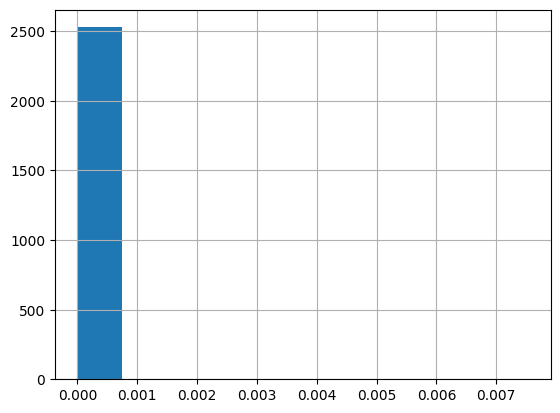

time: 119 ms (started: 2023-05-30 17:59:41 -05:00)


In [181]:
x = df_raw_filter["p-value"]

plt.hist(x, bins=10)
plt.grid()
plt.show()

In [168]:
df_raw_filter["p-value"].isna().sum()

0

time: 3.19 ms (started: 2023-05-30 17:54:31 -05:00)


In [64]:
p_values = anova(df_raw_filter)

df_raw_filter["p-value"] = p_values
print(df_raw_filter.shape)
df_raw_filter

(2540, 7)


,WT,WT,A,A,B,B,p-value
id,,,,,,,
2,2.722634,0.000000,-6.28570,-6.28570,-5.28570,-6.28570,0.012667
5,4.752225,4.391376,-4.58762,-5.58762,-5.58762,-5.58762,0.000281
6,3.359835,2.967080,-5.44801,-4.61151,-5.15530,-5.30908,0.000328
7,2.505150,2.290035,-4.12296,-4.61904,-4.24114,-4.10532,0.000133
8,2.292256,1.770852,-4.78666,-5.78666,-5.78666,-5.78666,0.000747
...,...,...,...,...,...,...,...
7114,3.284205,3.202216,-4.49322,-4.26143,-6.41806,-6.41806,0.000005
7115,3.148603,2.970812,-5.00350,-4.84296,-4.60468,-4.60448,0.000007
7116,3.470704,3.130655,-5.25342,-6.13739,-4.72901,-5.49534,0.000620


time: 4.1 s (started: 2023-05-30 16:24:25 -05:00)


In [ ]:
df_raw_filter_anova["p-value"].isna().sum()

In [99]:
# df_raw_filter_p = df_raw_filter[df_raw_filter["p-value"] < 0.001]
# df_raw_filter_p

time: 421 µs (started: 2023-05-27 18:18:22 -05:00)


In [61]:
print(df_raw_filter.shape)
df_raw_filter["p-value"].isna().sum()

(2540, 9)


2540

time: 5.06 ms (started: 2023-05-30 16:20:32 -05:00)


---
---

In [ ]:
# ANOVA
df_raw_filter_anova = df_raw_filter.copy()
p_values = anova(df_raw_filter_anova)
df_raw_filter_anova["p-value"] = p_values
df_raw_filter_anova

In [101]:
# Filter by ANOVA (p > 0.001)
df_raw_filter_anova_p = df_raw_filter_anova[df_raw_filter_anova["p-value"] > 0.001]
df_raw_filter_anova_p

nodes = list(df_raw_filter_anova_p.index)
len(nodes)

1651

time: 7.09 ms (started: 2023-05-27 18:18:38 -05:00)


#### Filter graph by ANOVA

In [108]:
H3 = H2.subgraph(nodes)
graph_detail(H3)

list_graphs.append(H3.copy())

Num. nodes: 1651
Num. edges: 11868

time: 103 ms (started: 2023-05-27 18:25:38 -05:00)


In [103]:
edges = list(H3.edges())

df_edge_embeddings_join_filter_count_weight_std_avg_anova = pd.DataFrame(edges, columns=["source", "target"])
df_edge_embeddings_join_filter_count_weight_std_avg_anova["weight"] = [H3.get_edge_data(edge[0], edge[1], default=0)["weight"] for edge in edges]
df_edge_embeddings_join_filter_count_weight_std_avg_anova.to_csv("{}/output_greedy/edges_filter_weight_std_avg_anova/greedy_{}_edge-filter-weight-std-avg-anova.csv".format(dir, group[0]), index=False)
df_edge_embeddings_join_filter_count_weight_std_avg_anova

,source,target,weight
0,61.9884,293.1786,0.596832
1,122.9910,123.0007,0.989721
2,122.9910,123.0188,0.969324
3,122.9910,123.0360,0.900589
4,122.9910,123.9906,0.952875
...,...,...,...
11863,492.9771,493.0401,0.805087
11864,494.9997,495.0368,0.774382
11865,504.1338,504.0519,0.676079
11866,505.1609,505.1361,0.764508


time: 143 ms (started: 2023-05-27 18:18:38 -05:00)


In [104]:
df_edge_embeddings_join_filter_count_weight_std_avg_anova = pd.read_csv("{}/output_greedy/edges_filter_weight_std_avg_anova/greedy_{}_edge-filter-weight-std-avg-anova.csv".format(dir, group[0]))
df_edge_embeddings_join_filter_count_weight_std_avg_anova

,source,target,weight
0,61.9884,293.1786,0.596832
1,122.9910,123.0007,0.989721
2,122.9910,123.0188,0.969324
3,122.9910,123.0360,0.900589
4,122.9910,123.9906,0.952875
...,...,...,...
11863,492.9771,493.0401,0.805087
11864,494.9997,495.0368,0.774382
11865,504.1338,504.0519,0.676079
11866,505.1609,505.1361,0.764508


time: 21.8 ms (started: 2023-05-27 18:18:38 -05:00)


In [105]:
H4 = nx.from_pandas_edgelist(df_edge_embeddings_join_filter_count_weight_std_avg_anova, "source", "target")
graph_detail(H4)

list_graphs.append(H4.copy())

Num. nodes: 1452
Num. edges: 11868

time: 52.8 ms (started: 2023-05-27 18:18:38 -05:00)


In [106]:
for graph in list_graphs:
    graph_detail(graph)
    print()

Num. nodes: 4202
Num. edges: 135076


Num. nodes: 4181
Num. edges: 131540


Num. nodes: 1651
Num. edges: 11868


Num. nodes: 1452
Num. edges: 11868


time: 11.9 ms (started: 2023-05-27 18:18:38 -05:00)
